This script setup the experiments, assuming that the l4s part has been installed correctly. 

In [1]:
import subprocess

tx0_prefix = "ssh PeterYao@pc490.emulab.net"
router0_prefix = "ssh PeterYao@pc500.emulab.net"
router1_prefix = "ssh PeterYao@pc487.emulab.net"
rx0_prefix = "ssh PeterYao@pc816.emulab.net"

nodes_prefix = [tx0_prefix, router0_prefix, router1_prefix, rx0_prefix]

class node:
    def __init__(self, node_ssh_prefix) -> None:
        self.ssh_prefix = node_ssh_prefix

    def execute(self, command, background=False):
        if background:
            print("executing in background")
            # full_command = f"{self.ssh_prefix} 'setsid nohup {command} > /dev/null 2>&1 &'"
            full_command = f'{self.ssh_prefix} "{command}"'
            subprocess.Popen(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        else:
            full_command = f'{self.ssh_prefix} "{command}"'
            result = subprocess.run(full_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if result.returncode == 0:
                print(result.stdout.decode('utf-8'))
            else:
                print(f"Error: {result.stderr.decode('utf-8')}")
        return None
        
tx0_node = node(tx0_prefix)
delay_node = node(router0_prefix)
router_node = node(router1_prefix)
rx0_node = node(rx0_prefix)

nodes = [tx0_node, delay_node, router_node, rx0_node]





In [2]:
from fabric import Connection


tx = Connection(
    host='pc490.emulab.net',
    user = 'PeterYao',
    port=22,
)




delay = Connection(
    host='pc500.emulab.net',
    user = 'PeterYao',
    port=22,
)


router = Connection(
    host='pc487.emulab.net',
    user='PeterYao',
    port=22,
)

rx = Connection(
    host='pc816.emulab.net',
    user
    = 'PeterYao',  
    port=22,
)

conns = [router, delay, tx, rx]


# Experiment 1 50-50 base thp and latency

In [ ]:
commands_noecn = "bash -c 'sudo sysctl -w net.ipv4.tcp_congestion_control=cubic; sudo sysctl -w net.ipv4.tcp_ecn=0'"
for node in nodes:
    node.execute(commands_noecn)
    
print("validating...")
for node in nodes:
    node.execute("sudo sysctl net.ipv4.tcp_congestion_control")
    node.execute("sudo sysctl net.ipv4.tcp_ecn")

In [ ]:
# for some reason, this cannot be automated

for node in nodes:
    # Download and unzip the kernel package
    node.execute("wget https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip")
    node.execute("sudo apt install unzip")
    node.execute("unzip l4s-testing.zip")
    
    # Install the kernel packages and update GRUB
    node.execute("sudo dpkg --install debian_build/*")
    node.execute("sudo update-grub")
    node.execute("sudo reboot")

for node in nodes:
    # check kernel version
    node.execute("hostname; uname -a")

In [ ]:
cmd_dualpi2="""sudo apt-get update
sudo apt -y install git gcc make bison flex libdb-dev libelf-dev pkg-config libbpf-dev libmnl-dev libcap-dev libatm1-dev selinux-utils libselinux1-dev
sudo git clone https://github.com/L4STeam/iproute2.git
cd iproute2
sudo chmod +x configure
sudo ./configure
sudo make
sudo make install"""

router.run(cmd_dualpi2)
router.run("sudo modprobe sch_dualpi2")

In [ ]:
packages = ['iperf3', 'net-tools', 'moreutils']
for conn in conns:
    for package in packages:
        conn.sudo(f'sudo apt update; apt-get -y install {package}')

In [ ]:
offloads = ["gro", "lro", "gso", "tso"]

for conn in conns[:3]:
    for offload in offloads:
        conn.sudo(f'ethtool -K eno3 {offload} off', warn=True)
        conn.sudo(f'ethtool -K enp5s0f0 {offload} off', warn=True)
        conn.sudo(f'ethtool -K enp4s0f0 {offload} off',     warn=True)
        conn.sudo(f'ethtool -K enp6s0f3 {offload} off',    warn=True)
        
        
        
        
        



In [ ]:
rx.sudo('ethtool -K vlan171 gro off')
rx.sudo('ethtool -K vlan171 lro off')
rx.sudo('ethtool -K vlan171 gso off')
rx.sudo('ethtool -K vlan171 tso off')

In [15]:
# modify the delay on the delay node
base_rtt = 25
delay_interfaces = ["enp5s0f0", "eno3"]

for e in delay_interfaces:
    cmds = "sudo tc qdisc replace dev {iface} root netem delay {owd}ms limit 60000".format(iface=e, owd=base_rtt/2)
    delay.run(cmds)

In [ ]:
delay.run("sudo tc qdisc show dev enp5s0f0")
delay.run("sudo tc qdisc show dev eno3")

In [ ]:
# set up the btl node
n_bdp = 2
base_rtt = 25
btl_capacity = 100 #in Mbps

# fixed values
btl_limit    = int(1000*n_bdp*btl_capacity*base_rtt/8) # limit of the bottleneck, n_bdp x BDP in bytes 
packet_number=int(btl_limit/1500)+1

print("btl limit: ", btl_limit)
print("packet number: ", packet_number)

In [ ]:
from fabric import ThreadingGroup
from invoke.exceptions import UnexpectedExit

# Define hosts with respective ports
hosts = [
    'PeterYao@pc605.emulab.net:30042',
    'PeterYao@pc603.emulab.net:30042',
    'PeterYao@pc604.emulab.net:30042',
    'PeterYao@pc760.emulab.net:22',
]

# Initialize the ThreadingGroup
group = ThreadingGroup(*hosts)

commands = [
    "wget https://github.com/L4STeam/linux/releases/download/testing-build/l4s-testing.zip",
    "sudo apt update && sudo apt install -y unzip",
    "unzip l4s-testing.zip",
    "sudo dpkg --install debian_build/*",
    "sudo update-grub",
    "sudo reboot"
]

with group as g:
    for cmd in commands:
        try:
            print(f"Executing: {cmd}")
            g.run(cmd, hide=False)
        except UnexpectedExit as e:
            print(f"Command failed: {cmd}\nError: {e}")

In [ ]:
cmd = "hostname; uname -a"

with group as g:
    try:
        print(f"Executing: {cmd}")
        g.run(cmd, hide=False)
    except Exception as e:
        print(f"Command failed: {cmd}\nError: {e}")

In [ ]:
# setup the router queueing discipline
router_egress_name = "eno3"

cmds_prefix = '''
            sudo tc qdisc del dev {iface} root
            sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
            sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
            '''.format(iface=router_egress_name, capacity=btl_capacity, buffer=btl_limit)
            
cmds_specific = "sudo tc qdisc add dev {iface} parent 1:3 handle 3: bfifo limit {buffer}".format(iface=router_egress_name, buffer=btl_limit)

router.run(cmds_prefix)    
router.run(cmds_specific)
router.run("sudo tc qdisc show dev {iface}".format(iface=router_egress_name))  




In [ ]:
router.run("sudo tc qdisc show dev {iface}".format(iface=router_egress_name))  


In [ ]:
rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_congestion_control=cubic")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_congestion_control=cubic")

rx.sudo("ip netns exec ue1 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("ip netns exec ue3 sysctl -w net.ipv4.tcp_ecn=0")

In [ ]:
rx.sudo("docker exec rfsim5g-oai-nr-ue1 sysctl net.ipv4.tcp_congestion_control")
rx.sudo("docker exec rfsim5g-oai-nr-ue1 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("docker exec rfsim5g-oai-nr-ue1 sysctl net.ipv4.tcp_ecn")


rx.sudo("docker exec rfsim5g-oai-nr-ue2 sysctl net.ipv4.tcp_congestion_control")
rx.sudo("docker exec rfsim5g-oai-nr-ue2 sysctl -w net.ipv4.tcp_ecn=0")
rx.sudo("docker exec rfsim5g-oai-nr-ue2 sysctl net.ipv4.tcp_ecn")




In [ ]:
rx.run("ls -l")

In [ ]:
for c in conns:
    c.run("sudo sysctl -w net.ipv4.tcp_no_metrics_save=1")

In [ ]:
# rx.sudo("docker exec -it rfsim5g-oai-nr-ue1 apt-get update")
# rx.sudo("docker exec -it rfsim5g-oai-nr-ue1 apt-get install -y psmisc")
rx.sudo("docker exec -it rfsim5g-oai-nr-ue2 apt-get update", warn=True)
rx.sudo("docker exec -it rfsim5g-oai-nr-ue2 apt-get install -y psmisc", warn=True)

In [23]:
# run the iperf command


rx.run("killall iperf3", warn=True)
rx.sudo("docker exec rfsim5g-oai-nr-ue1 killall iperf3", warn=True)
rx.sudo("docker exec rfsim5g-oai-nr-ue2 killall iperf3", warn=True)

router_egress_name = "eno3"
router.run("sudo ethtool -S {iface}".format(iface=router_egress_name))
router.run("ip -s link show {iface}".format(iface=router_egress_name))

# rx.sudo("ip netns exec ue1 iperf3 -s -1 -p 4000 -D")
# rx.sudo("ip netns exec ue3 iperf3 -s -1 -p 4000 -D")
rx.sudo("docker exec rfsim5g-oai-nr-ue1 iperf3 -s -1 -p 4008 -D")
rx.sudo("docker exec rfsim5g-oai-nr-ue2 iperf3 -s -1 -p 4008 -D")

local_file_path = r"d:\5g notes\5G-E2E-Wireless-Notes-OAI\exp-9-15\exp.sh"

# the monitor queue length shell script has already been copied to the router1 node
router.run("nohup ./monitor.sh eno3 60 1 > monitor.log 2>&1 &", pty=False)

# the put command is funny on windows, so I copy paster the exp file manually to the tx node
tx.run("chmod +x ~/exp.sh")
tx.run("~/exp.sh cubic-ecn-none")



iperf3: no process found
iperf3: no process found
iperf3: no process found


NIC statistics:
     rx_bytes: 68406695
     rx_error_bytes: 0
     tx_bytes: 2881645532
     tx_error_bytes: 0
     rx_ucast_packets: 937798
     rx_mcast_packets: 0
     rx_bcast_packets: 4
     tx_ucast_packets: 1899357
     tx_mcast_packets: 200
     tx_bcast_packets: 1
     tx_mac_errors: 0
     tx_carrier_errors: 0
     rx_crc_errors: 0
     rx_align_errors: 0
     tx_single_collisions: 0
     tx_multi_collisions: 0
     tx_deferred: 0
     tx_excess_collisions: 0
     tx_late_collisions: 0
     tx_total_collisions: 0
     rx_fragments: 0
     rx_jabbers: 0
     rx_undersize_packets: 0
     rx_oversize_packets: 0
     rx_64_byte_packets: 13188
     rx_65_to_127_byte_packets: 924580
     rx_128_to_255_byte_packets: 0
     rx_256_to_511_byte_packets: 34
     rx_512_to_1023_byte_packets: 0
     rx_1024_to_1522_byte_packets: 0
     rx_1523_to_9022_byte_packets: 0
     tx_64_byte_packets: 105
     tx_65_to_127_byte_packets: 1048
     tx_128_to_255_byte_packets: 40
     tx_256_to_511_b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160158.591905 tcp ESTAB 0      37     10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) timer:(on,244ms,0) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160158.591976 	 ts sack cubic wscale:12,7 rto:256 rtt:53.501/26.75 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:37 bytes_acked:1 segs_out:3 segs_in:1 data_segs_out:1 send 2165193bps lastsnd:12 lastrcv:12 lastack:12 pacing_rate 4330384bps delivered:1 busy:12ms unacked:1 rcv_space:14480 rcv_ssthresh:64088 minrtt:53.501
1727160158.591895 tcp ESTAB 0      37     10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) timer:(on,216ms,0) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160158.591976 	 ts sack cubic wscale:12,7 rto:240 rtt:39.959/19.979 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:37 bytes_acked:1 segs_out:3 segs_in:1 data_segs_out:1 send 2898971bps lastsnd:24 lastrcv:24 lastack:24 pacing_rate 5797936bps delivered:1 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160158.743407 tcp ESTAB 0      125    10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) timer:(on,140ms,0) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160158.743492 	 ts sack cubic wscale:12,7 rto:244 rtt:43.339/21.744 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:41 bytes_acked:38 bytes_received:1 segs_out:5 segs_in:3 data_segs_out:2 data_segs_in:1 send 2672881bps lastsnd:104 lastrcv:104 lastack:104 pacing_rate 5345760bps delivery_rate 172896bps delivered:2 app_limited busy:168ms unacked:1 rcv_space:14480 rcv_ssthresh:64088 notsent:121 minrtt:39.959
1727160158.743669 tcp ESTAB 0      125    10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) timer:(on,168ms,0) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160158.743739 	 ts sack cubic wscale:12,7 rto:256 rtt:55.216/23.494 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:41 bytes_acked:38 bytes_received:1 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160158.900407 tcp SYN-SENT 0      1      10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,944ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160158.900507 	 cubic rto:1000 mss:524 pmtu:1500 rcvmss:88 advmss:1460 cwnd:10 segs_out:1 lastsnd:661627080 lastrcv:661627080 lastack:661627080 unacked:1 rcv_ssthresh:64240
1727160158.900546 tcp ESTAB    0      0      10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160158.900581 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:2 segs_out:7 segs_in:6 data_segs_out:3 data_segs_in:2 send 2074536bps lastsnd:124 lastrcv:56 lastack:56 pacing_rate 4149056bps delivery_rate 172896bps delivered:4 app_limited busy:264ms rcv_space:14480 rcv_ssthresh:64088 minrtt:39.959
1727160158.903708 tcp SYN-SENT 0      1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160159.047122 tcp ESTAB 0      0      10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160159.047201 	 ts sack cubic wscale:12,7 rto:280 rtt:76.422/29.936 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:37 bytes_acked:38 segs_out:3 segs_in:2 data_segs_out:1 send 1515794bps lastsnd:132 lastrcv:132 lastack:52 pacing_rate 3031576bps delivery_rate 141392bps delivered:2 app_limited busy:80ms rcv_space:14480 rcv_ssthresh:64088 minrtt:75.636
1727160159.047230 tcp ESTAB 0      0      10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160159.047256 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:3 segs_out:8 segs_in:7 data_segs_out:3 data_segs_in:3 send 2074536bps lastsnd:276 lastrcv:52 lastack:208 pa

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160159.192321 tcp ESTAB 0      153488 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,104ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160159.192396 	 ts sack cubic wscale:12,7 rto:272 rtt:71.991/4.185 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:20 bytes_sent:43477 bytes_acked:14518 segs_out:33 segs_in:12 data_segs_out:31 send 3218180bps lastsnd:48 lastrcv:280 lastack:48 pacing_rate 6436360bps delivery_rate 1637400bps delivered:12 app_limited busy:196ms unacked:20 rcv_space:14480 rcv_ssthresh:64088 notsent:124528 minrtt:70.321
1727160159.192425 tcp ESTAB 0      0      10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160159.192450 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160159.335986 tcp ESTAB 0      570512 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160159.336063 	 ts sack cubic wscale:12,7 rto:300 rtt:96.128/9.04 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:74 bytes_sent:199861 bytes_acked:92710 segs_out:141 segs_in:58 data_segs_out:139 send 8917443bps lastsnd:4 lastrcv:424 lastack:4 pacing_rate 17834720bps delivery_rate 3932376bps delivered:66 busy:340ms unacked:74 rcv_space:14480 rcv_ssthresh:64088 notsent:463360 minrtt:70.321
1727160159.336092 tcp ESTAB 0      0      10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160159.336116 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 2074

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160159.488837 tcp ESTAB 0      1220664 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160159.488927 	 ts sack cubic wscale:12,7 rto:328 rtt:125.801/2.633 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:165 bytes_sent:448917 bytes_acked:224478 segs_out:313 segs_in:149 data_segs_out:311 send 15193520bps lastrcv:572 pacing_rate 30386856bps delivery_rate 7855832bps delivered:157 busy:488ms unacked:155 rcv_space:14480 rcv_ssthresh:64088 notsent:996224 minrtt:59.238
1727160159.488959 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160159.488985 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 2074536bps las

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160159.635374 tcp ESTAB 0      1059936 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160159.635447 	 ts sack cubic wscale:12,7 rto:380 rtt:177.162/7.888 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:177 ssthresh:172 bytes_sent:641501 bytes_acked:385206 segs_out:446 segs_in:222 data_segs_out:444 send 11573407bps lastrcv:724 pacing_rate 13888048bps delivery_rate 8497304bps delivered:268 busy:640ms unacked:177 rcv_space:14480 rcv_ssthresh:64088 notsent:803640 minrtt:59.238
1727160159.635478 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160159.635501 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 2

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160159.784756 tcp ESTAB 0      1414696 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160159.784835 	 ts sack cubic wscale:12,7 rto:420 rtt:218.266/1.124 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:182 ssthresh:172 bytes_sent:815261 bytes_acked:551726 segs_out:566 segs_in:329 data_segs_out:564 send 9659260bps lastsnd:4 lastrcv:868 lastack:4 pacing_rate 11591104bps delivery_rate 9199552bps delivered:383 busy:784ms unacked:182 rcv_space:14480 rcv_ssthresh:64088 notsent:1151160 minrtt:59.238
1727160159.784864 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160159.784889 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 d

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160159.931516 tcp ESTAB 0      1291616 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160159.931591 	 ts sack cubic wscale:12,7 rto:464 rtt:261.798/5.492 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:187 ssthresh:172 bytes_sent:944133 bytes_acked:674806 segs_out:655 segs_in:397 data_segs_out:653 send 8274349bps lastrcv:1020 pacing_rate 9929208bps delivery_rate 7695280bps delivered:468 busy:936ms unacked:186 rcv_space:14480 rcv_ssthresh:64088 notsent:1022288 minrtt:59.238
1727160159.931622 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160159.931646 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 send 2

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160160.076596 tcp ESTAB 0      1187360 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,188ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160160.076674 	 ts sack cubic wscale:12,7 rto:512 rtt:311.17/9.154 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:190 ssthresh:172 bytes_sent:1054181 bytes_acked:779062 segs_out:731 segs_in:433 data_segs_out:729 send 7073175bps lastsnd:8 lastrcv:1164 lastack:12 pacing_rate 8487792bps delivery_rate 6434656bps delivered:540 busy:1080ms unacked:190 rcv_space:14480 rcv_ssthresh:64088 notsent:912240 minrtt:59.238
1727160160.076702 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160160.076725 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160160.227500 tcp ESTAB 0      1065728 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160160.227578 	 ts sack cubic wscale:12,7 rto:532 rtt:328.867/4.839 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:195 ssthresh:172 bytes_sent:1183053 bytes_acked:900694 segs_out:820 segs_in:475 data_segs_out:818 send 6868673bps lastsnd:8 lastrcv:1312 lastack:8 pacing_rate 8242400bps delivery_rate 6555984bps delivered:624 busy:1228ms unacked:195 rcv_space:14480 rcv_ssthresh:64088 notsent:783368 minrtt:59.238
1727160160.227607 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160160.227633 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160160.378069 tcp ESTAB 0      1531984 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160160.378157 	 ts sack cubic wscale:12,7 rto:540 rtt:336.538/3.037 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:199 ssthresh:172 bytes_sent:1307581 bytes_acked:1020878 segs_out:906 segs_in:515 data_segs_out:904 send 6849794bps lastsnd:8 lastrcv:1464 lastack:8 pacing_rate 8219744bps delivery_rate 6319128bps delivered:707 busy:1380ms unacked:198 rcv_space:14480 rcv_ssthresh:64088 notsent:1245280 minrtt:59.238
1727160160.378200 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160160.378242 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160160.521595 tcp ESTAB 0      499560 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,168ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160160.521676 	 ts sack cubic wscale:12,7 rto:280 rtt:78.586/1.183 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:84 ssthresh:39 bytes_sent:1479893 bytes_acked:1359710 segs_out:1025 segs_in:593 data_segs_out:1023 send 12382053bps lastrcv:1608 pacing_rate 14858320bps delivery_rate 10374920bps delivered:941 busy:1536ms unacked:83 rcv_space:14480 rcv_ssthresh:64088 notsent:379376 minrtt:45.635
1727160160.521705 tcp ESTAB 0      0      10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160160.521728 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4 se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160160.672985 tcp ESTAB 0      554584 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,152ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160160.673068 	 ts sack cubic wscale:12,7 rto:276 rtt:72.182/1.62 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:91 ssthresh:39 bytes_sent:1695645 bytes_acked:1565326 segs_out:1174 segs_in:652 data_segs_out:1172 send 14603973bps lastsnd:4 lastrcv:1756 lastack:4 pacing_rate 17524704bps delivery_rate 12878776bps delivered:1083 busy:1684ms unacked:90 rcv_space:14480 rcv_ssthresh:64088 notsent:424264 minrtt:45.635
1727160160.673098 tcp ESTAB 0      0      10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160160.673124 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160160.836977 tcp ESTAB 0      1653616 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160160.837052 	 ts sack cubic wscale:12,7 rto:444 rtt:243.355/3.27 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:217 ssthresh:172 bytes_sent:1865061 bytes_acked:1550846 segs_out:1291 segs_in:696 data_segs_out:1289 send 10329469bps lastrcv:1908 pacing_rate 12395328bps delivery_rate 8697656bps delivered:1073 busy:1824ms unacked:217 rcv_space:14480 rcv_ssthresh:64088 notsent:1339400 minrtt:59.238
1727160160.837084 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160160.837109 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160161.004630 tcp ESTAB 0      1479856 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160161.004726 	 ts sack cubic wscale:12,7 rto:488 rtt:286.192/4.313 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:223 ssthresh:172 bytes_sent:2046061 bytes_acked:1724606 segs_out:1416 segs_in:756 data_segs_out:1414 send 9026220bps lastsnd:4 lastrcv:2072 lastack:4 pacing_rate 10831448bps delivery_rate 8685896bps delivered:1193 busy:1988ms unacked:222 rcv_space:14480 rcv_ssthresh:64088 notsent:1158400 minrtt:59.238
1727160161.004775 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160161.004816 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160161.156120 tcp ESTAB 0      1290168 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160161.156200 	 ts sack cubic wscale:12,7 rto:488 rtt:284.583/1.338 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:230 ssthresh:172 bytes_sent:2247333 bytes_acked:1914294 segs_out:1555 segs_in:821 data_segs_out:1553 send 9362190bps lastrcv:2240 lastack:4 pacing_rate 11234592bps delivery_rate 8801440bps delivered:1324 busy:2156ms unacked:230 rcv_space:14480 rcv_ssthresh:64088 notsent:957128 minrtt:59.238
1727160161.156230 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160161.156256 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160161.306804 tcp ESTAB 0      1815792 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160161.306888 	 ts sack cubic wscale:12,7 rto:472 rtt:269.988/5.618 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:236 ssthresh:172 bytes_sent:2445709 bytes_acked:2105430 segs_out:1692 segs_in:887 data_segs_out:1690 send 10125724bps lastrcv:2392 pacing_rate 12150840bps delivery_rate 8639864bps delivered:1456 busy:2308ms unacked:235 rcv_space:14480 rcv_ssthresh:64088 notsent:1475512 minrtt:59.238
1727160161.306919 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160161.306944 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 data_segs_in:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160161.454740 tcp ESTAB 0      1626104 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160161.454817 	 ts sack cubic wscale:12,7 rto:464 rtt:263.816/1.337 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:243 ssthresh:172 bytes_sent:2646981 bytes_acked:2295118 segs_out:1831 segs_in:951 data_segs_out:1829 send 10669982bps lastrcv:2540 lastack:4 pacing_rate 12803944bps delivery_rate 10040520bps delivered:1587 busy:2456ms unacked:243 rcv_space:14480 rcv_ssthresh:64088 notsent:1274240 minrtt:59.238
1727160161.454847 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160161.454872 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:3 da

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160161.600650 tcp ESTAB 0      1364016 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160161.600730 	 ts sack cubic wscale:12,7 rto:408 rtt:205.06/5.119 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:252 ssthresh:172 bytes_sent:2922101 bytes_acked:2557206 segs_out:2021 segs_in:1040 data_segs_out:2019 send 14235677bps lastsnd:4 lastrcv:2688 lastack:4 pacing_rate 17082808bps delivery_rate 10077496bps delivered:1768 busy:2604ms unacked:252 rcv_space:14480 rcv_ssthresh:64088 notsent:999120 minrtt:59.238
1727160161.600760 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160161.600784 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160161.746268 tcp ESTAB 0      1907016 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,184ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160161.746344 	 ts sack cubic wscale:12,7 rto:396 rtt:193.793/2.08 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:260 ssthresh:172 bytes_sent:3171157 bytes_acked:2796126 segs_out:2193 segs_in:1119 data_segs_out:2191 send 15541531bps lastsnd:20 lastrcv:2836 lastack:20 pacing_rate 18649784bps delivery_rate 12204144bps delivered:1933 busy:2752ms unacked:259 rcv_space:14480 rcv_ssthresh:64088 notsent:1531984 minrtt:59.238
1727160161.746375 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160161.746399 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160161.897094 tcp ESTAB 0      1614520 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160161.897172 	 ts sack cubic wscale:12,7 rto:404 rtt:203.607/3.353 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:270 ssthresh:172 bytes_sent:3479581 bytes_acked:3088622 segs_out:2406 segs_in:1219 data_segs_out:2404 send 15361358bps lastsnd:4 lastrcv:2980 lastack:4 pacing_rate 18433616bps delivery_rate 14305664bps delivered:2135 busy:2896ms unacked:270 rcv_space:14480 rcv_ssthresh:64088 notsent:1223560 minrtt:59.238
1727160161.897201 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160161.897226 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160162.047578 tcp ESTAB 0      2141592 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160162.047662 	 ts sack cubic wscale:12,7 rto:392 rtt:190.533/1.73 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:281 ssthresh:172 bytes_sent:3814069 bytes_acked:3408630 segs_out:2637 segs_in:1328 data_segs_out:2635 send 17084201bps lastsnd:4 lastrcv:3132 lastack:4 pacing_rate 20501008bps delivery_rate 15766696bps delivered:2356 busy:3048ms unacked:280 rcv_space:14480 rcv_ssthresh:64088 notsent:1736152 minrtt:59.238
1727160162.047694 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160162.047720 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160162.197510 tcp ESTAB 0      1901224 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160162.197593 	 ts sack cubic wscale:12,7 rto:416 rtt:213.596/6.608 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:289 ssthresh:172 bytes_sent:4066021 bytes_acked:3648998 segs_out:2811 segs_in:1410 data_segs_out:2809 send 15673402bps lastsnd:8 lastrcv:3284 lastack:8 pacing_rate 18808064bps delivery_rate 14999152bps delivered:2522 busy:3200ms unacked:288 rcv_space:14480 rcv_ssthresh:64088 notsent:1484200 minrtt:59.238
1727160162.197624 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160162.197650 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160162.344434 tcp ESTAB 0      1678232 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160162.344512 	 ts sack cubic wscale:12,7 rto:472 rtt:268.098/2.814 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:297 ssthresh:172 bytes_sent:4302045 bytes_acked:3871990 segs_out:2974 segs_in:1485 data_segs_out:2972 send 12832800bps lastsnd:8 lastrcv:3432 lastack:8 pacing_rate 15399304bps delivery_rate 11815928bps delivered:2676 busy:3348ms unacked:297 rcv_space:14480 rcv_ssthresh:64088 notsent:1248176 minrtt:59.238
1727160162.344541 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160162.344565 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160162.496485 tcp ESTAB 0      2363136 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,220ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160162.496568 	 ts sack cubic wscale:12,7 rto:476 rtt:272.236/5.109 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:305 ssthresh:172 bytes_sent:4539517 bytes_acked:4099326 segs_out:3138 segs_in:1562 data_segs_out:3136 send 12978151bps lastsnd:4 lastrcv:3580 lastack:4 pacing_rate 15573752bps delivery_rate 12425240bps delivered:2833 busy:3496ms unacked:304 rcv_space:14480 rcv_ssthresh:64088 notsent:1922944 minrtt:59.238
1727160162.496599 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160162.496625 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160162.647971 tcp ESTAB 0      2131456 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,220ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160162.648061 	 ts sack cubic wscale:12,7 rto:308 rtt:104.434/5.908 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:286 ssthresh:39 bytes_sent:7597693 bytes_acked:7221214 segs_out:5250 segs_in:2379 data_segs_out:5248 send 31723615bps lastrcv:3728 pacing_rate 38068336bps delivery_rate 29069816bps delivered:4989 busy:3656ms unacked:260 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:1754976 minrtt:39.771
1727160162.648093 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160162.648119 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160162.799884 tcp ESTAB 0      2544136 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160162.799969 	 ts sack cubic wscale:12,7 rto:308 rtt:105.017/1.395 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:306 ssthresh:39 bytes_sent:8226125 bytes_acked:7785934 segs_out:5684 segs_in:2573 data_segs_out:5682 send 33753621bps lastsnd:8 lastrcv:3880 lastack:8 pacing_rate 40504296bps delivery_rate 33813864bps delivered:5379 busy:3808ms unacked:304 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2103944 minrtt:39.771
1727160162.799999 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160162.800025 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160162.952640 tcp ESTAB 0      2570200 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,192ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160162.952724 	 ts sack cubic wscale:12,7 rto:464 rtt:263.921/5.997 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:332 ssthresh:172 bytes_sent:5350397 bytes_acked:4869662 segs_out:3698 segs_in:1845 data_segs_out:3696 send 14572118bps lastsnd:12 lastrcv:4040 lastack:12 pacing_rate 17486496bps delivery_rate 13804808bps delivered:3365 busy:3956ms unacked:332 rcv_space:14480 rcv_ssthresh:64088 notsent:2089464 minrtt:59.238
1727160162.952756 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160162.952782 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160163.103394 tcp ESTAB 0      2364584 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160163.103477 	 ts sack cubic wscale:12,7 rto:492 rtt:289.688/3.687 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:339 ssthresh:172 bytes_sent:5564701 bytes_acked:5075278 segs_out:3846 segs_in:1908 data_segs_out:3844 send 13555881bps lastsnd:8 lastrcv:4188 lastack:8 pacing_rate 16267016bps delivery_rate 12692136bps delivered:3507 busy:4104ms unacked:338 rcv_space:14480 rcv_ssthresh:64088 notsent:1875160 minrtt:59.238
1727160163.103509 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160163.103536 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160163.254529 tcp ESTAB 0      2122768 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160163.254613 	 ts sack cubic wscale:12,7 rto:520 rtt:318.462/2.993 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:347 ssthresh:172 bytes_sent:5819549 bytes_acked:5317094 segs_out:4022 segs_in:1989 data_segs_out:4020 send 12622065bps lastsnd:4 lastrcv:4336 lastack:4 pacing_rate 15146456bps delivery_rate 12524312bps delivered:3674 busy:4252ms unacked:347 rcv_space:14480 rcv_ssthresh:64088 notsent:1620312 minrtt:59.238
1727160163.254644 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160163.254671 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160163.404462 tcp ESTAB 0      1901224 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160163.404549 	 ts sack cubic wscale:12,7 rto:524 rtt:321.093/4.659 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:355 ssthresh:172 bytes_sent:6052677 bytes_acked:5538638 segs_out:4183 segs_in:2062 data_segs_out:4181 send 12807255bps lastsnd:4 lastrcv:4488 lastack:4 pacing_rate 15368704bps delivery_rate 12184408bps delivered:3827 busy:4404ms unacked:355 rcv_space:14480 rcv_ssthresh:64088 notsent:1387184 minrtt:59.238
1727160163.404579 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160163.404604 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160163.557082 tcp ESTAB 0      2625224 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,216ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160163.557161 	 ts sack cubic wscale:12,7 rto:492 rtt:289.703/3.026 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:366 ssthresh:172 bytes_sent:6385717 bytes_acked:5857198 segs_out:4413 segs_in:2176 data_segs_out:4411 send 14634795bps lastrcv:4640 pacing_rate 17561696bps delivery_rate 13802088bps delivered:4047 busy:4556ms unacked:365 reord_seen:1 rcv_space:14480 rcv_ssthresh:64088 notsent:2096704 minrtt:59.238
1727160163.557199 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160163.557239 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 data_segs_out:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160163.720266 tcp ESTAB 0      2379064 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160163.720344 	 ts sack cubic wscale:12,7 rto:468 rtt:265.617/3.082 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:374 ssthresh:172 bytes_sent:6644909 bytes_acked:6103358 segs_out:4592 segs_in:2287 data_segs_out:4590 send 16310763bps lastsnd:8 lastrcv:4792 lastack:8 pacing_rate 19572912bps delivery_rate 12645272bps delivered:4217 busy:4708ms unacked:374 reord_seen:1 rcv_space:14480 rcv_ssthresh:64088 notsent:1837512 minrtt:59.238
1727160163.720373 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160163.720398 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160163.865553 tcp ESTAB 0      3121888 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160163.865637 	 ts sack cubic wscale:12,7 rto:360 rtt:156.396/3.451 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:448 ssthresh:39 bytes_sent:12545509 bytes_acked:11899702 segs_out:8667 segs_in:4107 data_segs_out:8665 send 33182639bps lastsnd:4 lastrcv:4948 lastack:4 pacing_rate 39819160bps delivery_rate 31879200bps delivered:8220 busy:4876ms unacked:446 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2476080 minrtt:39.771
1727160163.865669 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160163.865695 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160164.011892 tcp ESTAB 0      2513728 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160164.011972 	 ts sack cubic wscale:12,7 rto:356 rtt:155.549/4.991 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:469 ssthresh:39 bytes_sent:13186973 bytes_acked:12507862 segs_out:9110 segs_in:4317 data_segs_out:9108 send 34927232bps lastrcv:5096 pacing_rate 41912536bps delivery_rate 30832016bps delivered:8640 busy:5024ms unacked:469 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:1834616 minrtt:39.771
1727160164.012047 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160164.012092 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160164.162516 tcp ESTAB 0      3285792 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160164.162600 	 ts sack cubic wscale:12,7 rto:372 rtt:170.534/1.552 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:488 ssthresh:39 bytes_sent:13753141 bytes_acked:13046518 segs_out:9501 segs_in:4503 data_segs_out:9499 send 33148768bps lastsnd:12 lastrcv:5244 lastack:12 pacing_rate 39778520bps delivery_rate 32686784bps delivered:9012 busy:5172ms unacked:488 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2579168 minrtt:39.771
1727160164.162632 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160164.162659 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receive

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160164.311769 tcp ESTAB 0      2700800 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160164.311849 	 ts sack cubic wscale:12,7 rto:392 rtt:188.778/3.081 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:508 ssthresh:39 bytes_sent:14351165 bytes_acked:13631510 segs_out:9914 segs_in:4704 data_segs_out:9912 send 31172446bps lastrcv:5392 pacing_rate 37406856bps delivery_rate 29040008bps delivered:9416 busy:5320ms unacked:497 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:1981144 minrtt:39.771
1727160164.311880 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160164.311905 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160164.459797 tcp ESTAB 0      3532232 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160164.459876 	 ts sack cubic wscale:12,7 rto:392 rtt:190.205/4.423 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:524 ssthresh:39 bytes_sent:14869549 bytes_acked:14110798 segs_out:10272 segs_in:4869 data_segs_out:10270 send 31913020bps lastsnd:8 lastrcv:5540 lastack:8 pacing_rate 38295624bps delivery_rate 28650848bps delivered:9747 busy:5468ms unacked:524 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2773480 minrtt:39.771
1727160164.459906 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160164.459932 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receive

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160164.610726 tcp ESTAB 0      2973304 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160164.610806 	 ts sack cubic wscale:12,7 rto:408 rtt:204.106/0.198 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:544 ssthresh:39 bytes_sent:15455989 bytes_acked:14669726 segs_out:10677 segs_in:5069 data_segs_out:10675 send 30874624bps lastsnd:8 lastrcv:5688 lastack:8 pacing_rate 37049544bps delivery_rate 29258936bps delivered:10133 busy:5616ms unacked:543 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2187040 minrtt:39.771
1727160164.610836 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160164.610860 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160164.757361 tcp ESTAB 0      3714960 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160164.757440 	 ts sack cubic wscale:12,7 rto:404 rtt:202.457/0.869 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:563 ssthresh:39 bytes_sent:16051117 bytes_acked:15238790 segs_out:11088 segs_in:5265 data_segs_out:11086 send 32213221bps lastsnd:8 lastrcv:5840 lastack:8 pacing_rate 38655696bps delivery_rate 30352736bps delivered:10526 busy:5768ms unacked:561 reordering:5 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2902632 minrtt:39.771
1727160164.757470 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160164.757494 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160164.914786 tcp ESTAB 0      2793192 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,588ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160164.914861 	 ts sack cubic wscale:12,7 rto:592 rtt:390.108/0.844 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:441 ssthresh:172 bytes_sent:8672109 bytes_acked:8034990 segs_out:5992 segs_in:2961 data_segs_out:5990 send 13095204bps lastsnd:4 lastrcv:5992 lastack:4 pacing_rate 15714232bps delivery_rate 12425336bps delivered:5551 busy:5908ms unacked:440 reord_seen:2 rcv_space:14480 rcv_ssthresh:64088 notsent:2156072 minrtt:59.238
1727160164.914888 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160164.914919 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160165.065348 tcp ESTAB 0      2454360 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160165.065432 	 ts sack cubic wscale:12,7 rto:564 rtt:362.187/5.625 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:453 ssthresh:172 bytes_sent:9029765 bytes_acked:8373822 segs_out:6239 segs_in:3079 data_segs_out:6237 send 14488516bps lastsnd:8 lastrcv:6152 lastack:12 pacing_rate 17386200bps delivery_rate 13361408bps delivered:5785 busy:6068ms unacked:453 reord_seen:2 rcv_space:14480 rcv_ssthresh:64088 notsent:1798416 minrtt:59.238
1727160165.065464 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160165.065491 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160165.215867 tcp ESTAB 0      3514576 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160165.215949 	 ts sack cubic wscale:12,7 rto:536 rtt:334.818/4.904 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:461 ssthresh:172 bytes_sent:9290405 bytes_acked:8624326 segs_out:6419 segs_in:3167 data_segs_out:6417 send 15949632bps lastrcv:6300 pacing_rate 19139536bps delivery_rate 13257768bps delivered:5958 busy:6216ms unacked:460 reordering:4 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2848496 minrtt:59.238
1727160165.215980 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160165.216006 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 d

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160165.365085 tcp ESTAB 0      3277104 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,192ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160165.365163 	 ts sack cubic wscale:12,7 rto:568 rtt:367.151/4.47 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:469 ssthresh:172 bytes_sent:9539461 bytes_acked:8861798 segs_out:6591 segs_in:3265 data_segs_out:6589 send 14797443bps lastsnd:8 lastrcv:6448 lastack:8 pacing_rate 17756912bps delivery_rate 13604496bps delivered:6122 busy:6364ms unacked:468 reordering:4 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2599440 minrtt:59.238
1727160165.365193 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160165.365218 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 seg

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160165.515768 tcp ESTAB 0      3447640 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160165.515851 	 ts sack cubic wscale:12,7 rto:448 rtt:246.446/1.391 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:663 ssthresh:39 bytes_sent:19087573 bytes_acked:18127550 segs_out:13185 segs_in:6287 data_segs_out:13183 send 31163792bps lastsnd:8 lastrcv:6596 lastack:8 pacing_rate 37396472bps delivery_rate 29555336bps delivered:12521 busy:6524ms unacked:663 reordering:6 reord_seen:6 rcv_space:14480 rcv_ssthresh:64088 notsent:2487616 minrtt:39.771
1727160165.515882 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160165.515912 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160165.667765 tcp ESTAB 0      2836584 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,444ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160165.667849 	 ts sack cubic wscale:12,7 rto:444 rtt:241.637/3.024 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:684 ssthresh:39 bytes_sent:19726141 bytes_acked:18738606 segs_out:13626 segs_in:6533 data_segs_out:13624 send 32790740bps lastrcv:6748 pacing_rate 39348864bps delivery_rate 30549760bps delivered:12943 busy:6676ms unacked:682 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1849048 minrtt:39.771
1727160165.667880 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160165.667906 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160165.819640 tcp ESTAB 0      2490840 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160165.819716 	 ts sack cubic wscale:12,7 rto:596 rtt:394.967/2.067 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:496 ssthresh:172 bytes_sent:10364821 bytes_acked:9648062 segs_out:7161 segs_in:3534 data_segs_out:7159 send 14547200bps lastrcv:6904 pacing_rate 17456632bps delivery_rate 13610176bps delivered:6665 busy:6820ms unacked:495 reordering:4 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:1774080 minrtt:59.238
1727160165.819748 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160165.819616 tcp ESTAB 0      3579688 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160165.975465 tcp ESTAB 0      3546712 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,216ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160165.975546 	 ts sack cubic wscale:12,7 rto:608 rtt:404.276/0.935 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:505 ssthresh:172 bytes_sent:10632701 bytes_acked:9902910 segs_out:7346 segs_in:3616 data_segs_out:7344 send 14470114bps lastrcv:7052 pacing_rate 17364104bps delivery_rate 13717432bps delivered:6841 busy:6968ms unacked:504 reordering:4 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:2816920 minrtt:59.238
1727160165.975576 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160165.975601 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs_in:8 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160166.135026 tcp ESTAB 0      3695808 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160166.135100 	 ts sack cubic wscale:12,7 rto:456 rtt:253.524/3.539 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:745 ssthresh:39 bytes_sent:21579581 bytes_acked:20500822 segs_out:14906 segs_in:7194 data_segs_out:14904 send 34040485bps lastsnd:4 lastrcv:7208 lastack:4 pacing_rate 40848480bps delivery_rate 31223592bps delivered:14160 busy:7136ms unacked:745 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:2617048 minrtt:39.771
1727160166.135133 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160166.135169 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160166.288822 tcp ESTAB 0      3064480 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160166.288897 	 ts sack cubic wscale:12,7 rto:468 rtt:265.399/0.734 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:767 ssthresh:39 bytes_sent:22223941 bytes_acked:21132150 segs_out:15351 segs_in:7410 data_segs_out:15349 send 33477624bps lastrcv:7364 pacing_rate 40173088bps delivery_rate 31328080bps delivered:14596 busy:7292ms unacked:754 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1972688 minrtt:39.771
1727160166.288927 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160166.288951 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160166.435136 tcp ESTAB 0      2734384 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160166.435223 	 ts sack cubic wscale:12,7 rto:624 rtt:421.582/4.496 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:533 ssthresh:172 bytes_sent:11485573 bytes_acked:10715238 segs_out:7935 segs_in:3924 data_segs_out:7933 send 14645483bps lastsnd:4 lastrcv:7524 lastack:4 pacing_rate 17574552bps delivery_rate 13906360bps delivered:7402 busy:7440ms unacked:532 reordering:4 reord_seen:4 rcv_space:14480 rcv_ssthresh:64088 notsent:1964048 minrtt:59.238
1727160166.435252 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160166.435276 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160166.585033 tcp ESTAB 0      3218248 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160166.585118 	 ts sack cubic wscale:12,7 rto:484 rtt:283.419/1.202 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:807 ssthresh:39 bytes_sent:23457637 bytes_acked:22289102 segs_out:16203 segs_in:7809 data_segs_out:16201 send 32983985bps lastsnd:4 lastrcv:7668 lastack:8 pacing_rate 39580776bps delivery_rate 31625984bps delivered:15395 busy:7596ms unacked:807 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:2049712 minrtt:39.771
1727160166.585149 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160166.585195 tcp ESTAB 0      2488224 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreach

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160166.736315 tcp ESTAB 0      2670904 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160166.736400 	 ts sack cubic wscale:12,7 rto:504 rtt:301.447/0.317 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:826 ssthresh:39 bytes_sent:24031045 bytes_acked:22836446 segs_out:16599 segs_in:8023 data_segs_out:16597 send 31741513bps lastrcv:7816 pacing_rate 38089816bps delivery_rate 29892208bps delivered:15773 busy:7744ms unacked:825 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1476304 minrtt:39.771
1727160166.736431 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160166.736457 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160166.888517 tcp ESTAB 0      3419800 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160166.888601 	 ts sack cubic wscale:12,7 rto:520 rtt:318.929/0.531 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:845 ssthresh:39 bytes_sent:24621829 bytes_acked:23398270 segs_out:17007 segs_in:8214 data_segs_out:17005 send 30691721bps lastsnd:4 lastrcv:7972 lastack:4 pacing_rate 36830032bps delivery_rate 28847184bps delivered:16161 busy:7900ms unacked:845 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:2196240 minrtt:39.771
1727160166.888632 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160166.888659 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160167.034524 tcp ESTAB 0      2843496 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160167.034606 	 ts sack cubic wscale:12,7 rto:512 rtt:311.393/1.471 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:865 ssthresh:39 bytes_sent:25225645 bytes_acked:23974574 segs_out:17424 segs_in:8423 data_segs_out:17422 send 32178501bps lastsnd:4 lastrcv:8120 lastack:4 pacing_rate 38614152bps delivery_rate 30531008bps delivered:16559 busy:8048ms unacked:864 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1592424 minrtt:39.771
1727160167.034638 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160167.034662 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160167.185713 tcp ESTAB 0      3564880 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160167.185793 	 ts sack cubic wscale:12,7 rto:512 rtt:310.313/5.113 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:885 ssthresh:39 bytes_sent:25842493 bytes_acked:24563910 segs_out:17850 segs_in:8636 data_segs_out:17848 send 33037095bps lastrcv:8264 pacing_rate 39644480bps delivery_rate 30457040bps delivered:16966 busy:8192ms unacked:883 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:2286296 minrtt:39.771
1727160167.185830 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160167.185869 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160167.328040 tcp ESTAB 0      2920520 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,488ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160167.328114 	 ts sack cubic wscale:12,7 rto:496 rtt:292.83/1.435 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:908 ssthresh:39 bytes_sent:26520157 bytes_acked:25208270 segs_out:18318 segs_in:8859 data_segs_out:18316 send 35919380bps lastsnd:8 lastrcv:8416 lastack:8 pacing_rate 43103144bps delivery_rate 31444000bps delivered:17411 busy:8344ms unacked:906 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1608632 minrtt:39.771
1727160167.328149 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160167.328186 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receive

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160167.471082 tcp ESTAB 0      3665072 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160167.471160 	 ts sack cubic wscale:12,7 rto:500 rtt:299.579/1.439 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:927 ssthresh:39 bytes_sent:27115285 bytes_acked:25774438 segs_out:18729 segs_in:9069 data_segs_out:18727 send 35844862bps lastsnd:20 lastrcv:8560 lastack:20 pacing_rate 43013816bps delivery_rate 33354480bps delivered:17802 busy:8488ms unacked:926 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:2324224 minrtt:39.771
1727160167.471190 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160167.471216 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rece

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160167.616566 tcp ESTAB 0      3091664 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160167.616640 	 ts sack cubic wscale:12,7 rto:524 rtt:323.051/1.873 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:947 ssthresh:39 bytes_sent:27717653 bytes_acked:26347846 segs_out:19145 segs_in:9263 data_segs_out:19143 send 33957635bps lastrcv:8700 pacing_rate 40749096bps delivery_rate 31937896bps delivered:18198 busy:8628ms unacked:946 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1721856 minrtt:39.771
1727160167.616671 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160167.616694 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 segs

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160167.767183 tcp ESTAB 0      2519704 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160167.767268 	 ts sack cubic wscale:12,7 rto:536 rtt:334.865/5.032 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:967 ssthresh:39 bytes_sent:28318573 bytes_acked:26919806 segs_out:19560 segs_in:9459 data_segs_out:19558 send 33451474bps lastsnd:4 lastrcv:8848 lastack:4 pacing_rate 40141720bps delivery_rate 32379656bps delivered:18593 busy:8776ms unacked:966 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1120936 minrtt:39.771
1727160167.767299 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160167.767326 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160167.918909 tcp ESTAB 0      3252672 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160167.918987 	 ts sack cubic wscale:12,7 rto:544 rtt:342.656/4.317 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:987 ssthresh:39 bytes_sent:28926733 bytes_acked:27497558 segs_out:19980 segs_in:9655 data_segs_out:19978 send 33367015bps lastsnd:8 lastrcv:9000 lastack:12 pacing_rate 40040368bps delivery_rate 31640960bps delivered:18992 busy:8928ms unacked:987 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1823496 minrtt:39.771
1727160167.919018 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160167.919048 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_recei

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160168.066281 tcp ESTAB 0      2540256 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160168.066365 	 ts sack cubic wscale:12,7 rto:520 rtt:318.165/2.66 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1011 ssthresh:39 bytes_sent:29673901 bytes_acked:28209974 segs_out:20496 segs_in:9939 data_segs_out:20494 send 36809278bps lastsnd:8 lastrcv:9148 lastack:8 pacing_rate 44171008bps delivery_rate 33403704bps delivered:19484 busy:9076ms unacked:1011 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1076328 minrtt:39.771
1727160168.066396 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160168.066422 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_recei

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160168.217759 tcp ESTAB 0      3292048 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160168.217848 	 ts sack cubic wscale:12,7 rto:532 rtt:330.117/5.082 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1030 ssthresh:39 bytes_sent:30258893 bytes_acked:28768902 segs_out:20900 segs_in:10131 data_segs_out:20898 send 36143307bps lastsnd:12 lastrcv:9300 lastack:12 pacing_rate 43371896bps delivery_rate 33287648bps delivered:19870 busy:9228ms unacked:1029 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1802056 minrtt:39.771
1727160168.217879 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160168.217904 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160168.364550 tcp ESTAB 0      2724432 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160168.364629 	 ts sack cubic wscale:12,7 rto:564 rtt:362.706/0.474 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1050 ssthresh:39 bytes_sent:30855469 bytes_acked:29336518 segs_out:21312 segs_in:10327 data_segs_out:21310 send 33534598bps lastsnd:8 lastrcv:9448 lastack:8 pacing_rate 40241512bps delivery_rate 31853224bps delivered:20262 busy:9376ms unacked:1049 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1205480 minrtt:39.771
1727160168.364660 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160168.364685 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rec

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160168.516296 tcp ESTAB 0      3409616 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160168.516380 	 ts sack cubic wscale:12,7 rto:568 rtt:364.972/3.036 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1072 ssthresh:39 bytes_sent:31511413 bytes_acked:29962054 segs_out:21765 segs_in:10542 data_segs_out:21763 send 34024659bps lastsnd:8 lastrcv:9596 lastack:12 pacing_rate 40829488bps delivery_rate 32872136bps delivered:20694 busy:9524ms unacked:1070 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1860256 minrtt:39.771
1727160168.516411 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160168.516437 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160168.667442 tcp ESTAB 0      2801456 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160168.667526 	 ts sack cubic wscale:12,7 rto:568 rtt:367.731/4.527 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1093 ssthresh:39 bytes_sent:32149981 bytes_acked:30570214 segs_out:22206 segs_in:10752 data_segs_out:22204 send 34430907bps lastsnd:8 lastrcv:9748 lastack:8 pacing_rate 41317032bps delivery_rate 32742720bps delivered:21114 busy:9676ms unacked:1091 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1221688 minrtt:39.771
1727160168.667557 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160168.667583 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rec

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160168.810609 tcp ESTAB 0      3490984 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160168.810687 	 ts sack cubic wscale:12,7 rto:576 rtt:373.151/2.402 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1114 ssthresh:39 bytes_sent:32804477 bytes_acked:31191406 segs_out:22658 segs_in:10966 data_segs_out:22656 send 34582719bps lastrcv:9896 pacing_rate 41499248bps delivery_rate 31930616bps delivered:21543 busy:9824ms unacked:1114 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1877912 minrtt:39.771
1727160168.810717 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160168.810741 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160168.960742 tcp ESTAB 0      2923368 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160168.960826 	 ts sack cubic wscale:12,7 rto:592 rtt:389.775/2.062 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1134 ssthresh:39 bytes_sent:33401053 bytes_acked:31759022 segs_out:23070 segs_in:11162 data_segs_out:23068 send 33702151bps lastsnd:4 lastrcv:10040 lastack:4 pacing_rate 40442552bps delivery_rate 32785592bps delivered:21935 busy:9968ms unacked:1134 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1281336 minrtt:39.771
1727160168.960858 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160168.960885 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160169.104993 tcp ESTAB 0      3569456 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160169.105067 	 ts sack cubic wscale:12,7 rto:580 rtt:377.634/2.654 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1157 ssthresh:39 bytes_sent:34096093 bytes_acked:32423654 segs_out:23550 segs_in:11391 data_segs_out:23548 send 35491211bps lastsnd:8 lastrcv:10192 lastack:8 pacing_rate 42589448bps delivery_rate 34051544bps delivered:22394 busy:10120ms unacked:1155 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1897016 minrtt:39.771
1727160169.105097 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160169.105121 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160169.252772 tcp ESTAB 0      3000392 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160169.252856 	 ts sack cubic wscale:12,7 rto:588 rtt:385.427/1.074 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1176 ssthresh:39 bytes_sent:34695565 bytes_acked:32992718 segs_out:23964 segs_in:11587 data_segs_out:23962 send 35344654bps lastsnd:4 lastrcv:10336 lastack:4 pacing_rate 42413512bps delivery_rate 33445432bps delivered:22787 busy:10264ms unacked:1176 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1297544 minrtt:39.771
1727160169.252888 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160169.252914 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160169.398500 tcp ESTAB 0      2425536 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,188ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160169.398584 	 ts sack cubic wscale:12,7 rto:596 rtt:394.263/2.946 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1196 ssthresh:39 bytes_sent:35299381 bytes_acked:33567574 segs_out:24381 segs_in:11784 data_segs_out:24379 send 35140158bps lastsnd:16 lastrcv:10480 lastack:16 pacing_rate 42168168bps delivery_rate 33473600bps delivered:23184 busy:10408ms unacked:1196 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:693728 minrtt:39.771
1727160169.398615 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160169.398640 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160169.547345 tcp ESTAB 0      3165744 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160169.547429 	 ts sack cubic wscale:12,7 rto:624 rtt:423.723/2.133 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1216 ssthresh:39 bytes_sent:35898853 bytes_acked:34138086 segs_out:24795 segs_in:11977 data_segs_out:24793 send 33243756bps lastsnd:8 lastrcv:10628 lastack:8 pacing_rate 39892448bps delivery_rate 31664864bps delivered:23578 busy:10556ms unacked:1216 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1404976 minrtt:39.771
1727160169.547459 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160169.547485 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160169.698325 tcp ESTAB 0      2553240 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160169.698408 	 ts sack cubic wscale:12,7 rto:632 rtt:429.1/2.147 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1237 ssthresh:39 bytes_sent:36541765 bytes_acked:34750590 segs_out:25239 segs_in:12184 data_segs_out:25237 send 33394099bps lastrcv:10776 pacing_rate 40072872bps delivery_rate 31848120bps delivered:24001 busy:10704ms unacked:1237 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:762064 minrtt:39.771
1727160169.698439 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160169.698466 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160169.848736 tcp ESTAB 0      3289104 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160169.848815 	 ts sack cubic wscale:12,7 rto:648 rtt:446.519/7.081 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1257 ssthresh:39 bytes_sent:37145581 bytes_acked:35325446 segs_out:25656 segs_in:12380 data_segs_out:25654 send 32610232bps lastrcv:10928 pacing_rate 39132208bps delivery_rate 30938176bps delivered:24398 busy:10856ms unacked:1257 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1468968 minrtt:39.771
1727160169.848844 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160169.848869 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160170.006101 tcp ESTAB 0      2618680 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,636ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160170.006181 	 ts sack cubic wscale:12,7 rto:636 rtt:435.55/0.535 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1280 ssthresh:39 bytes_sent:37823245 bytes_acked:35995870 segs_out:26124 segs_in:12609 data_segs_out:26122 send 34043210bps lastrcv:11080 pacing_rate 40851800bps delivery_rate 32232528bps delivered:24861 busy:11008ms unacked:1262 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:791304 minrtt:39.771
1727160170.006212 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160170.006238 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160170.154654 tcp ESTAB 0      3392192 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,184ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160170.154739 	 ts sack cubic wscale:12,7 rto:640 rtt:439.818/4.88 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1299 ssthresh:39 bytes_sent:38414029 bytes_acked:36533078 segs_out:26532 segs_in:12793 data_segs_out:26530 send 34213279bps lastsnd:12 lastrcv:11236 lastack:12 pacing_rate 41055872bps delivery_rate 31866200bps delivered:25232 busy:11164ms unacked:1299 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:1511240 minrtt:39.771
1727160170.154769 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160170.154793 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160170.306868 tcp ESTAB 0      2808648 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160170.306948 	 ts sack cubic wscale:12,7 rto:656 rtt:454.35/3.379 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1319 ssthresh:39 bytes_sent:39026533 bytes_acked:37116622 segs_out:26955 segs_in:12989 data_segs_out:26953 send 33628912bps lastsnd:4 lastrcv:11384 lastack:8 pacing_rate 40354656bps delivery_rate 31825936bps delivered:25635 busy:11312ms unacked:1319 reordering:6 reord_seen:7 rcv_space:14480 rcv_ssthresh:64088 notsent:898736 minrtt:39.771
1727160170.306985 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160170.307109 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rec

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160170.448937 tcp ESTAB 0      3514104 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160170.449011 	 ts sack cubic wscale:12,7 rto:676 rtt:474.932/0.921 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1340 ssthresh:39 bytes_sent:39660757 bytes_acked:37721886 segs_out:27393 segs_in:13195 data_segs_out:27391 send 32683753bps lastrcv:11536 pacing_rate 39220456bps delivery_rate 30729184bps delivered:26053 busy:11464ms unacked:1339 reordering:6 reord_seen:9 rcv_space:14480 rcv_ssthresh:64088 notsent:1575232 minrtt:39.771
1727160170.449043 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160170.449066 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160170.593582 tcp ESTAB 0      2943592 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160170.593657 	 ts sack cubic wscale:12,7 rto:680 rtt:479.047/2.331 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1359 ssthresh:39 bytes_sent:40260229 bytes_acked:38292398 segs_out:27807 segs_in:13393 data_segs_out:27805 send 32862446bps lastsnd:12 lastrcv:11680 lastack:12 pacing_rate 39434912bps delivery_rate 31879200bps delivered:26447 busy:11608ms unacked:1359 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:975760 minrtt:39.771
1727160170.593688 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160170.593712 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160170.743432 tcp ESTAB 0      2371632 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160170.743517 	 ts sack cubic wscale:12,7 rto:676 rtt:474.566/0.499 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1379 ssthresh:39 bytes_sent:40859701 bytes_acked:38864358 segs_out:28221 segs_in:13589 data_segs_out:28219 send 33660937bps lastsnd:8 lastrcv:11824 lastack:8 pacing_rate 40393096bps delivery_rate 32017048bps delivered:26842 busy:11752ms unacked:1378 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:376288 minrtt:39.771
1727160170.743556 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160170.743597 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160170.901566 tcp ESTAB 0      2860592 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160170.901641 	 ts sack cubic wscale:12,7 rto:860 rtt:656.047/1.542 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:800 ssthresh:172 bytes_sent:19611749 bytes_acked:18453350 segs_out:13547 segs_in:6623 data_segs_out:13545 send 14125817bps lastsnd:12 lastrcv:11976 lastack:12 pacing_rate 16950960bps delivery_rate 13667592bps delivered:12746 busy:11892ms unacked:800 reordering:4 reord_seen:8 rcv_space:14480 rcv_ssthresh:64088 notsent:1702192 minrtt:59.238
1727160170.901673 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160170.901696 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rece

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160171.046813 tcp ESTAB 0      2552168 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160171.046892 	 ts sack cubic wscale:12,7 rto:844 rtt:641.743/1.379 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:811 ssthresh:172 bytes_sent:19934653 bytes_acked:18761774 segs_out:13770 segs_in:6727 data_segs_out:13768 send 14639231bps lastsnd:12 lastrcv:12136 lastack:12 pacing_rate 17567048bps delivery_rate 13937440bps delivered:12959 busy:12052ms unacked:810 reordering:4 reord_seen:8 rcv_space:14480 rcv_ssthresh:64088 notsent:1379288 minrtt:59.238
1727160171.046921 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160171.046946 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rece

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160171.196908 tcp ESTAB 0      2311800 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160171.196994 	 ts sack cubic wscale:12,7 rto:860 rtt:659.552/2.764 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:819 ssthresh:172 bytes_sent:20186605 bytes_acked:19002142 segs_out:13944 segs_in:6806 data_segs_out:13942 send 14384455bps lastsnd:8 lastrcv:12280 lastack:8 pacing_rate 17261336bps delivery_rate 13832792bps delivered:13125 busy:12196ms unacked:818 reordering:4 reord_seen:8 rcv_space:14480 rcv_ssthresh:64088 notsent:1127336 minrtt:59.238
1727160171.197024 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160171.197048 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160171.347881 tcp ESTAB 0      3421248 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,172ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160171.347974 	 ts sack cubic wscale:12,7 rto:880 rtt:678.169/5.523 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:826 ssthresh:172 bytes_sent:20399461 bytes_acked:19203414 segs_out:14091 segs_in:6880 data_segs_out:14089 send 14109144bps lastsnd:36 lastrcv:12432 lastack:36 pacing_rate 16930960bps delivery_rate 13507360bps delivered:13264 busy:12348ms unacked:826 reordering:4 reord_seen:8 rcv_space:14480 rcv_ssthresh:64088 notsent:2225200 minrtt:59.238
1727160171.348006 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160171.348033 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rece

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160171.497227 tcp ESTAB 0      3114272 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160171.497306 	 ts sack cubic wscale:12,7 rto:884 rtt:681.326/1.408 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:837 ssthresh:172 bytes_sent:20722365 bytes_acked:19510390 segs_out:14314 segs_in:6983 data_segs_out:14312 send 14230791bps lastsnd:4 lastrcv:12584 lastack:4 pacing_rate 17076920bps delivery_rate 13752864bps delivered:13476 busy:12500ms unacked:837 reordering:4 reord_seen:8 rcv_space:14480 rcv_ssthresh:64088 notsent:1902296 minrtt:59.238
1727160171.497336 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160171.497361 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160171.647643 tcp ESTAB 0      2860872 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160171.647721 	 ts sack cubic wscale:12,7 rto:888 rtt:685.062/0.679 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:847 ssthresh:172 bytes_sent:20988797 bytes_acked:19763790 segs_out:14498 segs_in:7070 data_segs_out:14496 send 14322277bps lastsnd:4 lastrcv:12732 lastack:4 pacing_rate 17186728bps delivery_rate 13571544bps delivered:13651 busy:12648ms unacked:846 reordering:4 reord_seen:8 rcv_space:14480 rcv_ssthresh:64088 notsent:1635864 minrtt:59.238
1727160171.647751 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160171.647776 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160171.798528 tcp ESTAB 0      2607472 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160171.798612 	 ts sack cubic wscale:12,7 rto:904 rtt:701.542/1.337 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:860 ssthresh:172 bytes_sent:21262469 bytes_acked:20017190 segs_out:14687 segs_in:7156 data_segs_out:14685 send 14200490bps lastsnd:4 lastrcv:12880 lastack:4 pacing_rate 17040576bps delivery_rate 13421080bps delivered:13826 busy:12796ms unacked:860 reordering:4 reord_seen:8 rcv_space:14480 rcv_ssthresh:64088 notsent:1362192 minrtt:59.238
1727160171.798643 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160171.798679 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160171.941479 tcp ESTAB 0      2335248 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160171.941556 	 ts sack cubic wscale:12,7 rto:892 rtt:691.505/0.791 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:876 ssthresh:172 bytes_sent:21557861 bytes_acked:20289414 segs_out:14891 segs_in:7254 data_segs_out:14889 send 14674636bps lastsnd:8 lastrcv:13032 lastack:8 pacing_rate 17609544bps delivery_rate 13984400bps delivered:14014 busy:12948ms unacked:876 reordering:4 reord_seen:8 rcv_space:14480 rcv_ssthresh:64088 notsent:1066800 minrtt:59.238
1727160171.941476 tcp ESTAB 0      2895480 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160171.941555 	 ts sack cubic wscale:12,7 rto:744 rtt:541.686/0.809 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1542 ssthresh:39 bytes_sent:4581

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160172.092077 tcp ESTAB 0      2287320 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160172.092161 	 ts sack cubic wscale:12,7 rto:736 rtt:534.771/4.706 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1563 ssthresh:39 bytes_sent:46453973 bytes_acked:44191550 segs_out:32086 segs_in:15419 data_segs_out:32083 send 33857094bps lastsnd:4 lastrcv:13172 lastack:4 pacing_rate 40628480bps delivery_rate 32239696bps delivered:30521 busy:13100ms unacked:1563 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:24896 minrtt:39.771
1727160172.092193 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160172.092221 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160172.244030 tcp ESTAB 0      2965264 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160172.244110 	 ts sack cubic wscale:12,7 rto:740 rtt:538.678/0.196 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1585 ssthresh:39 bytes_sent:47117157 bytes_acked:44824326 segs_out:32544 segs_in:15635 data_segs_out:32541 send 34084629bps lastsnd:4 lastrcv:13328 lastack:4 pacing_rate 40901520bps delivery_rate 32120736bps delivered:30958 busy:13256ms unacked:1584 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:672432 minrtt:39.771
1727160172.244139 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160172.244163 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160172.391707 tcp ESTAB 0      2410032 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160172.391785 	 ts sack cubic wscale:12,7 rto:740 rtt:538.446/2.004 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1604 ssthresh:39 bytes_sent:47702149 bytes_acked:45379558 segs_out:32948 segs_in:15827 data_segs_out:32945 send 34508077bps lastsnd:4 lastrcv:13476 lastack:4 pacing_rate 41409632bps delivery_rate 32673656bps delivered:31342 app_limited busy:13404ms unacked:1604 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:87440 minrtt:39.771
1727160172.391815 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160172.391839 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160172.541576 tcp ESTAB 0      3114040 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160172.541654 	 ts sack cubic wscale:12,7 rto:764 rtt:560.886/3.585 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1625 ssthresh:39 bytes_sent:48336933 bytes_acked:45986270 segs_out:33387 segs_in:16036 data_segs_out:33384 send 33561187bps lastsnd:8 lastrcv:13624 lastack:12 pacing_rate 40273384bps delivery_rate 32995496bps delivered:31761 app_limited busy:13552ms unacked:1624 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:763376 minrtt:39.771
1727160172.541683 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160172.541708 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acke

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160172.694067 tcp ESTAB 0      2479816 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160172.694171 	 ts sack cubic wscale:12,7 rto:760 rtt:557.491/3.522 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1647 ssthresh:39 bytes_sent:49001565 bytes_acked:46620494 segs_out:33846 segs_in:16253 data_segs_out:33843 send 34222701bps lastsnd:4 lastrcv:13772 lastack:4 pacing_rate 41067232bps delivery_rate 32995496bps delivered:32199 app_limited busy:13700ms unacked:1645 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:98744 minrtt:39.771
1727160172.694203 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160172.694241 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160172.846619 tcp ESTAB 0      3176584 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160172.846698 	 ts sack cubic wscale:12,7 rto:768 rtt:567.029/4.435 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1668 ssthresh:39 bytes_sent:49647373 bytes_acked:47234446 segs_out:34292 segs_in:16465 data_segs_out:34289 send 34076056bps lastrcv:13924 pacing_rate 40891256bps delivery_rate 32995496bps delivered:32623 app_limited busy:13852ms unacked:1667 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:763656 minrtt:39.771
1727160172.846728 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160172.846753 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160172.996744 tcp ESTAB 0      2609856 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,224ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160172.996830 	 ts sack cubic wscale:12,7 rto:760 rtt:558.796/8.959 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1688 ssthresh:39 bytes_sent:50242501 bytes_acked:47801174 segs_out:34703 segs_in:16661 data_segs_out:34700 send 34992720bps lastsnd:4 lastrcv:14076 lastack:4 pacing_rate 41991264bps delivery_rate 32995496bps delivered:33015 app_limited busy:14004ms unacked:1686 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:168528 minrtt:39.771
1727160172.996860 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160172.996885 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160173.139042 tcp ESTAB 0      3166168 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,768ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160173.139119 	 ts sack cubic wscale:12,7 rto:768 rtt:565.869/3.043 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1714 ssthresh:39 bytes_sent:51014845 bytes_acked:48555582 segs_out:35237 segs_in:16919 data_segs_out:35234 send 35087584bps lastrcv:14228 pacing_rate 42105096bps delivery_rate 33646048bps delivered:33536 app_limited busy:14156ms unacked:1699 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:706904 minrtt:39.771
1727160173.139151 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160173.139174 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160173.289211 tcp ESTAB 0      2529048 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160173.289289 	 ts sack cubic wscale:12,7 rto:708 rtt:504.624/0.164 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1736 ssthresh:39 bytes_sent:51702645 bytes_acked:49192702 segs_out:35712 segs_in:17139 data_segs_out:35709 send 39851105bps lastsnd:4 lastrcv:14372 lastack:4 pacing_rate 47821272bps delivery_rate 34345784bps delivered:33976 app_limited busy:14300ms unacked:1734 reordering:6 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:19104 minrtt:39.771
1727160173.289318 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160173.289343 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160173.431753 tcp ESTAB 0      3206992 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160173.431828 	 ts sack cubic wscale:12,7 rto:736 rtt:532.045/1.777 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1758 ssthresh:39 bytes_sent:52368725 bytes_acked:49825478 segs_out:36172 segs_in:17355 data_segs_out:36169 send 38276221bps lastsnd:4 lastrcv:14516 lastack:8 pacing_rate 45931440bps delivery_rate 34345784bps delivered:34413 app_limited busy:14444ms unacked:1757 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:663744 minrtt:39.771
1727160173.431860 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160173.431884 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160173.579851 tcp ESTAB 0      2569312 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160173.579929 	 ts sack cubic wscale:12,7 rto:692 rtt:491.514/7.813 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1780 ssthresh:39 bytes_sent:53032469 bytes_acked:50463158 segs_out:36631 segs_in:17575 data_segs_out:36628 send 41951033bps lastrcv:14664 pacing_rate 50341208bps delivery_rate 36423840bps delivered:34854 app_limited busy:14592ms unacked:1775 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 minrtt:39.771
1727160173.579959 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160173.579984 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 se

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160173.726809 tcp ESTAB 0      3309520 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160173.726886 	 ts sack cubic wscale:12,7 rto:780 rtt:579.811/3.14 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1799 ssthresh:39 bytes_sent:53636285 bytes_acked:51033670 segs_out:37048 segs_in:17772 data_segs_out:37045 send 35942085bps lastrcv:14808 pacing_rate 43130464bps delivery_rate 36423840bps delivered:35248 app_limited busy:14736ms unacked:1798 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:706904 minrtt:39.771
1727160173.726920 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160173.726958 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160173.873404 tcp ESTAB 0      2776656 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160173.873483 	 ts sack cubic wscale:12,7 rto:804 rtt:601.322/3.749 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1818 ssthresh:39 bytes_sent:54196661 bytes_acked:51566534 segs_out:37435 segs_in:17955 data_segs_out:37432 send 35022354bps lastsnd:12 lastrcv:14956 lastack:12 pacing_rate 42026760bps delivery_rate 36423840bps delivered:35616 app_limited busy:14884ms unacked:1817 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:146528 minrtt:39.771
1727160173.873513 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160173.873537 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_ack

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160174.021905 tcp ESTAB 0      3351792 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,808ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160174.021990 	 ts sack cubic wscale:12,7 rto:808 rtt:604.992/1.667 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1843 ssthresh:39 bytes_sent:54933693 bytes_acked:52302118 segs_out:37944 segs_in:18208 data_segs_out:37941 send 35288586bps lastrcv:15104 pacing_rate 42335224bps delivery_rate 36423840bps delivered:36124 app_limited busy:15032ms unacked:1818 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:720216 minrtt:39.771
1727160174.022022 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160174.022070 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160174.169092 tcp ESTAB 0      2695848 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160174.169171 	 ts sack cubic wscale:12,7 rto:800 rtt:600/2.711 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1866 ssthresh:39 bytes_sent:55653349 bytes_acked:52958062 segs_out:38441 segs_in:18428 data_segs_out:38438 send 36026240bps lastsnd:8 lastrcv:15252 lastack:8 pacing_rate 43231440bps delivery_rate 36423840bps delivered:36577 app_limited busy:15180ms unacked:1862 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:39.771
1727160174.169201 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160174.169225 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 by

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160174.321074 tcp ESTAB 0      3321104 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160174.321167 	 ts sack cubic wscale:12,7 rto:780 rtt:577.72/1.677 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1890 ssthresh:39 bytes_sent:56377909 bytes_acked:53643526 segs_out:38942 segs_in:18662 data_segs_out:38939 send 37896836bps lastsnd:8 lastrcv:15400 lastack:12 pacing_rate 45476160bps delivery_rate 36423840bps delivered:37051 app_limited busy:15328ms unacked:1889 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:586720 minrtt:39.771
1727160174.321199 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160174.321227 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160174.465542 tcp ESTAB 0      2697016 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,780ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160174.465617 	 ts sack cubic wscale:12,7 rto:784 rtt:581.274/5.17 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1911 ssthresh:39 bytes_sent:56964349 bytes_acked:54267614 segs_out:39347 segs_in:18875 data_segs_out:39344 send 38083630bps lastsnd:16 lastrcv:15552 lastack:4 pacing_rate 45700336bps delivery_rate 36423840bps delivered:37482 app_limited busy:15480ms unacked:1863 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:39.771
1727160174.465649 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160174.465673 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:16

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160174.633541 tcp ESTAB 0      3435776 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160174.633621 	 ts sack cubic wscale:12,7 rto:792 rtt:588.359/6.323 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1931 ssthresh:39 bytes_sent:57103357 bytes_acked:54839574 segs_out:39443 segs_in:19071 data_segs_out:39440 send 38018801bps lastrcv:15696 pacing_rate 45622512bps delivery_rate 36423840bps delivered:37877 app_limited busy:15624ms unacked:1564 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:1171992 minrtt:39.771
1727160174.633649 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160174.633679 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160174.784586 tcp ESTAB 0      2797208 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,864ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160174.784669 	 ts sack cubic wscale:12,7 rto:864 rtt:660.749/1.066 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1953 ssthresh:39 bytes_sent:58274789 bytes_acked:55478142 segs_out:40252 segs_in:19291 data_segs_out:40249 send 34239253bps lastrcv:15864 pacing_rate 41087072bps delivery_rate 36423840bps delivered:38318 app_limited busy:15792ms unacked:1932 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:39.771
1727160174.784700 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160174.784725 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160174.936356 tcp ESTAB 0      2114824 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160174.936436 	 ts sack cubic wscale:12,7 rto:1176 rtt:973.157/2.566 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1425 ssthresh:172 bytes_sent:27816117 bytes_acked:25752718 segs_out:19213 segs_in:9210 data_segs_out:19211 send 16962525bps lastsnd:8 lastrcv:16020 lastack:8 pacing_rate 20355016bps delivery_rate 14505168bps delivered:17787 busy:15936ms unacked:1425 reordering:4 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:51424 minrtt:59.238
1727160174.936466 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160174.936491 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rece

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160175.079064 tcp ESTAB 0      3176488 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160175.079140 	 ts sack cubic wscale:12,7 rto:1220 rtt:1017.64/4.369 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1458 ssthresh:172 bytes_sent:28112253 bytes_acked:26001774 segs_out:19418 segs_in:9295 data_segs_out:19416 send 16596722bps lastsnd:12 lastrcv:16172 lastack:16 pacing_rate 19916056bps delivery_rate 14054856bps delivered:17959 busy:16088ms unacked:1458 reordering:4 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:1066008 minrtt:59.238
1727160175.079171 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160175.079195 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160175.221882 tcp ESTAB 0      2928880 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.268ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160175.221956 	 ts sack cubic wscale:12,7 rto:1268 rtt:1066.06/9.451 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1493 ssthresh:172 bytes_sent:28403301 bytes_acked:26249382 segs_out:19619 segs_in:9380 data_segs_out:19617 send 16223177bps lastrcv:16312 pacing_rate 19467808bps delivery_rate 13603104bps delivered:18130 busy:16228ms unacked:1488 reordering:4 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:774960 minrtt:59.238
1727160175.221987 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160175.222010 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160175.372988 tcp ESTAB 0      3257672 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,188ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160175.373066 	 ts sack cubic wscale:12,7 rto:936 rtt:735.783/3.676 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2028 ssthresh:39 bytes_sent:60571877 bytes_acked:57639118 segs_out:41839 segs_in:20034 data_segs_out:41836 send 31928370bps lastsnd:12 lastrcv:16456 lastack:12 pacing_rate 38314032bps delivery_rate 36423840bps delivered:39811 app_limited busy:16384ms unacked:2026 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:324912 minrtt:39.771
1727160175.373102 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160175.373142 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_ack

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160175.520120 tcp ESTAB 0      2398912 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160175.520204 	 ts sack cubic wscale:12,7 rto:1320 rtt:1119.99/3.556 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1566 ssthresh:172 bytes_sent:29044765 bytes_acked:26779350 segs_out:20062 segs_in:9560 data_segs_out:20060 send 16197102bps lastrcv:16608 pacing_rate 19436520bps delivery_rate 13688168bps delivered:18496 busy:16524ms unacked:1565 reordering:4 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:133496 minrtt:59.238
1727160175.520236 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160175.520264 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_received:4 segs_out:9 s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160175.671268 tcp ESTAB 0      2065872 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.284ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160175.671358 	 ts sack cubic wscale:12,7 rto:1288 rtt:1086/2.903 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1612 ssthresh:172 bytes_sent:29177981 bytes_acked:27112390 segs_out:20154 segs_in:9675 data_segs_out:20152 send 17194651bps lastsnd:96 lastrcv:16756 lastack:4 pacing_rate 20633576bps delivery_rate 14506184bps delivered:18726 busy:16672ms unacked:1427 reordering:4 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160175.671390 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160175.671416 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_receiv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160175.819024 tcp ESTAB 0      3085544 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,192ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160175.819097 	 ts sack cubic wscale:12,7 rto:1284 rtt:1083.72/2.581 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1652 ssthresh:172 bytes_sent:29793381 bytes_acked:27403438 segs_out:20579 segs_in:9774 data_segs_out:20577 send 17658423bps lastsnd:8 lastrcv:16908 lastack:8 pacing_rate 21190088bps delivery_rate 14725992bps delivered:18927 busy:16824ms unacked:1651 reordering:4 reord_seen:11 rcv_space:14480 rcv_ssthresh:64088 notsent:695600 minrtt:59.238
1727160175.819128 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160175.819150 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_rec

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160175.970917 tcp ESTAB 0      2829248 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160175.971001 	 ts sack cubic wscale:12,7 rto:1300 rtt:1097.04/5.841 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1687 ssthresh:172 bytes_sent:30101805 bytes_acked:27659734 segs_out:20792 segs_in:9868 data_segs_out:20790 send 17813562bps lastsnd:8 lastrcv:17052 lastack:8 pacing_rate 21376264bps delivery_rate 14894832bps delivered:19104 busy:16968ms unacked:1687 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:387176 minrtt:59.238
1727160175.971033 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160175.971061 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_re

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160176.122233 tcp ESTAB 0      2570760 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160176.122313 	 ts sack cubic wscale:12,7 rto:1264 rtt:1060.6/3.586 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1723 ssthresh:172 bytes_sent:30411677 bytes_acked:27918222 segs_out:21006 segs_in:9954 data_segs_out:21004 send 18818883bps lastsnd:8 lastrcv:17204 lastack:12 pacing_rate 22582648bps delivery_rate 14935336bps delivered:19283 app_limited busy:17120ms unacked:1722 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:77304 minrtt:59.238
1727160176.122342 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160176.122367 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160176.271081 tcp ESTAB 0      2292744 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.336ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160176.271160 	 ts sack cubic wscale:12,7 rto:1340 rtt:1138.5/5.382 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1762 ssthresh:172 bytes_sent:30488981 bytes_acked:28196238 segs_out:21060 segs_in:10050 data_segs_out:21058 send 17927998bps lastsnd:124 lastrcv:17356 lastack:4 pacing_rate 21513592bps delivery_rate 15243432bps delivered:19475 app_limited busy:17272ms unacked:1584 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160176.271189 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160176.271214 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160176.413121 tcp ESTAB 0      2007488 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.348ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160176.413195 	 ts sack cubic wscale:12,7 rto:1352 rtt:1148.92/5.462 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1801 ssthresh:172 bytes_sent:30488981 bytes_acked:28481494 segs_out:21060 segs_in:10148 data_segs_out:21058 send 18158636bps lastsnd:272 lastrcv:17504 lastack:4 pacing_rate 21790344bps delivery_rate 15261736bps delivered:19672 app_limited busy:17420ms unacked:1387 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160176.413227 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160176.413251 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:163 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160176.564552 tcp ESTAB 0      3087976 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,188ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160176.564631 	 ts sack cubic wscale:12,7 rto:1360 rtt:1159.18/6.842 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1833 ssthresh:172 bytes_sent:31365021 bytes_acked:28711726 segs_out:21665 segs_in:10225 data_segs_out:21663 send 18317682bps lastsnd:8 lastrcv:17648 lastack:8 pacing_rate 21981200bps delivery_rate 15413816bps delivered:19831 app_limited busy:17564ms unacked:1833 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:434680 minrtt:59.238
1727160176.564661 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160176.564686 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160176.716970 tcp ESTAB 0      2830232 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160176.717053 	 ts sack cubic wscale:12,7 rto:1412 rtt:1208.63/4.348 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1868 ssthresh:172 bytes_sent:31673445 bytes_acked:28969470 segs_out:21878 segs_in:10311 data_segs_out:21876 send 17903595bps lastsnd:4 lastrcv:17800 lastack:8 pacing_rate 21484312bps delivery_rate 15413816bps delivered:20009 app_limited busy:17716ms unacked:1868 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:126256 minrtt:59.238
1727160176.717084 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160176.717111 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160176.868249 tcp ESTAB 0      2592760 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.352ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160176.868333 	 ts sack cubic wscale:12,7 rto:1356 rtt:1155.82/28.543 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1908 ssthresh:172 bytes_sent:31799421 bytes_acked:29206942 segs_out:21965 segs_in:10393 data_segs_out:21963 send 19122573bps lastsnd:96 lastrcv:17952 lastack:4 pacing_rate 22947088bps delivery_rate 15413816bps delivered:20173 app_limited busy:17868ms unacked:1791 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160176.868364 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160176.868390 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acke

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160177.008272 tcp ESTAB 0      2308952 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.452ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160177.008346 	 ts sack cubic wscale:12,7 rto:1456 rtt:1255.36/7.975 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1957 ssthresh:172 bytes_sent:31799421 bytes_acked:29490750 segs_out:21965 segs_in:10490 data_segs_out:21963 send 18058504bps lastsnd:244 lastrcv:18100 lastack:4 pacing_rate 21670192bps delivery_rate 15413816bps delivered:20369 app_limited busy:18016ms unacked:1595 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160177.008378 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160177.008402 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acke

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160177.168122 tcp ESTAB 0      2444736 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160177.168202 	 ts sack cubic wscale:12,7 rto:472 rtt:271.677/2.525 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1009 ssthresh:1001 bytes_sent:67720653 bytes_retrans:1256864 bytes_acked:65005654 segs_out:46777 segs_in:22018 data_segs_out:46774 send 43022619bps lastsnd:8 lastrcv:18240 lastack:8 pacing_rate 51627000bps delivery_rate 30824816bps delivered:44900 busy:18168ms rwnd_limited:600ms(3.3%) unacked:1007 retrans:0/868 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:986600 minrtt:39.771
1727160177.168232 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160177.168257 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160177.319781 tcp ESTAB 0      3065088 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160177.319863 	 ts sack cubic wscale:12,7 rto:1584 rtt:1383.97/5.318 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2051 ssthresh:172 bytes_sent:33012845 bytes_acked:30045334 segs_out:22803 segs_in:10678 data_segs_out:22801 send 17167074bps lastsnd:4 lastrcv:18404 lastack:4 pacing_rate 20600488bps delivery_rate 15413816bps delivered:20752 app_limited busy:18320ms unacked:2050 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:97576 minrtt:59.238
1727160177.319894 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160177.319920 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_acked:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160177.468209 tcp ESTAB 0      2798656 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.564ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160177.468287 	 ts sack cubic wscale:12,7 rto:1568 rtt:1366.02/4.632 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1890 ssthresh:1466 bytes_sent:33130133 bytes_retrans:20272 bytes_acked:30311766 segs_out:22884 segs_in:10778 data_segs_out:22882 send 16027385bps lastsnd:4 lastrcv:18556 lastack:4 pacing_rate 19670424bps delivery_rate 15413816bps delivered:20982 app_limited busy:18472ms unacked:1933 retrans:14/14 lost:14 sacked:46 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:59.238
1727160177.468316 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160177.468342 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160177.610140 tcp ESTAB 0      2798656 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.336ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160177.610230 	 ts sack cubic wscale:12,7 rto:1344 rtt:1140.33/10.157 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1829 ssthresh:1466 bytes_sent:33130133 bytes_retrans:20272 bytes_acked:30311766 segs_out:22884 segs_in:10810 data_segs_out:22882 send 18579829bps lastsnd:148 lastrcv:18700 lastack:8 pacing_rate 23563552bps delivery_rate 15413816bps delivered:21187 app_limited busy:18616ms unacked:1933 retrans:14/14 lost:14 sacked:251 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:59.238
1727160177.610260 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160177.610283 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160177.757019 tcp ESTAB 0      2798656 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.448ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160177.757101 	 ts sack cubic wscale:12,7 rto:1456 rtt:1252.71/28.601 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1770 ssthresh:1466 bytes_sent:33130133 bytes_retrans:20272 bytes_acked:30311766 segs_out:22884 segs_in:10840 data_segs_out:22882 send 16367433bps lastsnd:292 lastrcv:18844 lastack:8 pacing_rate 21449648bps delivery_rate 15413816bps delivered:21383 app_limited busy:18760ms unacked:1933 retrans:14/14 lost:14 sacked:447 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:59.238
1727160177.757132 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160177.757158 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160177.907167 tcp ESTAB 0      2798656 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.580ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160177.907246 	 ts sack cubic wscale:12,7 rto:1588 rtt:1387/22.58 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1466 ssthresh:1466 bytes_sent:33130133 bytes_retrans:20272 bytes_acked:30311766 segs_out:22884 segs_in:10870 data_segs_out:22882 send 12243778bps lastsnd:440 lastrcv:18992 lastack:8 pacing_rate 19372888bps delivery_rate 15413816bps delivered:21565 app_limited busy:18908ms unacked:1933 retrans:14/14 lost:14 sacked:629 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:59.238
1727160177.907276 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160177.907302 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160178.056692 tcp ESTAB 0      2798656 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.620ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160178.056776 	 ts sack cubic wscale:12,7 rto:1620 rtt:1417.48/8.924 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1466 ssthresh:1466 bytes_sent:33130133 bytes_retrans:20272 bytes_acked:30311766 segs_out:22884 segs_in:10895 data_segs_out:22882 send 11980492bps lastsnd:588 lastrcv:19140 pacing_rate 18956304bps delivery_rate 15413816bps delivered:21742 app_limited busy:19056ms unacked:1933 retrans:14/14 lost:14 sacked:806 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:59.238
1727160178.056808 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160178.056834 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 a

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160178.207867 tcp ESTAB 0      2798656 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.632ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160178.207951 	 ts sack cubic wscale:12,7 rto:1640 rtt:1437.17/5.97 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1466 ssthresh:1466 bytes_sent:33130133 bytes_retrans:20272 bytes_acked:30311766 segs_out:22884 segs_in:10925 data_segs_out:22882 send 11816386bps lastsnd:740 lastrcv:19292 lastack:8 pacing_rate 18696632bps delivery_rate 15413816bps delivered:21927 app_limited busy:19208ms unacked:1933 retrans:14/14 lost:14 sacked:991 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:59.238
1727160178.207983 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160178.208009 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160178.357841 tcp ESTAB 0      3668248 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160178.357926 	 ts sack cubic wscale:12,7 rto:468 rtt:267.92/4.101 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:741 ssthresh:724 bytes_sent:72717701 bytes_retrans:1310440 bytes_acked:70335742 segs_out:50228 segs_in:23470 data_segs_out:50225 send 32038459bps lastsnd:4 lastrcv:19440 lastack:4 pacing_rate 38446040bps delivery_rate 30567856bps delivered:48581 busy:19368ms rwnd_limited:600ms(3.1%) unacked:740 retrans:0/905 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:2596728 minrtt:39.771
1727160178.357957 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160178.357983 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:53

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160178.501635 tcp ESTAB 0      3065880 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160178.501714 	 ts sack cubic wscale:12,7 rto:464 rtt:263.229/1.685 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:749 ssthresh:724 bytes_sent:73330205 bytes_retrans:1310440 bytes_acked:70938110 segs_out:50651 segs_in:23674 data_segs_out:50648 send 32961475bps lastsnd:4 lastrcv:19588 lastack:4 pacing_rate 39553656bps delivery_rate 31766848bps delivered:48997 busy:19516ms rwnd_limited:600ms(3.1%) unacked:747 retrans:0/905 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:1984224 minrtt:39.771
1727160178.501744 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160178.501769 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160178.651310 tcp ESTAB 0      2489576 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160178.651402 	 ts sack cubic wscale:12,7 rto:460 rtt:257.185/1.504 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:756 ssthresh:724 bytes_sent:73916645 bytes_retrans:1310440 bytes_acked:71514414 segs_out:51056 segs_in:23870 data_segs_out:51053 send 34051379bps lastsnd:8 lastrcv:19732 lastack:8 pacing_rate 40861592bps delivery_rate 30939888bps delivered:49395 busy:19660ms rwnd_limited:600ms(3.1%) unacked:754 retrans:0/905 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:1397784 minrtt:39.771
1727160178.651433 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160178.651458 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160178.802596 tcp ESTAB 0      3184896 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160178.802680 	 ts sack cubic wscale:12,7 rto:472 rtt:268.746/3.328 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:764 ssthresh:724 bytes_sent:74546525 bytes_retrans:1310440 bytes_acked:72129814 segs_out:51491 segs_in:24082 data_segs_out:51488 send 32931378bps lastsnd:4 lastrcv:19884 lastack:4 pacing_rate 39517560bps delivery_rate 31961880bps delivered:49820 busy:19812ms rwnd_limited:600ms(3.0%) unacked:764 retrans:0/905 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:2078624 minrtt:39.771
1727160178.802710 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160178.802736 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160178.951472 tcp ESTAB 0      2625968 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160178.951550 	 ts sack cubic wscale:12,7 rto:488 rtt:285.419/0.722 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:771 ssthresh:724 bytes_sent:75115589 bytes_retrans:1310440 bytes_acked:72688742 segs_out:51884 segs_in:24274 data_segs_out:51881 send 31291764bps lastrcv:20032 pacing_rate 37550016bps delivery_rate 30168880bps delivered:50206 busy:19960ms rwnd_limited:600ms(3.0%) unacked:771 retrans:0/905 reordering:6 reord_seen:12 rcv_space:14480 rcv_ssthresh:64088 notsent:1509560 minrtt:39.771
1727160178.951579 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160178.951603 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160179.092995 tcp ESTAB 0      3434232 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,460ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160179.093070 	 ts sack cubic wscale:12,7 rto:472 rtt:268.724/9.177 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:713 ssthresh:544 bytes_sent:75688997 bytes_retrans:1353880 bytes_acked:73191198 segs_out:52280 segs_in:24461 data_segs_out:52277 send 30735595bps lastsnd:12 lastrcv:20180 lastack:12 pacing_rate 39624320bps delivery_rate 30885616bps delivered:50630 busy:20108ms rwnd_limited:600ms(3.0%) unacked:790 retrans:30/935 lost:30 sacked:77 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2290312 minrtt:39.771
1727160179.093102 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160179.093125 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160179.237661 tcp ESTAB 0      3434232 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,472ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160179.237744 	 ts sack cubic wscale:12,7 rto:488 rtt:286.666/4.957 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:625 ssthresh:544 bytes_sent:75985837 bytes_retrans:1353880 bytes_acked:73191198 segs_out:52485 segs_in:24504 data_segs_out:52482 send 25255873bps lastsnd:12 lastrcv:20324 lastack:16 pacing_rate 47181968bps delivery_rate 29544048bps delivered:50923 busy:20252ms rwnd_limited:600ms(3.0%) unacked:995 retrans:30/935 lost:30 sacked:370 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:1993472 minrtt:39.771
1727160179.237775 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160179.237801 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160179.382343 tcp ESTAB 0      3621304 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160179.382422 	 ts sack cubic wscale:12,7 rto:496 rtt:294.81/0.293 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:544 ssthresh:544 bytes_sent:76456437 bytes_retrans:1353880 bytes_acked:74314846 segs_out:52810 segs_in:24588 data_segs_out:52807 send 21375449bps lastsnd:4 lastrcv:20468 lastack:4 pacing_rate 25650456bps delivery_rate 27391920bps delivered:51329 busy:20396ms rwnd_limited:600ms(2.9%) unacked:544 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2833592 minrtt:39.771
1727160179.382452 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160179.382477 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:53

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160179.527004 tcp ESTAB 0      3052240 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160179.527085 	 ts sack cubic wscale:12,7 rto:400 rtt:199.093/3.315 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:547 ssthresh:544 bytes_sent:77026949 bytes_retrans:1353880 bytes_acked:74883910 segs_out:53204 segs_in:24782 data_segs_out:53201 send 31826574bps lastsnd:4 lastrcv:20612 lastack:4 pacing_rate 38191768bps delivery_rate 22397584bps delivered:51722 busy:20540ms rwnd_limited:600ms(2.9%) unacked:545 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2263080 minrtt:39.771
1727160179.527117 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160179.527140 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160179.673658 tcp ESTAB 0      3788104 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160179.673742 	 ts sack cubic wscale:12,7 rto:404 rtt:200.489/4.677 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:553 ssthresh:544 bytes_sent:77613389 bytes_retrans:1353880 bytes_acked:75458766 segs_out:53609 segs_in:24978 data_segs_out:53606 send 31951638bps lastrcv:20756 pacing_rate 38341816bps delivery_rate 27539552bps delivered:52119 busy:20684ms rwnd_limited:600ms(2.9%) unacked:553 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2987360 minrtt:39.771
1727160179.673773 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160179.673799 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160179.823024 tcp ESTAB 0      3213248 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160179.823107 	 ts sack cubic wscale:12,7 rto:400 rtt:198.59/2.899 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:559 ssthresh:544 bytes_sent:78195485 bytes_retrans:1353880 bytes_acked:76033622 segs_out:54011 segs_in:25175 data_segs_out:54008 send 32607160bps lastsnd:4 lastrcv:20904 lastack:4 pacing_rate 39128440bps delivery_rate 31142640bps delivered:52516 busy:20832ms rwnd_limited:600ms(2.9%) unacked:558 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2405264 minrtt:39.771
1727160179.823139 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160179.823166 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:53

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160179.971797 tcp ESTAB 0      2638392 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160179.971878 	 ts sack cubic wscale:12,7 rto:404 rtt:201.174/3.509 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:565 ssthresh:544 bytes_sent:78780477 bytes_retrans:1353880 bytes_acked:76608478 segs_out:54415 segs_in:25370 data_segs_out:54412 send 32533826bps lastsnd:8 lastrcv:21052 lastack:8 pacing_rate 39040464bps delivery_rate 31122224bps delivered:52913 busy:20980ms rwnd_limited:600ms(2.9%) unacked:565 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:1820272 minrtt:39.771
1727160179.971907 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160179.971933 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160180.119423 tcp ESTAB 0      3364120 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160180.119503 	 ts sack cubic wscale:12,7 rto:396 rtt:195.378/4.191 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:572 ssthresh:544 bytes_sent:79372709 bytes_retrans:1353880 bytes_acked:77193470 segs_out:54824 segs_in:25568 data_segs_out:54821 send 33913992bps lastsnd:8 lastrcv:21200 lastack:8 pacing_rate 40696656bps delivery_rate 32381184bps delivered:53317 busy:21128ms rwnd_limited:600ms(2.8%) unacked:570 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2538760 minrtt:39.771
1727160180.119534 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160180.119560 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160180.269987 tcp ESTAB 0      2712520 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160180.270078 	 ts sack cubic wscale:12,7 rto:400 rtt:198.547/2.282 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:578 ssthresh:544 bytes_sent:80032997 bytes_retrans:1353880 bytes_acked:77845070 segs_out:55280 segs_in:25791 data_segs_out:55277 send 33722756bps lastrcv:21352 lastack:4 pacing_rate 40467200bps delivery_rate 33379168bps delivered:53767 busy:21280ms rwnd_limited:600ms(2.8%) unacked:576 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:1878472 minrtt:39.771
1727160180.270110 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160180.270139 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160180.411682 tcp ESTAB 0      3477344 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160180.411757 	 ts sack cubic wscale:12,7 rto:412 rtt:211.524/0.172 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:584 ssthresh:544 bytes_sent:80580341 bytes_retrans:1353880 bytes_acked:78390966 segs_out:55658 segs_in:25976 data_segs_out:55655 send 31982451bps lastrcv:21500 pacing_rate 38378848bps delivery_rate 31250960bps delivered:54144 busy:21428ms rwnd_limited:600ms(2.8%) unacked:577 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2641848 minrtt:39.771
1727160180.411788 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160180.411812 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160180.563361 tcp ESTAB 0      2872080 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160180.563445 	 ts sack cubic wscale:12,7 rto:404 rtt:203.622/0.642 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:590 ssthresh:544 bytes_sent:81201533 bytes_retrans:1353880 bytes_acked:78996230 segs_out:56087 segs_in:26184 data_segs_out:56084 send 33564939bps lastrcv:21644 pacing_rate 40277872bps delivery_rate 32586992bps delivered:54562 busy:21572ms rwnd_limited:600ms(2.8%) unacked:588 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2020656 minrtt:39.771
1727160180.563476 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160180.563503 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160180.711398 tcp ESTAB 0      3477624 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160180.711479 	 ts sack cubic wscale:12,7 rto:384 rtt:183.457/3.438 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:596 ssthresh:544 bytes_sent:81918293 bytes_retrans:1353880 bytes_acked:79701406 segs_out:56582 segs_in:26425 data_segs_out:56579 send 37633146bps lastsnd:4 lastrcv:21796 lastack:4 pacing_rate 45159680bps delivery_rate 37941120bps delivered:55049 busy:21724ms rwnd_limited:600ms(2.8%) unacked:596 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2614616 minrtt:39.771
1727160180.711509 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160180.711534 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160180.860620 tcp ESTAB 0      2811544 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160180.860699 	 ts sack cubic wscale:12,7 rto:384 rtt:181.465/3.834 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:601 ssthresh:544 bytes_sent:82591613 bytes_retrans:1353880 bytes_acked:80367486 segs_out:57047 segs_in:26654 data_segs_out:57044 send 38365437bps lastrcv:21940 pacing_rate 46038392bps delivery_rate 36496608bps delivered:55509 busy:21868ms rwnd_limited:600ms(2.7%) unacked:601 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:1941296 minrtt:39.771
1727160180.860728 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160180.860753 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160181.011804 tcp ESTAB 0      3550304 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160181.011890 	 ts sack cubic wscale:12,7 rto:408 rtt:204.805/0.382 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:605 ssthresh:544 bytes_sent:83169365 bytes_retrans:1353880 bytes_acked:80939446 segs_out:57446 segs_in:26850 data_segs_out:57443 send 34219477bps lastsnd:12 lastrcv:22092 lastack:12 pacing_rate 41063216bps delivery_rate 33389632bps delivered:55904 busy:22020ms rwnd_limited:600ms(2.7%) unacked:605 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2674264 minrtt:39.771
1727160181.011920 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160181.011945 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160181.160072 tcp ESTAB 0      2965312 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,436ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160181.160156 	 ts sack cubic wscale:12,7 rto:436 rtt:232.32/5.172 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:610 ssthresh:544 bytes_sent:83742773 bytes_retrans:1353880 bytes_acked:81524438 segs_out:57842 segs_in:27050 data_segs_out:57839 send 30415978bps lastrcv:22240 pacing_rate 36499032bps delivery_rate 29513184bps delivered:56308 busy:22168ms rwnd_limited:600ms(2.7%) unacked:597 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2100856 minrtt:39.771
1727160181.160187 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160181.160213 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160181.302695 tcp ESTAB 0      3685248 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160181.302768 	 ts sack cubic wscale:12,7 rto:420 rtt:218.433/1.388 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:614 ssthresh:544 bytes_sent:84355277 bytes_retrans:1353880 bytes_acked:82115222 segs_out:58265 segs_in:27253 data_segs_out:58262 send 32561820bps lastsnd:8 lastrcv:22388 lastack:8 pacing_rate 39074048bps delivery_rate 30624584bps delivered:56716 busy:22316ms rwnd_limited:600ms(2.7%) unacked:612 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2799072 minrtt:39.771
1727160181.302800 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160181.302825 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160181.464615 tcp ESTAB 0      3079984 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160181.464690 	 ts sack cubic wscale:12,7 rto:420 rtt:217.763/1.754 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:618 ssthresh:544 bytes_sent:84967781 bytes_retrans:1353880 bytes_acked:82720486 segs_out:58688 segs_in:27460 data_segs_out:58685 send 32874786bps lastsnd:4 lastrcv:22532 lastack:4 pacing_rate 39449672bps delivery_rate 30797216bps delivered:57134 busy:22460ms rwnd_limited:600ms(2.7%) unacked:617 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2186568 minrtt:39.771
1727160181.464722 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160181.464746 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160181.636011 tcp ESTAB 0      3581272 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160181.636087 	 ts sack cubic wscale:12,7 rto:376 rtt:174.074/1.14 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:623 ssthresh:544 bytes_sent:85784453 bytes_retrans:1353880 bytes_acked:83529918 segs_out:59252 segs_in:27739 data_segs_out:59249 send 41458414bps lastrcv:22696 pacing_rate 49749880bps delivery_rate 31091440bps delivered:57693 busy:22624ms rwnd_limited:600ms(2.7%) unacked:622 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2680616 minrtt:39.771
1727160181.636115 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160181.636138 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160181.777042 tcp ESTAB 0      2729848 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160181.777120 	 ts sack cubic wscale:12,7 rto:380 rtt:176.634/0.915 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:627 ssthresh:544 bytes_sent:86618501 bytes_retrans:1353880 bytes_acked:84381342 segs_out:59828 segs_in:28031 data_segs_out:59825 send 41119875bps lastrcv:22864 pacing_rate 49343848bps delivery_rate 40319856bps delivered:58281 busy:22792ms rwnd_limited:600ms(2.6%) unacked:610 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:1846568 minrtt:39.771
1727160181.777149 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160181.777173 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160181.924102 tcp ESTAB 0      3514944 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160181.924186 	 ts sack cubic wscale:12,7 rto:416 rtt:212.334/2.525 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:630 ssthresh:544 bytes_sent:87170189 bytes_retrans:1353880 bytes_acked:84906966 segs_out:60209 segs_in:28212 data_segs_out:60206 send 34370002bps lastsnd:8 lastrcv:23008 lastack:8 pacing_rate 41243880bps delivery_rate 33498976bps delivered:58644 busy:22936ms rwnd_limited:600ms(2.6%) unacked:628 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2605600 minrtt:39.771
1727160181.924216 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160181.924241 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160182.076837 tcp ESTAB 0      2967600 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160182.076921 	 ts sack cubic wscale:12,7 rto:436 rtt:235.291/4.902 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:633 ssthresh:544 bytes_sent:87721877 bytes_retrans:1353880 bytes_acked:85454310 segs_out:60590 segs_in:28400 data_segs_out:60587 send 31164269bps lastsnd:12 lastrcv:23156 lastack:12 pacing_rate 37396976bps delivery_rate 30423136bps delivered:59022 busy:23084ms rwnd_limited:600ms(2.6%) unacked:631 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2053912 minrtt:39.771
1727160182.076952 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160182.076979 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160182.221191 tcp ESTAB 0      3660024 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160182.221271 	 ts sack cubic wscale:12,7 rto:440 rtt:236.292/5.017 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:635 ssthresh:544 bytes_sent:88343069 bytes_retrans:1353880 bytes_acked:86072606 segs_out:61019 segs_in:28608 data_segs_out:61016 send 31130296bps lastsnd:4 lastrcv:23308 lastack:4 pacing_rate 37356312bps delivery_rate 30554464bps delivered:59449 busy:23236ms rwnd_limited:600ms(2.6%) unacked:633 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2743440 minrtt:39.771
1727160182.221300 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160182.221323 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160182.366483 tcp ESTAB 0      3101096 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160182.366613 	 ts sack cubic wscale:12,7 rto:440 rtt:236.931/5.809 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:638 ssthresh:544 bytes_sent:88906341 bytes_retrans:1353880 bytes_acked:86631534 segs_out:61408 segs_in:28795 data_segs_out:61405 send 31193014bps lastsnd:4 lastrcv:23452 lastack:4 pacing_rate 37431616bps delivery_rate 30245304bps delivered:59835 busy:23380ms rwnd_limited:600ms(2.6%) unacked:636 retrans:0/935 reordering:6 reord_seen:13 rcv_space:14480 rcv_ssthresh:64088 notsent:2180168 minrtt:39.771
1727160182.366648 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160182.366685 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160182.530899 tcp ESTAB 0      2768248 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,480ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160182.530975 	 ts sack cubic wscale:12,7 rto:1300 rtt:830.206/4.507 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1117 ssthresh:1039 bytes_sent:42456653 bytes_retrans:1322024 bytes_acked:39517214 segs_out:29326 segs_in:13543 data_segs_out:29324 send 15585684bps lastsnd:8 lastrcv:23604 lastack:8 pacing_rate 18702808bps delivery_rate 15050144bps delivered:27295 busy:23520ms unacked:1117 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:1150832 minrtt:59.238
1727160182.531005 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160182.531029 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160182.685712 tcp ESTAB 0      2410592 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,472ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160182.685787 	 ts sack cubic wscale:12,7 rto:1292 rtt:822.894/4.957 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1126 ssthresh:1039 bytes_sent:42827341 bytes_retrans:1322024 bytes_acked:39874870 segs_out:29582 segs_in:13666 data_segs_out:29580 send 15850868bps lastsnd:4 lastrcv:23764 lastack:4 pacing_rate 19021032bps delivery_rate 15112064bps delivered:27542 busy:23680ms unacked:1126 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:780144 minrtt:59.238
1727160182.685818 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160182.685842 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160182.831977 tcp ESTAB 0      3336144 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,476ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160182.832055 	 ts sack cubic wscale:12,7 rto:1244 rtt:773.629/6.228 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1135 ssthresh:1039 bytes_sent:43224093 bytes_retrans:1322024 bytes_acked:40260038 segs_out:29856 segs_in:13799 data_segs_out:29854 send 16995020bps lastrcv:23920 lastack:4 pacing_rate 20394000bps delivery_rate 16210952bps delivered:27808 busy:23836ms unacked:1134 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:1694112 minrtt:59.238
1727160182.832084 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160182.832108 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160182.983453 tcp ESTAB 0      3021928 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,396ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160182.983543 	 ts sack cubic wscale:12,7 rto:1140 rtt:738.941/2.525 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1143 ssthresh:1039 bytes_sent:43549893 bytes_retrans:1322024 bytes_acked:40574254 segs_out:30081 segs_in:13906 data_segs_out:30079 send 17918226bps lastsnd:4 lastrcv:24068 lastack:4 pacing_rate 21501864bps delivery_rate 16210776bps delivered:28025 busy:23984ms unacked:1142 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:1368312 minrtt:59.238
1727160182.983575 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160182.983601 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160183.130738 tcp ESTAB 0      2657032 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,396ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160183.130817 	 ts sack cubic wscale:12,7 rto:1092 rtt:691.293/2.402 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1151 ssthresh:1039 bytes_sent:43926373 bytes_retrans:1322024 bytes_acked:40939150 segs_out:30341 segs_in:14031 data_segs_out:30339 send 19287312bps lastsnd:8 lastrcv:24220 lastack:8 pacing_rate 23144752bps delivery_rate 15435976bps delivered:28277 busy:24136ms unacked:1150 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:991832 minrtt:59.238
1727160183.130847 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160183.130872 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160183.272602 tcp ESTAB 0      2287792 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,404ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160183.272677 	 ts sack cubic wscale:12,7 rto:1088 rtt:684.416/2.487 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1159 ssthresh:1039 bytes_sent:44308645 bytes_retrans:1322024 bytes_acked:41308390 segs_out:30605 segs_in:14156 data_segs_out:30603 send 19616514bps lastsnd:4 lastrcv:24364 lastack:4 pacing_rate 23539792bps delivery_rate 15432760bps delivered:28532 busy:24280ms unacked:1159 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:609560 minrtt:59.238
1727160183.272708 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160183.272732 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160183.423165 tcp ESTAB 0      3246648 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,404ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160183.423249 	 ts sack cubic wscale:12,7 rto:1084 rtt:679.571/0.327 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1166 ssthresh:1039 bytes_sent:44669197 bytes_retrans:1322024 bytes_acked:41660254 segs_out:30854 segs_in:14277 data_segs_out:30852 send 19875692bps lastsnd:4 lastrcv:24508 lastack:4 pacing_rate 23850792bps delivery_rate 16292216bps delivered:28775 busy:24424ms unacked:1165 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:1559728 minrtt:59.238
1727160183.423280 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160183.423307 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160183.574201 tcp ESTAB 0      2881752 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,400ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160183.574281 	 ts sack cubic wscale:12,7 rto:1076 rtt:675.213/4.532 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1172 ssthresh:1039 bytes_sent:45042781 bytes_retrans:1322024 bytes_acked:42025150 segs_out:31112 segs_in:14403 data_segs_out:31110 send 20106911bps lastsnd:4 lastrcv:24660 lastack:8 pacing_rate 24128272bps delivery_rate 17320640bps delivered:29027 busy:24576ms unacked:1171 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:1186144 minrtt:59.238
1727160183.574323 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160183.574363 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160183.718676 tcp ESTAB 0      2529888 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,348ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160183.718755 	 ts sack cubic wscale:12,7 rto:1028 rtt:675.825/2.546 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1178 ssthresh:1039 bytes_sent:45403333 bytes_retrans:1322024 bytes_acked:42377014 segs_out:31361 segs_in:14522 data_segs_out:31359 send 20191547bps lastsnd:8 lastrcv:24808 lastack:8 pacing_rate 24229840bps delivery_rate 18877136bps delivered:29270 busy:24724ms unacked:1177 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:825592 minrtt:59.238
1727160183.718784 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160183.718809 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160183.868619 tcp ESTAB 0      2183816 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,352ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160183.868703 	 ts sack cubic wscale:12,7 rto:1040 rtt:685.691/1.95 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1184 ssthresh:1039 bytes_sent:45759541 bytes_retrans:1322024 bytes_acked:42723086 segs_out:31607 segs_in:14641 data_segs_out:31605 send 20002386bps lastsnd:4 lastrcv:24952 lastack:4 pacing_rate 24002856bps delivery_rate 19279816bps delivered:29509 busy:24868ms unacked:1184 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:469384 minrtt:59.238
1727160183.868735 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160183.868761 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 by

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160184.020342 tcp ESTAB 0      3129640 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,352ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160184.020426 	 ts sack cubic wscale:12,7 rto:1044 rtt:690.24/2.19 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1190 ssthresh:1039 bytes_sent:46133125 bytes_retrans:1322024 bytes_acked:43087982 segs_out:31865 segs_in:14765 data_segs_out:31863 send 19971256bps lastsnd:4 lastrcv:25104 lastack:4 pacing_rate 23965496bps delivery_rate 19333816bps delivered:29761 busy:25020ms unacked:1190 retrans:0/913 reordering:10 reord_seen:20 rcv_space:14480 rcv_ssthresh:64088 notsent:1406520 minrtt:59.238
1727160184.020458 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160184.020484 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 by

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160184.171058 tcp ESTAB 0      2747368 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,364ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160184.171138 	 ts sack cubic wscale:12,7 rto:1056 rtt:702.224/1.209 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1196 ssthresh:1039 bytes_sent:46524085 bytes_retrans:1322024 bytes_acked:43470254 segs_out:32135 segs_in:14899 data_segs_out:32133 send 19729408bps lastrcv:25256 lastack:4 pacing_rate 23675264bps delivery_rate 19424864bps delivered:30025 busy:25172ms unacked:1196 retrans:0/913 reordering:10 reord_seen:26 rcv_space:14480 rcv_ssthresh:64088 notsent:1015560 minrtt:59.238
1727160184.171167 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160184.171192 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160184.320713 tcp ESTAB 0      2444736 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,320ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160184.320796 	 ts sack cubic wscale:12,7 rto:1040 rtt:723.598/3.257 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1200 ssthresh:1039 bytes_sent:46831061 bytes_retrans:1322024 bytes_acked:43772886 segs_out:32347 segs_in:15003 data_segs_out:32345 send 19210667bps lastrcv:25404 pacing_rate 23052784bps delivery_rate 18654920bps delivered:30234 busy:25320ms unacked:1199 retrans:0/913 reordering:10 reord_seen:26 rcv_space:14480 rcv_ssthresh:64088 notsent:708584 minrtt:59.238
1727160184.320827 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160184.320856 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160184.473009 tcp ESTAB 0      2202920 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,308ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160184.473093 	 ts sack cubic wscale:12,7 rto:1088 rtt:774.232/2.605 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1203 ssthresh:1039 bytes_sent:47077221 bytes_retrans:1322024 bytes_acked:44014702 segs_out:32517 segs_in:15086 data_segs_out:32515 send 17999194bps lastsnd:8 lastrcv:25556 lastack:8 pacing_rate 21599016bps delivery_rate 17568736bps delivered:30401 busy:25472ms unacked:1202 retrans:0/913 reordering:10 reord_seen:26 rcv_space:14480 rcv_ssthresh:64088 notsent:462424 minrtt:59.238
1727160184.473124 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160184.473150 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160184.623751 tcp ESTAB 0      3245760 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,304ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160184.623834 	 ts sack cubic wscale:12,7 rto:1124 rtt:810.971/2.924 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1207 ssthresh:1039 bytes_sent:47352341 bytes_retrans:1322024 bytes_acked:44282582 segs_out:32707 segs_in:15177 data_segs_out:32705 send 17240922bps lastsnd:8 lastrcv:25708 lastack:8 pacing_rate 20689080bps delivery_rate 16706856bps delivered:30586 busy:25624ms unacked:1207 retrans:0/913 reordering:10 reord_seen:26 rcv_space:14480 rcv_ssthresh:64088 notsent:1498024 minrtt:59.238
1727160184.623866 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160184.623892 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160184.767045 tcp ESTAB 0      2970640 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,312ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160184.767120 	 ts sack cubic wscale:12,7 rto:1160 rtt:844.319/4.934 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1211 ssthresh:1039 bytes_sent:47631805 bytes_retrans:1322024 bytes_acked:44557702 segs_out:32900 segs_in:15272 data_segs_out:32898 send 16614839bps lastsnd:8 lastrcv:25856 lastack:8 pacing_rate 19937784bps delivery_rate 16322976bps delivered:30776 busy:25772ms unacked:1210 retrans:0/913 reordering:10 reord_seen:26 rcv_space:14480 rcv_ssthresh:64088 notsent:1218560 minrtt:59.238
1727160184.767153 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160184.767176 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160184.912633 tcp ESTAB 0      3413768 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160184.912717 	 ts sack cubic wscale:12,7 rto:436 rtt:234.902/3.851 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:101735621 bytes_retrans:1353880 bytes_acked:99426062 segs_out:70268 segs_in:33153 data_segs_out:70265 send 32547360bps lastsnd:4 lastrcv:25996 lastack:4 pacing_rate 39056744bps delivery_rate 31275712bps delivered:68671 busy:25924ms rwnd_limited:600ms(2.3%) unacked:660 retrans:0/935 reordering:16 reord_seen:22 rcv_space:14480 rcv_ssthresh:64088 notsent:2458088 minrtt:39.771
1727160184.912748 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160184.912646 tcp ESTAB 0      2704208 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,f

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160185.065001 tcp ESTAB 0      2449360 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,304ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160185.065081 	 ts sack cubic wscale:12,7 rto:1240 rtt:925.649/5.894 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1218 ssthresh:1039 bytes_sent:48164669 bytes_retrans:1322024 bytes_acked:45078982 segs_out:33268 segs_in:15451 data_segs_out:33266 send 15242616bps lastsnd:8 lastrcv:26148 lastack:8 pacing_rate 18291136bps delivery_rate 14739824bps delivered:31136 busy:26064ms unacked:1218 retrans:0/913 reordering:10 reord_seen:26 rcv_space:14480 rcv_ssthresh:64088 notsent:685696 minrtt:59.238
1727160185.065111 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160185.065135 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160185.216885 tcp ESTAB 0      3490792 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160185.216964 	 ts sack cubic wscale:12,7 rto:444 rtt:243.762/3.648 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:102967869 bytes_retrans:1353880 bytes_acked:100659758 segs_out:71119 segs_in:33573 data_segs_out:71116 send 31364364bps lastsnd:4 lastrcv:26300 lastack:4 pacing_rate 37637176bps delivery_rate 30573368bps delivered:69523 busy:26228ms rwnd_limited:600ms(2.3%) unacked:659 retrans:0/935 reordering:16 reord_seen:22 rcv_space:14480 rcv_ssthresh:64088 notsent:2536560 minrtt:39.771
1727160185.216994 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160185.217019 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160185.364204 tcp ESTAB 0      2918832 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160185.364288 	 ts sack cubic wscale:12,7 rto:448 rtt:246.506/4.133 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:103538381 bytes_retrans:1353880 bytes_acked:101231718 segs_out:71513 segs_in:33767 data_segs_out:71510 send 31015229bps lastsnd:4 lastrcv:26448 lastack:4 pacing_rate 37218216bps delivery_rate 30524808bps delivered:69918 busy:26376ms rwnd_limited:600ms(2.3%) unacked:658 retrans:0/935 reordering:16 reord_seen:22 rcv_space:14480 rcv_ssthresh:64088 notsent:1966048 minrtt:39.771
1727160185.364320 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160185.364347 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160185.515897 tcp ESTAB 0      3517136 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160185.515980 	 ts sack cubic wscale:12,7 rto:424 rtt:222.169/0.912 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:104250797 bytes_retrans:1353880 bytes_acked:101944134 segs_out:72005 segs_in:34009 data_segs_out:72002 send 34412722bps lastrcv:26596 lastack:4 pacing_rate 41295168bps delivery_rate 30115920bps delivered:70410 busy:26524ms rwnd_limited:600ms(2.3%) unacked:658 retrans:0/935 reordering:16 reord_seen:22 rcv_space:14480 rcv_ssthresh:64088 notsent:2564352 minrtt:39.771
1727160185.516011 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160185.516038 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advm

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160185.664736 tcp ESTAB 0      2723632 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160185.664814 	 ts sack cubic wscale:12,7 rto:388 rtt:185.944/1.389 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:105047197 bytes_retrans:1353880 bytes_acked:102737638 segs_out:72555 segs_in:34277 data_segs_out:72552 send 41116895bps lastrcv:26748 lastack:4 pacing_rate 49340040bps delivery_rate 34274192bps delivered:70958 busy:26676ms rwnd_limited:600ms(2.2%) unacked:660 retrans:0/935 reordering:16 reord_seen:22 rcv_space:14480 rcv_ssthresh:64088 notsent:1767952 minrtt:39.771
1727160185.664844 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160185.664870 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advm

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160185.815057 tcp ESTAB 0      3246640 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160185.815137 	 ts sack cubic wscale:12,7 rto:380 rtt:176.048/1.519 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:105834909 bytes_retrans:1353880 bytes_acked:103525350 segs_out:73099 segs_in:34542 data_segs_out:73096 send 43428156bps lastrcv:26896 pacing_rate 52113712bps delivery_rate 41378744bps delivered:71502 busy:26824ms rwnd_limited:600ms(2.2%) unacked:660 retrans:0/935 reordering:16 reord_seen:23 rcv_space:14480 rcv_ssthresh:64088 notsent:2290960 minrtt:39.771
1727160185.815166 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160185.815191 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160185.964056 tcp ESTAB 0      3769648 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160185.964135 	 ts sack cubic wscale:12,7 rto:376 rtt:174.062/0.91 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:106621173 bytes_retrans:1353880 bytes_acked:104313062 segs_out:73642 segs_in:34813 data_segs_out:73639 send 43923659bps lastsnd:4 lastrcv:27044 lastack:4 pacing_rate 52708160bps delivery_rate 41478536bps delivered:72046 busy:26972ms rwnd_limited:600ms(2.2%) unacked:659 retrans:0/935 reordering:16 reord_seen:23 rcv_space:14480 rcv_ssthresh:64088 notsent:2815416 minrtt:39.771
1727160185.964165 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160185.964190 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160186.110647 tcp ESTAB 0      2944288 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160186.110727 	 ts sack cubic wscale:12,7 rto:368 rtt:165.133/0.845 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:107446533 bytes_retrans:1353880 bytes_acked:105138422 segs_out:74212 segs_in:35094 data_segs_out:74209 send 46298680bps lastrcv:27192 pacing_rate 55558200bps delivery_rate 41109960bps delivered:72616 busy:27120ms rwnd_limited:600ms(2.2%) unacked:659 retrans:0/935 reordering:16 reord_seen:23 rcv_space:14480 rcv_ssthresh:64088 notsent:1990056 minrtt:39.771
1727160186.110757 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160186.110782 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160186.262329 tcp ESTAB 0      3451368 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160186.262412 	 ts sack cubic wscale:12,7 rto:360 rtt:159.735/0.297 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:108251621 bytes_retrans:1353880 bytes_acked:105942062 segs_out:74768 segs_in:35367 data_segs_out:74765 send 47863274bps lastsnd:4 lastrcv:27340 lastack:4 pacing_rate 57435656bps delivery_rate 42640888bps delivered:73171 busy:27268ms rwnd_limited:600ms(2.2%) unacked:660 retrans:0/935 reordering:16 reord_seen:23 rcv_space:14480 rcv_ssthresh:64088 notsent:2495688 minrtt:39.771
1727160186.262443 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160186.262469 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160186.406779 tcp ESTAB 0      2568088 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160186.406855 	 ts sack cubic wscale:12,7 rto:368 rtt:165.722/2.433 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:109134901 bytes_retrans:1353880 bytes_acked:106825342 segs_out:75378 segs_in:35669 data_segs_out:75375 send 46134128bps lastrcv:27492 pacing_rate 55360696bps delivery_rate 47649984bps delivered:73781 busy:27420ms rwnd_limited:600ms(2.2%) unacked:660 retrans:0/935 reordering:16 reord_seen:23 rcv_space:14480 rcv_ssthresh:64088 notsent:1612408 minrtt:39.771
1727160186.406886 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160186.406910 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160186.551987 tcp ESTAB 0      3074288 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,264ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160186.552049 	 ts sack cubic wscale:12,7 rto:1016 rtt:750.987/3.851 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1247 ssthresh:1039 bytes_sent:51513893 bytes_retrans:1322024 bytes_acked:48386214 segs_out:35581 segs_in:16583 data_segs_out:35579 send 19235017bps lastsnd:8 lastrcv:27644 lastack:8 pacing_rate 23081992bps delivery_rate 16339896bps delivered:33420 busy:27560ms unacked:1247 retrans:0/913 reordering:10 reord_seen:27 rcv_space:14480 rcv_ssthresh:64088 notsent:1268632 minrtt:59.238
1727160186.552080 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160186.552104 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160186.702957 tcp ESTAB 0      3598176 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160186.703041 	 ts sack cubic wscale:12,7 rto:368 rtt:166.658/2.931 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:110726253 bytes_retrans:1353880 bytes_acked:108416694 segs_out:76477 segs_in:36215 data_segs_out:76474 send 45875026bps lastsnd:4 lastrcv:27784 lastack:4 pacing_rate 55049984bps delivery_rate 45129736bps delivered:74880 busy:27712ms rwnd_limited:600ms(2.2%) unacked:660 retrans:0/935 reordering:16 reord_seen:26 rcv_space:14480 rcv_ssthresh:64088 notsent:2642496 minrtt:39.771
1727160186.703072 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160186.703097 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160186.853959 tcp ESTAB 0      2795984 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160186.854061 	 ts sack cubic wscale:12,7 rto:376 rtt:172.34/0.291 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:111528445 bytes_retrans:1353880 bytes_acked:109218886 segs_out:77031 segs_in:36492 data_segs_out:77028 send 44362539bps lastsnd:8 lastrcv:27936 lastack:8 pacing_rate 53234776bps delivery_rate 42645672bps delivered:75434 busy:27864ms rwnd_limited:600ms(2.2%) unacked:660 retrans:0/935 reordering:16 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:1840304 minrtt:39.771
1727160186.854097 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160186.854123 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160187.005235 tcp ESTAB 0      1994080 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,252ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160187.005326 	 ts sack cubic wscale:12,7 rto:1004 rtt:754.927/3.886 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1252 ssthresh:1039 bytes_sent:52601341 bytes_retrans:1322024 bytes_acked:49466422 segs_out:36332 segs_in:16950 data_segs_out:36330 send 19211352bps lastsnd:4 lastrcv:28092 lastack:4 pacing_rate 23053608bps delivery_rate 18977936bps delivered:34166 busy:28008ms unacked:1252 retrans:0/913 reordering:10 reord_seen:27 rcv_space:14480 rcv_ssthresh:64088 notsent:181184 minrtt:59.238
1727160187.005357 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160187.005383 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160187.152777 tcp ESTAB 0      3733400 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,344ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160187.152856 	 ts sack cubic wscale:12,7 rto:372 rtt:170.115/3.15 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:113209573 bytes_retrans:1353880 bytes_acked:110902910 segs_out:78192 segs_in:37053 data_segs_out:78189 send 44942774bps lastsnd:8 lastrcv:28240 lastack:8 pacing_rate 53931048bps delivery_rate 44160104bps delivered:76597 busy:28168ms rwnd_limited:600ms(2.1%) unacked:658 retrans:0/935 reordering:16 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:2780616 minrtt:39.771
1727160187.152887 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160187.152913 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160187.299700 tcp ESTAB 0      2921072 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160187.299780 	 ts sack cubic wscale:12,7 rto:372 rtt:171.746/0.814 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:660 ssthresh:544 bytes_sent:114021901 bytes_retrans:1353880 bytes_acked:111715238 segs_out:78753 segs_in:37330 data_segs_out:78750 send 44515971bps lastsnd:4 lastrcv:28384 lastack:4 pacing_rate 53418968bps delivery_rate 43699776bps delivered:77158 busy:28312ms rwnd_limited:600ms(2.1%) unacked:658 retrans:0/935 reordering:16 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:1968288 minrtt:39.771
1727160187.299810 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160187.299835 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160187.451650 tcp ESTAB 0      2318712 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,240ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160187.451720 	 ts sack cubic wscale:12,7 rto:1028 rtt:778.143/5.947 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1255 ssthresh:1039 bytes_sent:53590325 bytes_retrans:1322024 bytes_acked:50452510 segs_out:37015 segs_in:17287 data_segs_out:37013 send 18682839bps lastsnd:16 lastrcv:28536 lastack:16 pacing_rate 22419392bps delivery_rate 18550848bps delivered:34847 busy:28452ms unacked:1254 retrans:0/913 reordering:10 reord_seen:27 rcv_space:14480 rcv_ssthresh:64088 notsent:502920 minrtt:59.238
1727160187.451636 tcp ESTAB 0      3570056 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160187.451723 	 ts sack cubic wscale:12,7 rto:400 rtt:197.818/3.078 mss:1448 pmtu:1500 rcvmss:536 advms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160187.597696 tcp ESTAB 0      2953208 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160187.597774 	 ts sack cubic wscale:12,7 rto:432 rtt:231.449/1.914 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:661 ssthresh:544 bytes_sent:115301933 bytes_retrans:1353880 bytes_acked:112993822 segs_out:79637 segs_in:37765 data_segs_out:79634 send 33082986bps lastsnd:8 lastrcv:28684 lastack:8 pacing_rate 39699536bps delivery_rate 32439536bps delivered:78041 busy:28612ms rwnd_limited:600ms(2.1%) unacked:659 retrans:0/935 reordering:16 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:1998976 minrtt:39.771
1727160187.597805 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160187.597696 tcp ESTAB 0      2046488 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160187.744087 tcp ESTAB 0      3691968 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160187.744183 	 ts sack cubic wscale:12,7 rto:432 rtt:231.184/4.304 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:662 ssthresh:544 bytes_sent:115875341 bytes_retrans:1353880 bytes_acked:113565782 segs_out:80033 segs_in:37961 data_segs_out:80030 send 33171015bps lastsnd:8 lastrcv:28828 lastack:12 pacing_rate 39805152bps delivery_rate 32664736bps delivered:78436 busy:28756ms rwnd_limited:600ms(2.1%) unacked:660 retrans:0/935 reordering:16 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:2736288 minrtt:39.771
1727160187.744215 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160187.744240 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvm

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160187.891118 tcp ESTAB 0      2822896 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,236ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160187.891198 	 ts sack cubic wscale:12,7 rto:1136 rtt:897.611/3.684 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1257 ssthresh:1039 bytes_sent:54401205 bytes_retrans:1322024 bytes_acked:51259046 segs_out:37575 segs_in:17563 data_segs_out:37573 send 16222047bps lastsnd:4 lastrcv:28980 lastack:4 pacing_rate 19466448bps delivery_rate 16048296bps delivered:35404 busy:28896ms unacked:1257 retrans:0/913 reordering:10 reord_seen:27 rcv_space:14480 rcv_ssthresh:64088 notsent:1002760 minrtt:59.238
1727160187.891228 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160187.891252 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160188.041444 tcp ESTAB 0      3721208 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160188.041512 	 ts sack cubic wscale:12,7 rto:420 rtt:219.664/3.441 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:663 ssthresh:544 bytes_sent:117161165 bytes_retrans:1353880 bytes_acked:114847262 segs_out:80921 segs_in:38392 data_segs_out:80918 send 34963362bps lastsnd:8 lastrcv:29124 lastack:8 pacing_rate 41956032bps delivery_rate 31851416bps delivered:79321 busy:29052ms rwnd_limited:600ms(2.1%) unacked:663 retrans:0/935 reordering:16 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:2761184 minrtt:39.771
1727160188.041542 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160188.041567 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160188.193021 tcp ESTAB 0      2961008 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160188.193099 	 ts sack cubic wscale:12,7 rto:396 rtt:193.272/2.241 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:664 ssthresh:544 bytes_sent:117919917 bytes_retrans:1353880 bytes_acked:115607462 segs_out:81445 segs_in:38653 data_segs_out:81442 send 39797674bps lastrcv:29272 pacing_rate 47757176bps delivery_rate 33956600bps delivered:79846 busy:29200ms rwnd_limited:600ms(2.1%) unacked:662 retrans:0/935 reordering:16 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:2002432 minrtt:39.771
1727160188.193128 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160188.193153 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160188.344854 tcp ESTAB 0      3465192 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160188.344942 	 ts sack cubic wscale:12,7 rto:384 rtt:181.8/2.343 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:665 ssthresh:544 bytes_sent:118727901 bytes_retrans:1353880 bytes_acked:116413998 segs_out:82003 segs_in:38929 data_segs_out:82000 send 42372717bps lastrcv:29428 pacing_rate 50847120bps delivery_rate 38026208bps delivered:80403 busy:29356ms rwnd_limited:600ms(2.0%) unacked:663 retrans:0/935 reordering:16 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:2505168 minrtt:39.771
1727160188.344993 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160188.345037 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160188.493233 tcp ESTAB 0      2678928 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160188.493314 	 ts sack cubic wscale:12,7 rto:384 rtt:181.186/1.588 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:665 ssthresh:544 bytes_sent:119512717 bytes_retrans:1353880 bytes_acked:117200262 segs_out:82545 segs_in:39198 data_segs_out:82542 send 42516309bps lastrcv:29576 pacing_rate 51019424bps delivery_rate 40244152bps delivered:80946 busy:29504ms rwnd_limited:600ms(2.0%) unacked:662 retrans:0/935 reordering:16 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:1720352 minrtt:39.771
1727160188.493343 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160188.493367 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160188.643775 tcp ESTAB 0      2471312 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,228ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160188.643860 	 ts sack cubic wscale:12,7 rto:1068 rtt:838.619/0.717 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1260 ssthresh:1039 bytes_sent:56066405 bytes_retrans:1322024 bytes_acked:52921350 segs_out:38725 segs_in:18130 data_segs_out:38723 send 17404614bps lastsnd:4 lastrcv:29728 lastack:4 pacing_rate 20885536bps delivery_rate 16828424bps delivered:36552 busy:29644ms unacked:1259 retrans:0/913 reordering:10 reord_seen:28 rcv_space:14480 rcv_ssthresh:64088 notsent:648280 minrtt:59.238
1727160188.643892 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160188.643918 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160188.796083 tcp ESTAB 0      3303040 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,376ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160188.796174 	 ts sack cubic wscale:12,7 rto:384 rtt:183.773/1.359 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:668 ssthresh:544 bytes_sent:121034565 bytes_retrans:1353880 bytes_acked:118725006 segs_out:83596 segs_in:39723 data_segs_out:83593 send 42106904bps lastrcv:29876 pacing_rate 50528040bps delivery_rate 38906640bps delivered:81999 busy:29804ms rwnd_limited:600ms(2.0%) unacked:660 retrans:0/935 reordering:16 reord_seen:32 rcv_space:14480 rcv_ssthresh:64088 notsent:2819944 minrtt:39.771
1727160188.796206 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160188.796232 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160188.947863 tcp ESTAB 0      3106648 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160188.947957 	 ts sack cubic wscale:12,7 rto:396 rtt:195.759/3.812 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:669 ssthresh:544 bytes_sent:121713677 bytes_retrans:1353880 bytes_acked:119393982 segs_out:84065 segs_in:39952 data_segs_out:84062 send 39587942bps lastrcv:30028 pacing_rate 47505312bps delivery_rate 37514304bps delivered:82461 busy:29956ms rwnd_limited:600ms(2.0%) unacked:667 retrans:0/935 reordering:16 reord_seen:32 rcv_space:14480 rcv_ssthresh:64088 notsent:2140832 minrtt:39.771
1727160188.948005 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160188.948047 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160189.111989 tcp ESTAB 0      2874136 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,216ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160189.112065 	 ts sack cubic wscale:12,7 rto:1068 rtt:840.745/3.291 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1260 ssthresh:1039 bytes_sent:56975749 bytes_retrans:1322024 bytes_acked:53829246 segs_out:39353 segs_in:18443 data_segs_out:39351 send 17360603bps lastsnd:12 lastrcv:30184 lastack:12 pacing_rate 20832720bps delivery_rate 15754488bps delivered:37179 busy:30100ms unacked:1260 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:1049656 minrtt:59.238
1727160189.112096 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160189.112119 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160189.258013 tcp ESTAB 0      2583088 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,236ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160189.258102 	 ts sack cubic wscale:12,7 rto:1120 rtt:891.514/2.228 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1260 ssthresh:1039 bytes_sent:57265349 bytes_retrans:1322024 bytes_acked:54120294 segs_out:39553 segs_in:18542 data_segs_out:39551 send 16371969bps lastsnd:4 lastrcv:30344 lastack:4 pacing_rate 19646352bps delivery_rate 16094248bps delivered:37380 busy:30260ms unacked:1259 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:760056 minrtt:59.238
1727160189.258141 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160189.258167 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160189.401495 tcp ESTAB 0      2329688 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,220ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160189.401575 	 ts sack cubic wscale:12,7 rto:1152 rtt:925.059/1.075 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1260 ssthresh:1039 bytes_sent:57520197 bytes_retrans:1322024 bytes_acked:54373694 segs_out:39729 segs_in:18629 data_segs_out:39727 send 15778280bps lastsnd:8 lastrcv:30492 lastack:8 pacing_rate 18933928bps delivery_rate 15703704bps delivered:37555 busy:30408ms unacked:1260 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:505208 minrtt:59.238
1727160189.401605 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160189.401631 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160189.552390 tcp ESTAB 0      2031400 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,216ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160189.552469 	 ts sack cubic wscale:12,7 rto:1160 rtt:938.163/5.527 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1261 ssthresh:1039 bytes_sent:57819933 bytes_retrans:1322024 bytes_acked:54671982 segs_out:39936 segs_in:18730 data_segs_out:39934 send 15570241bps lastsnd:12 lastrcv:30640 lastack:12 pacing_rate 18684280bps delivery_rate 15516336bps delivered:37761 busy:30556ms unacked:1261 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:205472 minrtt:59.238
1727160189.552498 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160189.552523 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160189.695842 tcp ESTAB 0      3077136 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,228ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160189.695921 	 ts sack cubic wscale:12,7 rto:1192 rtt:969.203/2.512 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1261 ssthresh:1039 bytes_sent:58083469 bytes_retrans:1322024 bytes_acked:54936966 segs_out:40118 segs_in:18818 data_segs_out:40116 send 15071584bps lastsnd:4 lastrcv:30784 lastack:4 pacing_rate 18085880bps delivery_rate 15147888bps delivered:37944 busy:30700ms unacked:1260 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:1252656 minrtt:59.238
1727160189.695958 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160189.695997 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160189.841779 tcp ESTAB 0      2825184 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160189.841853 	 ts sack cubic wscale:12,7 rto:1224 rtt:1001.57/1.312 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1261 ssthresh:1039 bytes_sent:58335421 bytes_retrans:1322024 bytes_acked:55188918 segs_out:40292 segs_in:18904 data_segs_out:40290 send 14584512bps lastsnd:12 lastrcv:30932 lastack:12 pacing_rate 17501408bps delivery_rate 14487656bps delivered:38118 busy:30848ms unacked:1260 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:1000704 minrtt:59.238
1727160189.841885 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160189.841908 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160189.986020 tcp ESTAB 0      2541376 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,220ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160189.986108 	 ts sack cubic wscale:12,7 rto:1216 rtt:995.697/4.744 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1261 ssthresh:1039 bytes_sent:58619229 bytes_retrans:1322024 bytes_acked:55472726 segs_out:40488 segs_in:19001 data_segs_out:40486 send 14670551bps lastsnd:4 lastrcv:31076 lastack:4 pacing_rate 17604648bps delivery_rate 14601120bps delivered:38314 busy:30992ms unacked:1260 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:716896 minrtt:59.238
1727160189.986150 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160189.986190 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160190.126494 tcp ESTAB 0      2329968 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160190.126569 	 ts sack cubic wscale:12,7 rto:1224 rtt:1000.59/1.827 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1261 ssthresh:1039 bytes_sent:58832085 bytes_retrans:1322024 bytes_acked:55684134 segs_out:40635 segs_in:19072 data_segs_out:40633 send 14598854bps lastsnd:32 lastrcv:31220 lastack:36 pacing_rate 17518616bps delivery_rate 14744616bps delivered:38460 busy:31136ms unacked:1261 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:504040 minrtt:59.238
1727160190.126600 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160190.126623 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160190.268183 tcp ESTAB 0      2036024 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,240ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160190.268261 	 ts sack cubic wscale:12,7 rto:1220 rtt:998.44/3.45 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1261 ssthresh:1039 bytes_sent:59126029 bytes_retrans:1322024 bytes_acked:55978078 segs_out:40838 segs_in:19173 data_segs_out:40836 send 14630247bps lastsnd:4 lastrcv:31360 lastack:4 pacing_rate 17556288bps delivery_rate 14903488bps delivered:38663 busy:31276ms unacked:1261 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:210096 minrtt:59.238
1727160190.268290 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160190.268324 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 byt

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160190.413310 tcp ESTAB 0      3113616 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,220ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160190.413394 	 ts sack cubic wscale:12,7 rto:1220 rtt:997.355/4.779 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1261 ssthresh:1039 bytes_sent:59357709 bytes_retrans:1322024 bytes_acked:56211206 segs_out:40998 segs_in:19253 data_segs_out:40996 send 14646163bps lastsnd:8 lastrcv:31500 lastack:12 pacing_rate 17575376bps delivery_rate 14574512bps delivered:38824 busy:31416ms unacked:1260 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:1289136 minrtt:59.238
1727160190.413425 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160190.413452 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160190.562172 tcp ESTAB 0      3039992 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,452ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160190.562256 	 ts sack cubic wscale:12,7 rto:452 rtt:250.477/8.629 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:693 ssthresh:544 bytes_sent:128359997 bytes_retrans:1353880 bytes_acked:126014238 segs_out:88655 segs_in:42207 data_segs_out:88652 send 32049697bps lastrcv:31644 pacing_rate 38459576bps delivery_rate 30573536bps delivered:87033 busy:31572ms rwnd_limited:600ms(1.9%) unacked:685 retrans:0/935 reordering:16 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:2048112 minrtt:39.771
1727160190.562286 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160190.562311 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160190.713451 tcp ESTAB 0      2605368 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,216ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160190.713531 	 ts sack cubic wscale:12,7 rto:1248 rtt:1029.73/3.909 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1262 ssthresh:1039 bytes_sent:59868853 bytes_retrans:1322024 bytes_acked:56719454 segs_out:41351 segs_in:19426 data_segs_out:41349 send 14196892bps lastsnd:12 lastrcv:31800 lastack:12 pacing_rate 17036256bps delivery_rate 14091664bps delivered:39175 busy:31716ms unacked:1262 retrans:0/913 reordering:10 reord_seen:29 rcv_space:14480 rcv_ssthresh:64088 notsent:777992 minrtt:59.238
1727160190.713560 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160190.713586 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160190.856969 tcp ESTAB 0      3206792 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160190.857048 	 ts sack cubic wscale:12,7 rto:468 rtt:264.641/2.755 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:700 ssthresh:544 bytes_sent:129524189 bytes_retrans:1353880 bytes_acked:127158158 segs_out:89459 segs_in:42597 data_segs_out:89456 send 30640755bps lastrcv:31944 pacing_rate 36768800bps delivery_rate 29943008bps delivered:87823 busy:31872ms rwnd_limited:600ms(1.9%) unacked:699 retrans:0/935 reordering:16 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:2194640 minrtt:39.771
1727160190.857078 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160190.857103 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160191.003638 tcp ESTAB 0      2705784 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160191.003717 	 ts sack cubic wscale:12,7 rto:476 rtt:273.901/3.542 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:704 ssthresh:544 bytes_sent:130032437 bytes_retrans:1353880 bytes_acked:127659166 segs_out:89810 segs_in:42768 data_segs_out:89807 send 29774028bps lastsnd:4 lastrcv:32088 lastack:4 pacing_rate 35728712bps delivery_rate 29249176bps delivered:88169 busy:32016ms rwnd_limited:600ms(1.9%) unacked:704 retrans:0/935 reordering:16 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:1686392 minrtt:39.771
1727160191.003749 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160191.003772 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160191.148135 tcp ESTAB 0      3495224 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160191.148210 	 ts sack cubic wscale:12,7 rto:484 rtt:283.816/5.379 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:708 ssthresh:544 bytes_sent:130547925 bytes_retrans:1353880 bytes_acked:128180446 segs_out:90166 segs_in:42947 data_segs_out:90163 send 28897145bps lastrcv:32232 pacing_rate 34676496bps delivery_rate 28705168bps delivered:88529 busy:32160ms rwnd_limited:600ms(1.9%) unacked:700 retrans:0/935 reordering:16 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:2481624 minrtt:39.771
1727160191.148242 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160191.148266 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160191.290625 tcp ESTAB 0      3007248 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160191.290700 	 ts sack cubic wscale:12,7 rto:492 rtt:289.27/0.68 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:712 ssthresh:544 bytes_sent:131051829 bytes_retrans:1353880 bytes_acked:128668422 segs_out:90515 segs_in:43115 data_segs_out:90511 send 28512490bps lastsnd:4 lastrcv:32376 lastack:4 pacing_rate 34214952bps delivery_rate 27863832bps delivered:88866 busy:32304ms rwnd_limited:600ms(1.9%) unacked:711 retrans:0/935 reordering:16 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:1977720 minrtt:39.771
1727160191.290733 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160191.290756 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160191.435840 tcp ESTAB 0      2483072 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160191.435915 	 ts sack cubic wscale:12,7 rto:488 rtt:286.526/3.922 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:716 ssthresh:544 bytes_sent:131581797 bytes_retrans:1353880 bytes_acked:129192598 segs_out:90881 segs_in:43296 data_segs_out:90877 send 28947265bps lastsnd:4 lastrcv:32520 lastack:4 pacing_rate 34736624bps delivery_rate 28538048bps delivered:89228 busy:32448ms rwnd_limited:600ms(1.8%) unacked:715 retrans:0/935 reordering:16 reord_seen:35 rcv_space:14480 rcv_ssthresh:64088 notsent:1447752 minrtt:39.771
1727160191.435948 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160191.435971 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160191.580027 tcp ESTAB 0      3068344 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160191.580102 	 ts sack cubic wscale:12,7 rto:428 rtt:227.249/4.292 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:722 ssthresh:544 bytes_sent:132317381 bytes_retrans:1353880 bytes_acked:129918046 segs_out:91389 segs_in:43543 data_segs_out:91385 send 36803894bps lastrcv:32664 pacing_rate 44164520bps delivery_rate 28123576bps delivered:89729 busy:32592ms rwnd_limited:600ms(1.8%) unacked:722 retrans:0/935 reordering:16 reord_seen:35 rcv_space:14480 rcv_ssthresh:64088 notsent:2022888 minrtt:39.771
1727160191.580133 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160191.580157 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160191.732189 tcp ESTAB 0      3672440 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160191.732273 	 ts sack cubic wscale:12,7 rto:412 rtt:210.719/3.832 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:728 ssthresh:544 bytes_sent:133031245 bytes_retrans:1353880 bytes_acked:130624670 segs_out:91882 segs_in:43786 data_segs_out:91878 send 40020843bps lastrcv:32812 pacing_rate 48024840bps delivery_rate 31949280bps delivered:90217 busy:32740ms rwnd_limited:600ms(1.8%) unacked:727 retrans:0/935 reordering:16 reord_seen:35 rcv_space:14480 rcv_ssthresh:64088 notsent:2619744 minrtt:39.771
1727160191.732304 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160191.732330 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160191.879241 tcp ESTAB 0      2925272 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160191.879317 	 ts sack cubic wscale:12,7 rto:412 rtt:208.854/3.008 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:734 ssthresh:544 bytes_sent:133785653 bytes_retrans:1353880 bytes_acked:131371838 segs_out:92403 segs_in:44041 data_segs_out:92399 send 40711004bps lastrcv:32964 pacing_rate 48853112bps delivery_rate 39083280bps delivered:90733 busy:32892ms rwnd_limited:600ms(1.8%) unacked:732 retrans:0/935 reordering:16 reord_seen:35 rcv_space:14480 rcv_ssthresh:64088 notsent:1865336 minrtt:39.771
1727160191.879348 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160191.879372 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160192.020436 tcp ESTAB 0      3435248 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160192.020510 	 ts sack cubic wscale:12,7 rto:400 rtt:198.766/0.791 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:740 ssthresh:544 bytes_sent:134595085 bytes_retrans:1353880 bytes_acked:132172582 segs_out:92962 segs_in:44314 data_segs_out:92958 send 43126893bps lastrcv:33108 pacing_rate 51752136bps delivery_rate 41310872bps delivered:91286 busy:33036ms rwnd_limited:600ms(1.8%) unacked:738 retrans:0/935 reordering:16 reord_seen:35 rcv_space:14480 rcv_ssthresh:64088 notsent:2366624 minrtt:39.771
1727160192.020541 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160192.020564 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cw

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160192.173286 tcp ESTAB 0      2667808 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160192.173371 	 ts sack cubic wscale:12,7 rto:384 rtt:183.156/3.077 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:746 ssthresh:544 bytes_sent:135371213 bytes_retrans:1353880 bytes_acked:132940022 segs_out:93498 segs_in:44576 data_segs_out:93494 send 47181987bps lastsnd:8 lastrcv:33252 lastack:8 pacing_rate 56618112bps delivery_rate 40495536bps delivered:91816 busy:33180ms rwnd_limited:600ms(1.8%) unacked:744 retrans:0/935 reordering:16 reord_seen:35 rcv_space:14480 rcv_ssthresh:64088 notsent:1590496 minrtt:39.771
1727160192.173402 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160192.173429 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160192.315799 tcp ESTAB 0      3127104 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160192.315875 	 ts sack cubic wscale:12,7 rto:392 rtt:189.519/1.989 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:753 ssthresh:544 bytes_sent:136235669 bytes_retrans:1353880 bytes_acked:133791446 segs_out:94095 segs_in:44867 data_segs_out:94091 send 46025739bps lastsnd:8 lastrcv:33404 lastack:8 pacing_rate 55230848bps delivery_rate 43871448bps delivered:92404 busy:33332ms rwnd_limited:600ms(1.8%) unacked:753 retrans:0/935 reordering:16 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:2036760 minrtt:39.771
1727160192.315907 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160192.315931 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160192.473775 tcp ESTAB 0      3650112 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160192.473851 	 ts sack cubic wscale:12,7 rto:396 rtt:195.858/0.211 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:760 ssthresh:544 bytes_sent:137029173 bytes_retrans:1353880 bytes_acked:134579158 segs_out:94643 segs_in:45132 data_segs_out:94639 send 44950117bps lastsnd:12 lastrcv:33548 lastack:12 pacing_rate 53940136bps delivery_rate 44332568bps delivered:92948 busy:33476ms rwnd_limited:600ms(1.8%) unacked:757 retrans:0/935 reordering:16 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:2553976 minrtt:39.771
1727160192.473885 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160192.473921 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160192.624958 tcp ESTAB 0      2743664 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160192.625037 	 ts sack cubic wscale:12,7 rto:396 rtt:194.848/1.648 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:768 ssthresh:544 bytes_sent:137947205 bytes_retrans:1353880 bytes_acked:135485606 segs_out:95277 segs_in:45442 data_segs_out:95273 send 45658729bps lastsnd:4 lastrcv:33708 lastack:4 pacing_rate 54790472bps delivery_rate 45056280bps delivered:93574 busy:33636ms rwnd_limited:600ms(1.8%) unacked:765 retrans:0/935 reordering:16 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:1635944 minrtt:39.771
1727160192.625067 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160192.625122 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160192.771121 tcp ESTAB 0      3249296 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160192.771197 	 ts sack cubic wscale:12,7 rto:400 rtt:197.907/2.588 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:775 ssthresh:544 bytes_sent:138765325 bytes_retrans:1353880 bytes_acked:136290694 segs_out:95842 segs_in:45717 data_segs_out:95838 send 45362721bps lastsnd:8 lastrcv:33856 lastack:8 pacing_rate 54435264bps delivery_rate 44655032bps delivered:94130 busy:33784ms rwnd_limited:600ms(1.8%) unacked:774 retrans:0/935 reordering:16 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:2128544 minrtt:39.771
1727160192.771228 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160192.771252 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160192.914840 tcp ESTAB 0      2665752 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160192.914913 	 ts sack cubic wscale:12,7 rto:444 rtt:241.848/0.297 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:781 ssthresh:544 bytes_sent:139359005 bytes_retrans:1353880 bytes_acked:136874238 segs_out:96252 segs_in:45913 data_segs_out:96248 send 37408223bps lastsnd:4 lastrcv:34000 lastack:4 pacing_rate 44889792bps delivery_rate 36638064bps delivered:94533 busy:33928ms rwnd_limited:600ms(1.8%) unacked:781 retrans:0/935 reordering:16 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:1534864 minrtt:39.771
1727160192.914944 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160192.914968 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160193.062288 tcp ESTAB 0      3421888 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160193.062368 	 ts sack cubic wscale:12,7 rto:488 rtt:284.068/4.35 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:788 ssthresh:544 bytes_sent:139922277 bytes_retrans:1353880 bytes_acked:137428822 segs_out:96641 segs_in:46100 data_segs_out:96637 send 32133827bps lastsnd:4 lastrcv:34144 lastack:4 pacing_rate 38560472bps delivery_rate 31616096bps delivered:94916 busy:34072ms rwnd_limited:600ms(1.8%) unacked:787 retrans:0/935 reordering:16 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:2282312 minrtt:39.771
1727160193.062397 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160193.062422 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160193.206907 tcp ESTAB 0      2852824 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160193.206992 	 ts sack cubic wscale:12,7 rto:492 rtt:291.858/0.263 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:796 ssthresh:544 bytes_sent:140501477 bytes_retrans:1353880 bytes_acked:137997886 segs_out:97041 segs_in:46296 data_segs_out:97037 send 31593665bps lastsnd:4 lastrcv:34292 lastack:4 pacing_rate 37912296bps delivery_rate 30812944bps delivered:95309 busy:34220ms rwnd_limited:600ms(1.8%) unacked:794 retrans:0/935 reordering:16 reord_seen:37 rcv_space:14480 rcv_ssthresh:64088 notsent:1703112 minrtt:39.771
1727160193.207021 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160193.207045 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160193.357870 tcp ESTAB 0      3595928 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160193.357945 	 ts sack cubic wscale:12,7 rto:496 rtt:292.379/0.761 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:804 ssthresh:544 bytes_sent:141083573 bytes_retrans:1353880 bytes_acked:138565502 segs_out:97443 segs_in:46492 data_segs_out:97439 send 31854326bps lastsnd:4 lastrcv:34436 lastack:4 pacing_rate 38225104bps delivery_rate 31078056bps delivered:95701 busy:34364ms rwnd_limited:600ms(1.7%) unacked:804 retrans:0/935 reordering:16 reord_seen:37 rcv_space:14480 rcv_ssthresh:64088 notsent:2431736 minrtt:39.771
1727160193.357976 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160193.357999 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160193.508640 tcp ESTAB 0      2264760 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160193.508725 	 ts sack cubic wscale:12,7 rto:1152 rtt:943.72/2.732 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1285 ssthresh:1039 bytes_sent:65485645 bytes_retrans:1322024 bytes_acked:62302942 segs_out:45230 segs_in:21342 data_segs_out:45228 send 15773153bps lastrcv:34592 pacing_rate 18927776bps delivery_rate 15612072bps delivered:43031 busy:34508ms unacked:1285 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:404080 minrtt:59.238
1727160193.508757 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160193.508784 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_a

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160193.660963 tcp ESTAB 0      3229408 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160193.661044 	 ts sack cubic wscale:12,7 rto:1164 rtt:955.142/2.35 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1288 ssthresh:1039 bytes_sent:65834613 bytes_retrans:1322024 bytes_acked:62649014 segs_out:45471 segs_in:21460 data_segs_out:45469 send 15620915bps lastrcv:34744 pacing_rate 18745088bps delivery_rate 15308264bps delivered:43270 busy:34660ms unacked:1287 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:1365832 minrtt:59.238
1727160193.661073 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160193.661098 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160193.812714 tcp ESTAB 0      2968768 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,216ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160193.812804 	 ts sack cubic wscale:12,7 rto:1200 rtt:990.001/2.816 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1291 ssthresh:1039 bytes_sent:66101045 bytes_retrans:1322024 bytes_acked:62909654 segs_out:45655 segs_in:21549 data_segs_out:45653 send 15105989bps lastrcv:34896 pacing_rate 18127184bps delivery_rate 14804456bps delivered:43450 busy:34812ms unacked:1291 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:1099400 minrtt:59.238
1727160193.812837 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160193.812862 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160193.964365 tcp ESTAB 0      3558840 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160193.964444 	 ts sack cubic wscale:12,7 rto:520 rtt:318.332/3.002 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:843 ssthresh:544 bytes_sent:143798573 bytes_retrans:1353880 bytes_acked:141224030 segs_out:99318 segs_in:47403 data_segs_out:99314 send 30676501bps lastsnd:4 lastrcv:35048 lastack:4 pacing_rate 36811800bps delivery_rate 30170880bps delivered:97537 busy:34976ms rwnd_limited:600ms(1.7%) unacked:843 retrans:0/935 reordering:16 reord_seen:37 rcv_space:14480 rcv_ssthresh:64088 notsent:2338176 minrtt:39.771
1727160193.964473 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160193.964498 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160194.116509 tcp ESTAB 0      2430112 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,220ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160194.116592 	 ts sack cubic wscale:12,7 rto:1200 rtt:991.557/1.069 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1297 ssthresh:1039 bytes_sent:66648389 bytes_retrans:1322024 bytes_acked:63448310 segs_out:46033 segs_in:21733 data_segs_out:46031 send 15152380bps lastsnd:4 lastrcv:35200 lastack:4 pacing_rate 18182848bps delivery_rate 15103040bps delivered:43822 busy:35116ms unacked:1297 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:552056 minrtt:59.238
1727160194.116624 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160194.116582 tcp ESTAB 0      2862352 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0)

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160194.264130 tcp ESTAB 0      2086936 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160194.264207 	 ts sack cubic wscale:12,7 rto:1156 rtt:948.352/3.612 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1301 ssthresh:1039 bytes_sent:66995909 bytes_retrans:1322024 bytes_acked:63791486 segs_out:46273 segs_in:21851 data_segs_out:46271 send 15891551bps lastsnd:4 lastrcv:35356 lastack:4 pacing_rate 19069856bps delivery_rate 15766152bps delivered:44059 busy:35272ms unacked:1300 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:204536 minrtt:59.238
1727160194.264252 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160194.264291 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160194.409730 tcp ESTAB 0      3145704 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160194.409814 	 ts sack cubic wscale:12,7 rto:1156 rtt:949.056/1.77 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1304 ssthresh:1039 bytes_sent:67253653 bytes_retrans:1322024 bytes_acked:64043438 segs_out:46451 segs_in:21938 data_segs_out:46449 send 15916380bps lastsnd:8 lastrcv:35500 lastack:8 pacing_rate 19099648bps delivery_rate 15575504bps delivered:44233 busy:35416ms unacked:1304 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:1257512 minrtt:59.238
1727160194.409845 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160194.409871 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160194.553870 tcp ESTAB 0      2885064 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160194.553950 	 ts sack cubic wscale:12,7 rto:1200 rtt:993.717/4.452 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1308 ssthresh:1039 bytes_sent:67520085 bytes_retrans:1322024 bytes_acked:64304078 segs_out:46635 segs_in:22028 data_segs_out:46633 send 15247673bps lastrcv:35644 pacing_rate 18297192bps delivery_rate 14953432bps delivered:44413 busy:35560ms unacked:1308 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:991080 minrtt:59.238
1727160194.553981 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160194.554006 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160194.704457 tcp ESTAB 0      2650488 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160194.704536 	 ts sack cubic wscale:12,7 rto:1228 rtt:1020.5/2.335 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1312 ssthresh:1039 bytes_sent:67760453 bytes_retrans:1322024 bytes_acked:64538654 segs_out:46801 segs_in:22109 data_segs_out:46799 send 14892962bps lastsnd:8 lastrcv:35788 lastack:8 pacing_rate 17871536bps delivery_rate 14595656bps delivered:44575 busy:35704ms unacked:1312 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:750712 minrtt:59.238
1727160194.704565 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160194.704590 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 by

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160194.853248 tcp ESTAB 0      2440528 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160194.853327 	 ts sack cubic wscale:12,7 rto:1256 rtt:1048.03/5.162 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1315 ssthresh:1039 bytes_sent:67973309 bytes_retrans:1322024 bytes_acked:64748614 segs_out:46948 segs_in:22179 data_segs_out:46946 send 14534920bps lastsnd:8 lastrcv:35940 lastack:8 pacing_rate 17441896bps delivery_rate 14203888bps delivered:44720 busy:35856ms unacked:1314 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:537856 minrtt:59.238
1727160194.853356 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160194.853380 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160194.999730 tcp ESTAB 0      2136448 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160194.999809 	 ts sack cubic wscale:12,7 rto:1220 rtt:1014.82/3.438 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1320 ssthresh:1039 bytes_sent:68284629 bytes_retrans:1322024 bytes_acked:65052694 segs_out:47163 segs_in:22284 data_segs_out:47161 send 15067534bps lastsnd:4 lastrcv:36088 lastack:4 pacing_rate 18081024bps delivery_rate 14651128bps delivered:44930 busy:36004ms unacked:1319 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:226536 minrtt:59.238
1727160194.999839 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160194.999865 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160195.150695 tcp ESTAB 0      3062000 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160195.150775 	 ts sack cubic wscale:12,7 rto:1196 rtt:988.868/2.676 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1327 ssthresh:1039 bytes_sent:68679933 bytes_retrans:1322024 bytes_acked:65437862 segs_out:47436 segs_in:22417 data_segs_out:47434 send 15545015bps lastrcv:36236 pacing_rate 18654016bps delivery_rate 15078960bps delivered:45196 busy:36152ms unacked:1326 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:1141952 minrtt:59.238
1727160195.150804 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160195.150829 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160195.294251 tcp ESTAB 0      2728960 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160195.294326 	 ts sack cubic wscale:12,7 rto:1184 rtt:977.678/2.5 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1333 ssthresh:1039 bytes_sent:69021661 bytes_retrans:1322024 bytes_acked:65770902 segs_out:47672 segs_in:22532 data_segs_out:47670 send 15794026bps lastsnd:4 lastrcv:36384 lastack:4 pacing_rate 18952816bps delivery_rate 15462528bps delivered:45426 busy:36300ms unacked:1332 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:800224 minrtt:59.238
1727160195.294357 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160195.294381 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 byt

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160195.435626 tcp ESTAB 0      2432120 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160195.435702 	 ts sack cubic wscale:12,7 rto:1156 rtt:949.688/3.432 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1338 ssthresh:1039 bytes_sent:69325741 bytes_retrans:1322024 bytes_acked:66067742 segs_out:47882 segs_in:22634 data_segs_out:47880 send 16320509bps lastsnd:8 lastrcv:36528 lastack:12 pacing_rate 19584600bps delivery_rate 15425552bps delivered:45631 busy:36444ms unacked:1337 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:496144 minrtt:59.238
1727160195.435733 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160195.435757 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160195.587399 tcp ESTAB 0      2172928 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160195.587483 	 ts sack cubic wscale:12,7 rto:1152 rtt:944.731/5.627 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1343 ssthresh:1039 bytes_sent:69592173 bytes_retrans:1322024 bytes_acked:66326934 segs_out:48066 segs_in:22722 data_segs_out:48064 send 16467452bps lastrcv:36672 pacing_rate 19760928bps delivery_rate 14875592bps delivered:45810 busy:36588ms unacked:1342 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:229712 minrtt:59.238
1727160195.587514 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160195.587541 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160195.735966 tcp ESTAB 0      3214320 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160195.736044 	 ts sack cubic wscale:12,7 rto:1136 rtt:929.109/1.641 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1349 ssthresh:1039 bytes_sent:69871117 bytes_retrans:1322024 bytes_acked:66596262 segs_out:48259 segs_in:22806 data_segs_out:48257 send 16819142bps lastsnd:8 lastrcv:36824 lastack:8 pacing_rate 20182952bps delivery_rate 14650400bps delivered:45996 busy:36740ms unacked:1349 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:1261488 minrtt:59.238
1727160195.736074 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160195.736099 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160195.888029 tcp ESTAB 0      2949336 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160195.888112 	 ts sack cubic wscale:12,7 rto:1132 rtt:927.01/2.2 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1355 ssthresh:1039 bytes_sent:70143341 bytes_retrans:1322024 bytes_acked:66861246 segs_out:48447 segs_in:22895 data_segs_out:48445 send 16932201bps lastsnd:4 lastrcv:36972 lastack:4 pacing_rate 20318632bps delivery_rate 14830480bps delivered:46179 busy:36888ms unacked:1354 retrans:0/913 reordering:10 reord_seen:31 rcv_space:14480 rcv_ssthresh:64088 notsent:989264 minrtt:59.238
1727160195.888143 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160195.888170 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 byte

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160196.037211 tcp ESTAB 0      2627880 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160196.037290 	 ts sack cubic wscale:12,7 rto:1148 rtt:943.678/3.75 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1363 ssthresh:1039 bytes_sent:70477829 bytes_retrans:1322024 bytes_acked:67182702 segs_out:48678 segs_in:23007 data_segs_out:48676 send 16731334bps lastsnd:8 lastrcv:37124 lastack:12 pacing_rate 20077600bps delivery_rate 15316216bps delivered:46401 busy:37040ms unacked:1363 retrans:0/913 reordering:10 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:654776 minrtt:59.238
1727160196.037319 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160196.037344 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160196.188738 tcp ESTAB 0      2262984 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160196.188823 	 ts sack cubic wscale:12,7 rto:1156 rtt:950.257/2.966 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1371 ssthresh:1039 bytes_sent:70854309 bytes_retrans:1322024 bytes_acked:67547598 segs_out:48938 segs_in:23130 data_segs_out:48936 send 16713020bps lastsnd:8 lastrcv:37272 lastack:8 pacing_rate 20055600bps delivery_rate 15754632bps delivered:46653 busy:37188ms unacked:1371 retrans:0/913 reordering:10 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:278296 minrtt:59.238
1727160196.188854 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160196.188881 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160196.330777 tcp ESTAB 0      3226184 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160196.330851 	 ts sack cubic wscale:12,7 rto:1168 rtt:962.888/1.208 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1380 ssthresh:1039 bytes_sent:71201829 bytes_retrans:1322024 bytes_acked:67895118 segs_out:49178 segs_in:23249 data_segs_out:49176 send 16602055bps lastrcv:37424 pacing_rate 19922456bps delivery_rate 16005088bps delivered:46893 busy:37340ms unacked:1371 retrans:0/913 reordering:10 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:1241496 minrtt:59.238
1727160196.330883 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160196.330906 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160196.481872 tcp ESTAB 0      2925000 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160196.481956 	 ts sack cubic wscale:12,7 rto:1132 rtt:926.922/2.52 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1387 ssthresh:1039 bytes_sent:71524733 bytes_retrans:1322024 bytes_acked:68196302 segs_out:49401 segs_in:23352 data_segs_out:49399 send 17333722bps lastrcv:37564 pacing_rate 20800440bps delivery_rate 16438648bps delivered:47101 busy:37480ms unacked:1386 retrans:0/913 reordering:10 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:918592 minrtt:59.238
1727160196.481988 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160196.482014 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:162 bytes_a

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160196.624113 tcp ESTAB 0      2673048 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160196.624191 	 ts sack cubic wscale:12,7 rto:1140 rtt:934.361/5.459 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1394 ssthresh:1039 bytes_sent:71788269 bytes_retrans:1322024 bytes_acked:68448254 segs_out:49583 segs_in:23439 data_segs_out:49581 send 17282502bps lastsnd:12 lastrcv:37716 lastack:12 pacing_rate 20738984bps delivery_rate 16455272bps delivered:47275 busy:37632ms unacked:1394 retrans:0/913 reordering:10 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:655056 minrtt:59.238
1727160196.624221 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160196.624247 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160196.770892 tcp ESTAB 0      2388312 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160196.770971 	 ts sack cubic wscale:12,7 rto:1144 rtt:940.198/2.394 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1402 ssthresh:1039 bytes_sent:72085109 bytes_retrans:1322024 bytes_acked:68732990 segs_out:49788 segs_in:23535 data_segs_out:49786 send 17273774bps lastsnd:4 lastrcv:37860 lastack:4 pacing_rate 20728512bps delivery_rate 16742616bps delivered:47472 app_limited busy:37776ms unacked:1402 retrans:0/913 reordering:10 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:358216 minrtt:59.238
1727160196.771003 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160196.771027 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160196.918315 tcp ESTAB 0      2139256 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160196.918393 	 ts sack cubic wscale:12,7 rto:1160 rtt:954.283/2.661 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1409 ssthresh:1039 bytes_sent:72342853 bytes_retrans:1322024 bytes_acked:68982046 segs_out:49966 segs_in:23621 data_segs_out:49964 send 17103790bps lastrcv:38004 pacing_rate 20524528bps delivery_rate 16742616bps delivered:47644 app_limited busy:37920ms unacked:1408 retrans:0/913 reordering:10 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:100472 minrtt:59.238
1727160196.918422 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160196.918447 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sen

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160197.067576 tcp ESTAB 0      3114040 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160197.067661 	 ts sack cubic wscale:12,7 rto:1164 rtt:959.346/4.487 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1420 ssthresh:1039 bytes_sent:72693829 bytes_retrans:1322024 bytes_acked:69317982 segs_out:50209 segs_in:23737 data_segs_out:50207 send 17146348bps lastsnd:4 lastrcv:38152 lastack:4 pacing_rate 20575600bps delivery_rate 16742616bps delivered:47876 app_limited busy:38068ms unacked:1419 retrans:0/913 reordering:10 reord_seen:33 rcv_space:14480 rcv_ssthresh:64088 notsent:1060216 minrtt:59.238
1727160197.067693 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160197.067720 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160197.215624 tcp ESTAB 0      2905528 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,188ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160197.215702 	 ts sack cubic wscale:12,7 rto:1224 rtt:1020.66/8.301 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1426 ssthresh:1039 bytes_sent:72911029 bytes_retrans:1322024 bytes_acked:69526494 segs_out:50359 segs_in:23811 data_segs_out:50357 send 16184430bps lastsnd:12 lastrcv:38304 lastack:12 pacing_rate 19421296bps delivery_rate 16742616bps delivered:48020 app_limited busy:38220ms unacked:1425 retrans:0/913 reordering:10 reord_seen:34 rcv_space:14480 rcv_ssthresh:64088 notsent:843016 minrtt:59.238
1727160197.215731 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160197.215755 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160197.365672 tcp ESTAB 0      2653576 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160197.365750 	 ts sack cubic wscale:12,7 rto:1276 rtt:1070.91/5.483 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1435 ssthresh:1039 bytes_sent:73177461 bytes_retrans:1322024 bytes_acked:69778446 segs_out:50543 segs_in:23898 data_segs_out:50541 send 15522336bps lastsnd:4 lastrcv:38448 lastack:4 pacing_rate 18626800bps delivery_rate 16742616bps delivered:48194 app_limited busy:38364ms unacked:1435 retrans:0/913 reordering:10 reord_seen:34 rcv_space:14480 rcv_ssthresh:64088 notsent:576584 minrtt:59.238
1727160197.365779 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160197.365804 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160197.510769 tcp ESTAB 0      2408864 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,192ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160197.510849 	 ts sack cubic wscale:12,7 rto:1316 rtt:1110.12/3.898 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1444 ssthresh:1039 bytes_sent:73435205 bytes_retrans:1322024 bytes_acked:70023158 segs_out:50721 segs_in:23981 data_segs_out:50719 send 15068061bps lastsnd:8 lastrcv:38600 lastack:8 pacing_rate 18081664bps delivery_rate 16742616bps delivered:48363 app_limited busy:38516ms unacked:1444 retrans:0/913 reordering:10 reord_seen:34 rcv_space:14480 rcv_ssthresh:64088 notsent:318840 minrtt:59.238
1727160197.510879 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160197.510904 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160197.660042 tcp ESTAB 0      2127952 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160197.660126 	 ts sack cubic wscale:12,7 rto:1324 rtt:1118.6/3.926 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1455 ssthresh:1039 bytes_sent:73730597 bytes_retrans:1322024 bytes_acked:70304070 segs_out:50925 segs_in:24079 data_segs_out:50923 send 15067692bps lastsnd:4 lastrcv:38744 lastack:8 pacing_rate 18081224bps delivery_rate 16742616bps delivered:48557 app_limited busy:38660ms unacked:1454 retrans:0/913 reordering:10 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:23448 minrtt:59.238
1727160197.660156 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160197.660183 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160197.812028 tcp ESTAB 0      3163552 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,220ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160197.812112 	 ts sack cubic wscale:12,7 rto:1340 rtt:1133.99/4.423 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1466 ssthresh:1039 bytes_sent:74023093 bytes_retrans:1322024 bytes_acked:70579190 segs_out:51127 segs_in:24174 data_segs_out:51125 send 14975554bps lastrcv:38896 lastack:4 pacing_rate 17970648bps delivery_rate 16742616bps delivered:48747 app_limited busy:38812ms unacked:1466 retrans:0/913 reordering:10 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:1041672 minrtt:59.238
1727160197.812143 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160197.812169 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160197.963621 tcp ESTAB 0      2936216 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160197.963704 	 ts sack cubic wscale:12,7 rto:1356 rtt:1152.62/2.229 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1475 ssthresh:1039 bytes_sent:74262013 bytes_retrans:1322024 bytes_acked:70806526 segs_out:51292 segs_in:24252 data_segs_out:51290 send 14823966bps lastsnd:12 lastrcv:39052 lastack:12 pacing_rate 17788744bps delivery_rate 16742616bps delivered:48904 app_limited busy:38968ms unacked:1474 retrans:0/913 reordering:10 reord_seen:36 rcv_space:14480 rcv_ssthresh:64088 notsent:802752 minrtt:59.238
1727160197.963735 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160197.963761 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160198.112649 tcp ESTAB 0      2668336 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.372ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160198.112734 	 ts sack cubic wscale:12,7 rto:1372 rtt:1167.83/9.791 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1487 ssthresh:1039 bytes_sent:74531341 bytes_retrans:1322024 bytes_acked:71074406 segs_out:51478 segs_in:24346 data_segs_out:51476 send 14749953bps lastrcv:39200 pacing_rate 17699936bps delivery_rate 16742616bps delivered:49089 app_limited busy:39116ms unacked:1475 retrans:0/913 reordering:10 reord_seen:37 rcv_space:14480 rcv_ssthresh:64088 notsent:533424 minrtt:59.238
1727160198.112764 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160198.112789 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_s

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160198.264621 tcp ESTAB 0      2391208 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160198.264708 	 ts sack cubic wscale:12,7 rto:1408 rtt:1203.71/0.912 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1499 ssthresh:1039 bytes_sent:74842661 bytes_retrans:1322024 bytes_acked:71351534 segs_out:51693 segs_in:24444 data_segs_out:51691 send 14425687bps lastsnd:4 lastrcv:39348 lastack:4 pacing_rate 17310816bps delivery_rate 16742616bps delivered:49281 app_limited busy:39264ms unacked:1498 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:222104 minrtt:59.238
1727160198.264738 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160198.264763 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160198.408475 tcp ESTAB 0      2160976 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160198.408555 	 ts sack cubic wscale:12,7 rto:1412 rtt:1208.23/4.995 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1510 ssthresh:1039 bytes_sent:75064765 bytes_retrans:1322024 bytes_acked:71581766 segs_out:51847 segs_in:24523 data_segs_out:51845 send 14477292bps lastsnd:12 lastrcv:39500 lastack:12 pacing_rate 17372744bps delivery_rate 16742616bps delivered:49440 app_limited busy:39416ms unacked:1493 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160198.408585 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160198.408610 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 by

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160198.560411 tcp ESTAB 0      3209608 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,192ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160198.560494 	 ts sack cubic wscale:12,7 rto:1396 rtt:1192.9/7.714 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1523 ssthresh:1039 bytes_sent:75368845 bytes_retrans:1322024 bytes_acked:71843854 segs_out:52057 segs_in:24613 data_segs_out:52055 send 14789507bps lastsnd:4 lastrcv:39648 lastack:4 pacing_rate 17747400bps delivery_rate 16742616bps delivered:49621 app_limited busy:39564ms unacked:1522 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:1006640 minrtt:59.238
1727160198.560525 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160198.560551 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160198.706407 tcp ESTAB 0      2954760 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160198.706485 	 ts sack cubic wscale:12,7 rto:1408 rtt:1204.94/2.951 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1535 ssthresh:1039 bytes_sent:75641069 bytes_retrans:1322024 bytes_acked:72098702 segs_out:52245 segs_in:24699 data_segs_out:52243 send 14757141bps lastrcv:39792 pacing_rate 17708560bps delivery_rate 16742616bps delivered:49797 app_limited busy:39708ms unacked:1534 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:734416 minrtt:59.238
1727160198.706515 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160198.706540 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sen

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160198.856275 tcp ESTAB 0      2725976 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160198.856355 	 ts sack cubic wscale:12,7 rto:1436 rtt:1233.82/6.103 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1547 ssthresh:1039 bytes_sent:75887229 bytes_retrans:1322024 bytes_acked:72327486 segs_out:52415 segs_in:24778 data_segs_out:52413 send 14524397bps lastsnd:8 lastrcv:39940 lastack:8 pacing_rate 17429272bps delivery_rate 16742616bps delivered:49955 app_limited busy:39856ms unacked:1546 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:488256 minrtt:59.238
1727160198.856384 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160198.856408 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160199.008163 tcp ESTAB 0      2472576 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,188ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160199.008247 	 ts sack cubic wscale:12,7 rto:1420 rtt:1215.8/11.38 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1561 ssthresh:1039 bytes_sent:76162349 bytes_retrans:1322024 bytes_acked:72580886 segs_out:52605 segs_in:24865 data_segs_out:52603 send 14873050bps lastsnd:8 lastrcv:40092 lastack:8 pacing_rate 17847648bps delivery_rate 16742616bps delivered:50130 app_limited busy:40008ms unacked:1561 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:213136 minrtt:59.238
1727160199.008280 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160199.008308 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:144

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160199.158453 tcp ESTAB 0      2233656 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.460ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160199.158531 	 ts sack cubic wscale:12,7 rto:1472 rtt:1267.72/3.3 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1574 ssthresh:1039 bytes_sent:76375205 bytes_retrans:1322024 bytes_acked:72819806 segs_out:52752 segs_in:24947 data_segs_out:52750 send 14382650bps lastsnd:28 lastrcv:40244 lastack:12 pacing_rate 17259176bps delivery_rate 16742616bps delivered:50295 app_limited busy:40160ms unacked:1543 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160199.158561 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160199.158585 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:144

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160199.307917 tcp ESTAB 0      1999080 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.492ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160199.307997 	 ts sack cubic wscale:12,7 rto:1492 rtt:1289.4/4.985 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1588 ssthresh:1039 bytes_sent:76375205 bytes_retrans:1322024 bytes_acked:73054382 segs_out:52752 segs_in:25028 data_segs_out:52750 send 14266652bps lastsnd:176 lastrcv:40392 pacing_rate 17119976bps delivery_rate 16742616bps delivered:50457 app_limited busy:40308ms unacked:1381 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160199.308027 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160199.308051 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160199.455040 tcp ESTAB 0      3054952 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160199.455126 	 ts sack cubic wscale:12,7 rto:1496 rtt:1293.83/5.09 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1603 ssthresh:1039 bytes_sent:76951509 bytes_retrans:1322024 bytes_acked:73309230 segs_out:53150 segs_in:25114 data_segs_out:53148 send 14352091bps lastsnd:4 lastrcv:40540 lastack:4 pacing_rate 17222496bps delivery_rate 16742616bps delivered:50633 app_limited busy:40456ms unacked:1603 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:734696 minrtt:59.238
1727160199.455157 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160199.455182 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:144

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160199.602487 tcp ESTAB 0      2726256 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160199.602567 	 ts sack cubic wscale:12,7 rto:1464 rtt:1260.49/1.775 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1623 ssthresh:1039 bytes_sent:77307717 bytes_retrans:1322024 bytes_acked:73637926 segs_out:53396 segs_in:25224 data_segs_out:53394 send 14915495bps lastsnd:8 lastrcv:40688 lastack:8 pacing_rate 17898576bps delivery_rate 16742616bps delivered:50860 app_limited busy:40604ms unacked:1622 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:378488 minrtt:59.238
1727160199.602597 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160199.602623 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160199.753000 tcp ESTAB 0      2404240 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160199.753090 	 ts sack cubic wscale:12,7 rto:1388 rtt:1184.4/9.874 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1642 ssthresh:1039 bytes_sent:77659581 bytes_retrans:1322024 bytes_acked:73959942 segs_out:53639 segs_in:25336 data_segs_out:53637 send 16059534bps lastrcv:40836 pacing_rate 19271432bps delivery_rate 16742616bps delivered:51083 app_limited busy:40752ms unacked:1642 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:26624 minrtt:59.238
1727160199.753121 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160199.753147 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160199.903500 tcp ESTAB 0      2079888 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.408ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160199.903579 	 ts sack cubic wscale:12,7 rto:1412 rtt:1208.3/2.19 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1662 ssthresh:1039 bytes_sent:77686205 bytes_retrans:1322024 bytes_acked:74284294 segs_out:53658 segs_in:25448 data_segs_out:53656 send 15933593bps lastsnd:144 lastrcv:40988 lastack:4 pacing_rate 19120304bps delivery_rate 16742616bps delivered:51307 app_limited busy:40904ms unacked:1437 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160199.903609 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160199.903634 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 by

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160200.051018 tcp ESTAB 0      3043088 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160200.051097 	 ts sack cubic wscale:12,7 rto:1368 rtt:1165.04/3.067 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1683 ssthresh:1039 bytes_sent:78389933 bytes_retrans:1322024 bytes_acked:74631814 segs_out:54144 segs_in:25565 data_segs_out:54142 send 16734151bps lastsnd:4 lastrcv:41136 lastack:4 pacing_rate 20080976bps delivery_rate 16742616bps delivered:51547 app_limited busy:41052ms unacked:1683 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:606992 minrtt:59.238
1727160200.051127 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160200.051151 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160200.201307 tcp ESTAB 0      2676744 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160200.201387 	 ts sack cubic wscale:12,7 rto:1312 rtt:1110.78/3.887 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1706 ssthresh:1039 bytes_sent:78783789 bytes_retrans:1322024 bytes_acked:74998158 segs_out:54416 segs_in:25691 data_segs_out:54414 send 17791423bps lastrcv:41288 lastack:4 pacing_rate 21349688bps delivery_rate 16742616bps delivered:51800 app_limited busy:41204ms unacked:1702 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:213136 minrtt:59.238
1727160200.201417 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160200.201443 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160200.352116 tcp ESTAB 0      2349496 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.180ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160200.352208 	 ts sack cubic wscale:12,7 rto:1188 rtt:984.289/10.903 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1725 ssthresh:1039 bytes_sent:78996645 bytes_retrans:1322024 bytes_acked:75325406 segs_out:54563 segs_in:25800 data_segs_out:54561 send 20301355bps lastsnd:64 lastrcv:41436 lastack:8 pacing_rate 24361616bps delivery_rate 16742616bps delivered:52026 app_limited busy:41352ms unacked:1623 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160200.352241 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160200.352269 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160200.503802 tcp ESTAB 0      1984600 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.220ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160200.503881 	 ts sack cubic wscale:12,7 rto:1228 rtt:1023.19/2.191 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1748 ssthresh:1039 bytes_sent:78996645 bytes_retrans:1322024 bytes_acked:75690302 segs_out:54563 segs_in:25923 data_segs_out:54561 send 19789962bps lastsnd:220 lastrcv:41592 lastack:8 pacing_rate 23747936bps delivery_rate 16742616bps delivered:52278 app_limited busy:41508ms unacked:1371 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160200.503911 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160200.503935 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160200.655822 tcp ESTAB 0      3053504 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160200.655905 	 ts sack cubic wscale:12,7 rto:1272 rtt:1068.58/4.644 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1763 ssthresh:1039 bytes_sent:79804629 bytes_retrans:1322024 bytes_acked:75932118 segs_out:55121 segs_in:26006 data_segs_out:55119 send 19111826bps lastsnd:8 lastrcv:41740 lastack:8 pacing_rate 22934176bps delivery_rate 16742616bps delivered:52445 app_limited busy:41656ms unacked:1762 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:503016 minrtt:59.238
1727160200.655935 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160200.655961 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160200.806958 tcp ESTAB 0      2827616 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,184ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160200.807036 	 ts sack cubic wscale:12,7 rto:1316 rtt:1114.79/7.357 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1778 ssthresh:1039 bytes_sent:80053685 bytes_retrans:1322024 bytes_acked:76158006 segs_out:55293 segs_in:26082 data_segs_out:55291 send 18475577bps lastsnd:12 lastrcv:41892 lastack:12 pacing_rate 22170680bps delivery_rate 16977144bps delivered:52601 app_limited busy:41808ms unacked:1778 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:253960 minrtt:59.238
1727160200.807066 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160200.807091 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160200.958434 tcp ESTAB 0      2573656 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.188ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160200.958518 	 ts sack cubic wscale:12,7 rto:1196 rtt:993.74/25.462 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1795 ssthresh:1039 bytes_sent:80307645 bytes_retrans:1322024 bytes_acked:76411966 segs_out:55469 segs_in:26168 data_segs_out:55467 send 20924266bps lastsnd:20 lastrcv:42040 lastack:8 pacing_rate 25109096bps delivery_rate 16977144bps delivered:52777 app_limited busy:41956ms unacked:1778 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160200.958550 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160200.958577 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160201.109126 tcp ESTAB 0      2308672 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.328ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160201.109203 	 ts sack cubic wscale:12,7 rto:1332 rtt:1127.94/12.189 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1815 ssthresh:1039 bytes_sent:80307645 bytes_retrans:1322024 bytes_acked:76676950 segs_out:55469 segs_in:26258 data_segs_out:55467 send 18640207bps lastsnd:176 lastrcv:42196 lastack:4 pacing_rate 22368224bps delivery_rate 16977144bps delivered:52960 app_limited busy:42112ms unacked:1595 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160201.109233 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160201.109257 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160201.256296 tcp ESTAB 0      2049480 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.456ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160201.256374 	 ts sack cubic wscale:12,7 rto:1460 rtt:1256.11/3.692 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1835 ssthresh:1039 bytes_sent:80307645 bytes_retrans:1322024 bytes_acked:76936142 segs_out:55469 segs_in:26347 data_segs_out:55467 send 16922581bps lastsnd:324 lastrcv:42344 lastack:4 pacing_rate 20307088bps delivery_rate 16977144bps delivered:53139 app_limited busy:42260ms unacked:1416 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160201.256404 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160201.256429 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160201.404542 tcp ESTAB 0      3132864 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160201.404621 	 ts sack cubic wscale:12,7 rto:1504 rtt:1299.37/5.91 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1852 ssthresh:1039 bytes_sent:81166309 bytes_retrans:1322024 bytes_acked:77163478 segs_out:56062 segs_in:26424 data_segs_out:56060 send 16510695bps lastsnd:4 lastrcv:42488 lastack:4 pacing_rate 19812832bps delivery_rate 16977144bps delivered:53296 app_limited busy:42404ms unacked:1852 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:452056 minrtt:59.238
1727160201.404650 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160201.404674 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:144

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160201.553979 tcp ESTAB 0      2783896 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,204ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160201.554069 	 ts sack cubic wscale:12,7 rto:1532 rtt:1328.39/3.313 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1879 ssthresh:1039 bytes_sent:81554373 bytes_retrans:1322024 bytes_acked:77512446 segs_out:56330 segs_in:26541 data_segs_out:56328 send 16385464bps lastsnd:4 lastrcv:42640 lastack:4 pacing_rate 19662544bps delivery_rate 16977144bps delivered:53537 app_limited busy:42556ms unacked:1879 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:63992 minrtt:59.238
1727160201.554102 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160201.554128 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:144

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160201.704071 tcp ESTAB 0      2456648 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.328ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160201.704157 	 ts sack cubic wscale:12,7 rto:1336 rtt:1134.22/8.75 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1904 ssthresh:1039 bytes_sent:81618085 bytes_retrans:1322024 bytes_acked:77839694 segs_out:56374 segs_in:26653 data_segs_out:56372 send 19445838bps lastsnd:124 lastrcv:42788 lastack:8 pacing_rate 23334992bps delivery_rate 16977144bps delivered:53763 app_limited busy:42704ms unacked:1697 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160201.704188 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160201.704214 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160201.854341 tcp ESTAB 0      2094648 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.480ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160201.854424 	 ts sack cubic wscale:12,7 rto:1484 rtt:1281.88/10.643 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1932 ssthresh:1039 bytes_sent:81618085 bytes_retrans:1322024 bytes_acked:78201694 segs_out:56374 segs_in:26777 data_segs_out:56372 send 17458916bps lastsnd:276 lastrcv:42940 lastack:4 pacing_rate 20950680bps delivery_rate 16977144bps delivered:54013 app_limited busy:42856ms unacked:1447 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160201.854455 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160201.854482 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160202.003978 tcp ESTAB 0      3083912 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160202.004061 	 ts sack cubic wscale:12,7 rto:1536 rtt:1332.35/4.631 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1956 ssthresh:1039 bytes_sent:82675125 bytes_retrans:1322024 bytes_acked:78523150 segs_out:57104 segs_in:26888 data_segs_out:57102 send 17006270bps lastsnd:4 lastrcv:43088 lastack:4 pacing_rate 20407512bps delivery_rate 16977144bps delivered:54235 app_limited busy:43004ms unacked:1955 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:253960 minrtt:59.238
1727160202.004091 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160202.004118 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160202.154699 tcp ESTAB 0      2766800 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.492ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160202.154783 	 ts sack cubic wscale:12,7 rto:1496 rtt:1293.12/3.454 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1982 ssthresh:1039 bytes_sent:82928525 bytes_retrans:1322024 bytes_acked:78840262 segs_out:57279 segs_in:26997 data_segs_out:57277 send 17755055bps lastsnd:40 lastrcv:43236 lastack:4 pacing_rate 21306056bps delivery_rate 16977144bps delivered:54454 app_limited busy:43152ms unacked:1911 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:59.238
1727160202.154815 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160202.154841 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:14

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160202.318351 tcp ESTAB 0      2517184 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.200ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160202.318424 	 ts sack cubic wscale:12,7 rto:1208 rtt:934.326/7.302 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2004 ssthresh:1039 bytes_sent:82929085 bytes_retrans:1322024 bytes_acked:79089878 segs_out:57280 segs_in:27083 data_segs_out:57278 send 24846077bps lastsnd:60 lastrcv:43388 lastack:8 pacing_rate 29815264bps delivery_rate 16977144bps delivered:54627 app_limited busy:43304ms unacked:1739 retrans:0/913 reordering:10 reord_seen:40 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160202.318455 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160202.318478 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 b

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160202.481845 tcp ESTAB 0      3246368 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160202.481923 	 ts sack cubic wscale:12,7 rto:536 rtt:335.519/4.422 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:950 ssthresh:950 bytes_sent:181525069 bytes_retrans:1914256 bytes_acked:178236662 segs_out:125376 segs_in:59197 data_segs_out:125372 send 32799335bps lastsnd:4 lastrcv:43552 lastack:4 pacing_rate 39359200bps delivery_rate 30968120bps delivered:123101 busy:43480ms rwnd_limited:864ms(2.0%) unacked:950 retrans:0/1322 reordering:16 reord_seen:60 rcv_space:14480 rcv_ssthresh:64088 notsent:1872216 minrtt:39.771
1727160202.481954 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160202.481978 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160202.632255 tcp ESTAB 0      1942328 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.524ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160202.632340 	 ts sack cubic wscale:12,7 rto:1528 rtt:1255.11/9.581 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2053 ssthresh:1039 bytes_sent:82929085 bytes_retrans:1322024 bytes_acked:79664734 segs_out:57280 segs_in:27283 data_segs_out:57278 send 18948147bps lastsnd:388 lastrcv:43716 lastack:4 pacing_rate 22737760bps delivery_rate 16977144bps delivered:55024 app_limited busy:43632ms unacked:1342 retrans:0/913 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 minrtt:59.238
1727160202.632370 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160202.632396 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160202.784275 tcp ESTAB 0      2980824 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.620ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160202.784359 	 ts sack cubic wscale:12,7 rto:1620 rtt:1347.8/5.375 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2080 ssthresh:1039 bytes_sent:84239525 bytes_retrans:1322024 bytes_acked:79936958 segs_out:58185 segs_in:27376 data_segs_out:58183 send 17877100bps lastrcv:43868 pacing_rate 21452512bps delivery_rate 16977144bps delivered:55212 app_limited busy:43784ms unacked:2059 retrans:0/913 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160202.784391 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160202.784417 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:10 bytes_sent:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160202.935997 tcp ESTAB 0      2730320 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.652ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160202.936082 	 ts sack cubic wscale:12,7 rto:1660 rtt:1388.52/4.675 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2105 ssthresh:1039 bytes_sent:84239525 bytes_retrans:1322024 bytes_acked:80187462 segs_out:58185 segs_in:27462 data_segs_out:58183 send 17561362bps lastsnd:152 lastrcv:44020 lastack:8 pacing_rate 21073632bps delivery_rate 16977144bps delivered:55385 app_limited busy:43936ms unacked:1886 retrans:0/913 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160202.936113 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160202.936139 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160203.087521 tcp ESTAB 0      2449408 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.404ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160203.087613 	 ts sack cubic wscale:12,7 rto:1404 rtt:1131.92/10.838 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2132 ssthresh:1039 bytes_sent:84239525 bytes_retrans:1322024 bytes_acked:80468374 segs_out:58185 segs_in:27557 data_segs_out:58183 send 21818835bps lastsnd:304 lastrcv:44172 pacing_rate 26182584bps delivery_rate 16977144bps delivered:55579 app_limited busy:44088ms unacked:1692 retrans:0/913 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160203.087644 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160203.087670 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160203.247546 tcp ESTAB 0      2196008 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.536ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160203.247621 	 ts sack cubic wscale:12,7 rto:1548 rtt:1275.27/7.851 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:2157 ssthresh:1039 bytes_sent:84239525 bytes_retrans:1322024 bytes_acked:80721774 segs_out:58185 segs_in:27644 data_segs_out:58183 send 19593284bps lastsnd:456 lastrcv:44324 lastack:12 pacing_rate 23511928bps delivery_rate 16977144bps delivered:55754 app_limited busy:44240ms unacked:1517 retrans:0/913 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160203.247653 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160203.247677 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160203.402306 tcp ESTAB 0      3497712 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160203.402384 	 ts sack cubic wscale:12,7 rto:520 rtt:319.69/1.326 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:681 ssthresh:681 bytes_sent:184851125 bytes_retrans:1947560 bytes_acked:181917478 segs_out:127673 segs_in:60119 data_segs_out:127669 send 24676105bps lastsnd:4 lastrcv:44480 lastack:4 pacing_rate 29611296bps delivery_rate 29310520bps delivered:125644 busy:44408ms rwnd_limited:864ms(1.9%) unacked:681 retrans:0/1345 reordering:16 reord_seen:60 rcv_space:14480 rcv_ssthresh:64088 notsent:2511624 minrtt:39.771
1727160203.402414 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160203.402440 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160203.551618 tcp ESTAB 0      2791088 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160203.551698 	 ts sack cubic wscale:12,7 rto:424 rtt:223.617/3.359 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:686 ssthresh:681 bytes_sent:185564989 bytes_retrans:1947560 bytes_acked:182624102 segs_out:128166 segs_in:60361 data_segs_out:128162 send 35536762bps lastrcv:44632 pacing_rate 42643944bps delivery_rate 22945968bps delivered:126132 busy:44560ms rwnd_limited:864ms(1.9%) unacked:686 retrans:0/1345 reordering:16 reord_seen:60 rcv_space:14480 rcv_ssthresh:64088 notsent:1797760 minrtt:39.771
1727160203.551728 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160203.551752 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:144

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160203.702072 tcp ESTAB 0      3822344 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,388ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160203.702228 	 ts sack cubic wscale:12,7 rto:392 rtt:189.774/3.039 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:543 ssthresh:482 bytes_sent:186171701 bytes_retrans:1989552 bytes_acked:182903566 segs_out:128585 segs_in:60501 data_segs_out:128581 send 33145278bps lastsnd:4 lastrcv:44784 lastack:4 pacing_rate 64239408bps delivery_rate 31591344bps delivered:126665 busy:44712ms rwnd_limited:864ms(1.9%) unacked:883 retrans:29/1374 lost:29 sacked:340 reordering:16 reord_seen:60 rcv_space:14480 rcv_ssthresh:64088 notsent:2543760 minrtt:39.771
1727160203.702259 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160203.702285 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160203.853144 tcp ESTAB 0      3834208 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,212ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160203.853228 	 ts sack cubic wscale:12,7 rto:352 rtt:148.549/3.947 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:483 ssthresh:482 bytes_sent:186888461 bytes_retrans:1989552 bytes_acked:184202422 segs_out:129080 segs_in:60676 data_segs_out:129076 send 37664824bps lastrcv:44932 lastack:4 pacing_rate 45197712bps delivery_rate 32708584bps delivered:127222 busy:44860ms rwnd_limited:864ms(1.9%) unacked:481 retrans:0/1374 reordering:16 reord_seen:60 rcv_space:14480 rcv_ssthresh:64088 notsent:3137720 minrtt:39.771
1727160203.853259 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160203.853286 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160204.004518 tcp ESTAB 0      3188168 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.632ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160204.004597 	 ts sack cubic wscale:12,7 rto:1632 rtt:1289.17/11.536 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1537 ssthresh:1537 bytes_sent:86011877 bytes_retrans:1825928 bytes_acked:81040334 segs_out:59409 segs_in:27912 data_segs_out:59407 send 13810919bps lastsnd:20 lastrcv:45088 pacing_rate 23430920bps delivery_rate 16977144bps delivered:56835 app_limited busy:45004ms rwnd_limited:492ms(1.1%) unacked:2173 retrans:348/1261 lost:348 sacked:861 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:42552 minrtt:59.238
1727160204.004627 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160204.004656 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160204.156309 tcp ESTAB 0      3188168 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.504ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160204.156387 	 ts sack cubic wscale:12,7 rto:1536 rtt:1193.95/63.918 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1537 ssthresh:1537 bytes_sent:86011877 bytes_retrans:1825928 bytes_acked:81040334 segs_out:59409 segs_in:27929 data_segs_out:59407 send 14912394bps lastsnd:176 lastrcv:45244 lastack:32 pacing_rate 25299624bps delivery_rate 16977144bps delivered:56940 app_limited busy:45160ms rwnd_limited:648ms(1.4%) unacked:2173 retrans:348/1261 lost:348 sacked:966 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:42552 minrtt:59.238
1727160204.156416 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160204.156440 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160204.302301 tcp ESTAB 0      3188168 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.332ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160204.302376 	 ts sack cubic wscale:12,7 rto:1336 rtt:898.293/22.7 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1537 ssthresh:1537 bytes_sent:86011877 bytes_retrans:1825928 bytes_acked:81040334 segs_out:59409 segs_in:27968 data_segs_out:59407 send 19820491bps lastsnd:324 lastrcv:45392 lastack:4 pacing_rate 33626472bps delivery_rate 16977144bps delivered:57180 app_limited busy:45308ms rwnd_limited:796ms(1.8%) unacked:2173 retrans:348/1261 lost:348 sacked:1206 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:42552 minrtt:59.238
1727160204.302408 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160204.302431 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/3

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160204.452894 tcp ESTAB 0      3188168 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.452ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160204.452974 	 ts sack cubic wscale:12,7 rto:1460 rtt:1019.41/33.273 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1537 ssthresh:1537 bytes_sent:86011877 bytes_retrans:1825928 bytes_acked:81040334 segs_out:59409 segs_in:27996 data_segs_out:59407 send 17465635bps lastsnd:468 lastrcv:45536 lastack:8 pacing_rate 29631328bps delivery_rate 16977144bps delivered:57347 app_limited busy:45452ms rwnd_limited:940ms(2.1%) unacked:2173 retrans:348/1261 lost:348 sacked:1373 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:42552 minrtt:59.238
1727160204.453006 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160204.453034 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160204.597493 tcp ESTAB 0      3060744 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.524ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160204.597579 	 ts sack cubic wscale:12,7 rto:1528 rtt:1090.74/2.018 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1516 ssthresh:1537 bytes_sent:86441933 bytes_retrans:2213992 bytes_acked:81167758 segs_out:59706 segs_in:28112 data_segs_out:59704 send 16100350bps lastsnd:24 lastrcv:45688 lastack:4 pacing_rate 26941520bps delivery_rate 16977144bps delivered:57597 app_limited busy:45604ms rwnd_limited:1068ms(2.3%) unacked:2114 retrans:550/1529 lost:550 sacked:1535 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:560 minrtt:59.238
1727160204.597608 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160204.597632 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160204.749236 tcp ESTAB 0      3894416 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160204.749315 	 ts sack cubic wscale:12,7 rto:356 rtt:155.591/2.617 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:517 ssthresh:482 bytes_sent:190811093 bytes_retrans:1989552 bytes_acked:188074374 segs_out:131789 segs_in:62013 data_segs_out:131785 send 38491481bps lastsnd:12 lastrcv:45832 lastack:12 pacing_rate 46189776bps delivery_rate 39102880bps delivered:129896 busy:45760ms rwnd_limited:864ms(1.9%) unacked:516 retrans:0/1374 reordering:16 reord_seen:68 rcv_space:14480 rcv_ssthresh:64088 notsent:3147248 minrtt:39.771
1727160204.749345 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160204.749369 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160204.901693 tcp ESTAB 0      3001000 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160204.901777 	 ts sack cubic wscale:12,7 rto:340 rtt:136.391/1.879 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:524 ssthresh:482 bytes_sent:191716093 bytes_retrans:1989552 bytes_acked:188967790 segs_out:132414 segs_in:62318 data_segs_out:132410 send 44504520bps lastsnd:4 lastrcv:45984 lastack:4 pacing_rate 53405368bps delivery_rate 38535896bps delivered:130513 busy:45912ms rwnd_limited:864ms(1.9%) unacked:524 retrans:0/1374 reordering:16 reord_seen:68 rcv_space:14480 rcv_ssthresh:64088 notsent:2242248 minrtt:39.771
1727160204.901809 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160204.901835 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160205.048230 tcp ESTAB 0      2786696 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,352ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160205.048305 	 ts sack cubic wscale:12,7 rto:352 rtt:151.286/1.027 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:397 ssthresh:368 bytes_sent:192261989 bytes_retrans:2009824 bytes_acked:189182094 segs_out:132791 segs_in:62438 data_segs_out:132787 send 30398371bps lastrcv:46132 pacing_rate 66615800bps delivery_rate 37518904bps delivered:131003 busy:46060ms rwnd_limited:864ms(1.9%) unacked:739 retrans:14/1388 lost:14 sacked:342 reordering:16 reord_seen:68 rcv_space:14480 rcv_ssthresh:64088 notsent:1716624 minrtt:39.771
1727160205.048336 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160205.048359 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160205.199619 tcp ESTAB 0      2986800 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160205.199705 	 ts sack cubic wscale:12,7 rto:328 rtt:124.558/1.465 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:369 ssthresh:368 bytes_sent:192833949 bytes_retrans:2009824 bytes_acked:190292710 segs_out:133186 segs_in:62588 data_segs_out:133182 send 34317314bps lastsnd:12 lastrcv:46280 lastack:12 pacing_rate 41180528bps delivery_rate 29002272bps delivered:131428 busy:46208ms rwnd_limited:864ms(1.9%) unacked:367 retrans:0/1388 reordering:16 reord_seen:68 rcv_space:14480 rcv_ssthresh:64088 notsent:2455384 minrtt:39.771
1727160205.199737 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160205.199764 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160205.351319 tcp ESTAB 0      3725560 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160205.351404 	 ts sack cubic wscale:12,7 rto:344 rtt:142/0.435 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:374 ssthresh:368 bytes_sent:193416045 bytes_retrans:2009824 bytes_acked:190864670 segs_out:133588 segs_in:62784 data_segs_out:133584 send 30509972bps lastsnd:8 lastrcv:46432 lastack:8 pacing_rate 36611928bps delivery_rate 29273936bps delivered:131823 busy:46360ms rwnd_limited:864ms(1.9%) unacked:374 retrans:0/1388 reordering:16 reord_seen:68 rcv_space:14480 rcv_ssthresh:64088 notsent:3184008 minrtt:39.771
1727160205.351436 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160205.351464 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvms

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160205.499159 tcp ESTAB 0      3102920 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160205.499244 	 ts sack cubic wscale:12,7 rto:336 rtt:133.31/3.433 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:380 ssthresh:368 bytes_sent:194045925 bytes_retrans:2009824 bytes_acked:191487310 segs_out:134023 segs_in:62993 data_segs_out:134019 send 33020179bps lastrcv:46580 lastack:4 pacing_rate 39623984bps delivery_rate 29953112bps delivered:132253 busy:46508ms rwnd_limited:864ms(1.9%) unacked:379 retrans:0/1388 reordering:16 reord_seen:68 rcv_space:14480 rcv_ssthresh:64088 notsent:2554128 minrtt:39.771
1727160205.499276 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160205.499302 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 a

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160205.650003 tcp ESTAB 0      3827200 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160205.650163 	 ts sack cubic wscale:12,7 rto:332 rtt:129.977/3.731 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:385 ssthresh:368 bytes_sent:194641053 bytes_retrans:2009824 bytes_acked:192073750 segs_out:134434 segs_in:63193 data_segs_out:134430 send 34312532bps lastsnd:8 lastrcv:46732 lastack:12 pacing_rate 41174880bps delivery_rate 30638016bps delivered:132658 busy:46660ms rwnd_limited:864ms(1.9%) unacked:385 retrans:0/1388 reordering:16 reord_seen:68 rcv_space:14480 rcv_ssthresh:64088 notsent:3269720 minrtt:39.771
1727160205.650197 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160205.650224 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160205.800709 tcp ESTAB 0      2558008 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.352ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160205.800793 	 ts sack cubic wscale:12,7 rto:1376 rtt:953.436/8.553 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1469 ssthresh:1103 bytes_sent:90396093 bytes_retrans:2460152 bytes_acked:85602654 segs_out:62438 segs_in:29167 data_segs_out:62436 send 17847969bps lastsnd:4 lastrcv:46884 lastack:28 pacing_rate 23502440bps delivery_rate 15473624bps delivered:59175 app_limited busy:46800ms rwnd_limited:1204ms(2.6%) unacked:1612 retrans:170/1699 lost:264 sacked:49 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:224720 minrtt:59.238
1727160205.800824 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160205.800851 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/3

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160205.952393 tcp ESTAB 0      2558008 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.416ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160205.952487 	 ts sack cubic wscale:12,7 rto:1416 rtt:991.33/6.279 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1240 ssthresh:1103 bytes_sent:90397541 bytes_retrans:2461600 bytes_acked:85602654 segs_out:62439 segs_in:29202 data_segs_out:62437 send 14489786bps lastrcv:47036 pacing_rate 22604064bps delivery_rate 15473624bps delivered:59405 app_limited busy:46952ms rwnd_limited:1204ms(2.6%) unacked:1612 retrans:171/1700 lost:264 sacked:279 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:224720 minrtt:59.238
1727160205.952519 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160205.952545 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160206.104495 tcp ESTAB 0      2558008 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.432ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160206.104579 	 ts sack cubic wscale:12,7 rto:1452 rtt:1029.71/7.244 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1191 ssthresh:1103 bytes_sent:90559717 bytes_retrans:2596264 bytes_acked:85602654 segs_out:62551 segs_in:29227 data_segs_out:62549 send 13398501bps lastsnd:20 lastrcv:47192 lastack:20 pacing_rate 21937072bps delivery_rate 14235264bps delivered:59566 busy:47108ms rwnd_limited:1204ms(2.6%) unacked:1631 retrans:264/1793 lost:264 sacked:440 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:197208 minrtt:59.238
1727160206.104610 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160206.104636 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160206.262841 tcp ESTAB 0      2558008 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.448ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160206.262915 	 ts sack cubic wscale:12,7 rto:1456 rtt:1032.22/12.343 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1133 ssthresh:1103 bytes_sent:90755197 bytes_retrans:2596264 bytes_acked:85602654 segs_out:62686 segs_in:29256 data_segs_out:62684 send 12715044bps lastsnd:8 lastrcv:47340 lastack:8 pacing_rate 23715280bps delivery_rate 14173720bps delivered:59759 app_limited busy:47256ms rwnd_limited:1204ms(2.5%) unacked:1766 retrans:264/1793 lost:264 sacked:633 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1728 minrtt:59.238
1727160206.262942 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160206.262968 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160206.412865 tcp ESTAB 0      2558008 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.468ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160206.412944 	 ts sack cubic wscale:12,7 rto:1468 rtt:1044.86/5.712 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1103 ssthresh:1103 bytes_sent:90756645 bytes_retrans:2596264 bytes_acked:85602654 segs_out:62687 segs_in:29288 data_segs_out:62685 send 12228613bps lastsnd:156 lastrcv:47500 pacing_rate 23508200bps delivery_rate 14567616bps delivered:59959 app_limited busy:47416ms rwnd_limited:1204ms(2.5%) unacked:1767 retrans:264/1793 lost:264 sacked:833 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160206.412975 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160206.413000 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160206.562330 tcp ESTAB 0      2558008 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.432ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160206.562414 	 ts sack cubic wscale:12,7 rto:1444 rtt:1020.95/4.958 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1103 ssthresh:1103 bytes_sent:90756645 bytes_retrans:2596264 bytes_acked:85602654 segs_out:62687 segs_in:29321 data_segs_out:62685 send 12514951bps lastsnd:304 lastrcv:47648 lastack:12 pacing_rate 24058648bps delivery_rate 14895336bps delivered:60177 app_limited busy:47564ms rwnd_limited:1204ms(2.5%) unacked:1767 retrans:264/1793 lost:264 sacked:1051 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160206.562446 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160206.562472 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160206.708404 tcp ESTAB 0      2558008 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.412ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160206.708481 	 ts sack cubic wscale:12,7 rto:1412 rtt:989.315/6.056 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1103 ssthresh:1103 bytes_sent:90756645 bytes_retrans:2596264 bytes_acked:85602654 segs_out:62687 segs_in:29360 data_segs_out:62685 send 12915150bps lastsnd:452 lastrcv:47796 pacing_rate 24827992bps delivery_rate 15550376bps delivered:60431 app_limited busy:47712ms rwnd_limited:1204ms(2.5%) unacked:1767 retrans:264/1793 lost:264 sacked:1305 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:280 minrtt:59.238
1727160206.708510 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160206.708536 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:4

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160206.859497 tcp ESTAB 0      3566096 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.316ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160206.859575 	 ts sack cubic wscale:12,7 rto:1320 rtt:897.177/27.837 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1103 ssthresh:1103 bytes_sent:91629789 bytes_retrans:2596264 bytes_acked:85905286 segs_out:63290 segs_in:29553 data_segs_out:63288 send 14241506bps lastsnd:4 lastrcv:47944 lastack:4 pacing_rate 33218984bps delivery_rate 15864160bps delivered:60661 app_limited busy:47860ms rwnd_limited:1272ms(2.7%) unacked:2161 retrans:77/1793 lost:77 sacked:1326 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:437856 minrtt:59.238
1727160206.859604 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160206.859628 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/3

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160207.010640 tcp ESTAB 0      2736112 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,352ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160207.010773 	 ts sack cubic wscale:12,7 rto:1204 rtt:834.444/3.704 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1103 ssthresh:1103 bytes_sent:92239397 bytes_retrans:2596264 bytes_acked:88045990 segs_out:63711 segs_in:29668 data_segs_out:63709 send 15312174bps lastsnd:12 lastrcv:48096 lastack:12 pacing_rate 18374600bps delivery_rate 15864160bps delivered:60814 app_limited busy:48012ms rwnd_limited:1340ms(2.8%) unacked:1103 retrans:0/1793 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1138968 minrtt:59.238
1727160207.010805 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160207.010838 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160207.158734 tcp ESTAB 0      2449408 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,360ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160207.158812 	 ts sack cubic wscale:12,7 rto:736 rtt:367.137/11.499 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1106 ssthresh:1103 bytes_sent:92528997 bytes_retrans:2596264 bytes_acked:88332694 segs_out:63911 segs_in:29767 data_segs_out:63909 send 34896793bps lastrcv:48244 pacing_rate 41876048bps delivery_rate 15864160bps delivered:61012 app_limited busy:48160ms rwnd_limited:1340ms(2.8%) unacked:1105 retrans:0/1793 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:849368 minrtt:59.238
1727160207.158842 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160207.158866 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 ad

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160207.309824 tcp ESTAB 0      2206144 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,352ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160207.309903 	 ts sack cubic wscale:12,7 rto:872 rtt:502.532/12.091 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1110 ssthresh:1103 bytes_sent:92778053 bytes_retrans:2596264 bytes_acked:88575958 segs_out:64083 segs_in:29850 data_segs_out:64081 send 25586908bps lastsnd:8 lastrcv:48392 lastack:8 pacing_rate 30704288bps delivery_rate 15864160bps delivered:61180 app_limited busy:48308ms rwnd_limited:1340ms(2.8%) unacked:1109 retrans:0/1793 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:600312 minrtt:59.238
1727160207.309939 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160207.309978 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmt

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160207.460672 tcp ESTAB 0      3305456 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,008ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160207.460762 	 ts sack cubic wscale:12,7 rto:1004 rtt:637.322/7.649 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1115 ssthresh:1103 bytes_sent:93044485 bytes_retrans:2596264 bytes_acked:88787366 segs_out:64267 segs_in:29932 data_segs_out:64265 send 20266302bps lastsnd:8 lastrcv:48544 lastack:8 pacing_rate 24886624bps delivery_rate 15864160bps delivered:61358 app_limited busy:48460ms rwnd_limited:1340ms(2.8%) unacked:1147 retrans:0/1793 sacked:32 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1644600 minrtt:59.238
1727160207.460793 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160207.460819 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 m

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160207.612019 tcp ESTAB 0      3305456 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.036ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160207.612104 	 ts sack cubic wscale:12,7 rto:1036 rtt:668.439/15.69 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:1007 ssthresh:780 bytes_sent:93261685 bytes_retrans:2659976 bytes_acked:88787366 segs_out:64417 segs_in:29966 data_segs_out:64415 send 17451238bps lastrcv:48696 pacing_rate 25828512bps delivery_rate 15864160bps delivered:61572 app_limited busy:48612ms rwnd_limited:1340ms(2.8%) unacked:1253 retrans:44/1837 lost:44 sacked:246 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1491112 minrtt:59.238
1727160207.612135 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160207.612160 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 p

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160207.763691 tcp ESTAB 0      3305456 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.168ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160207.763776 	 ts sack cubic wscale:12,7 rto:1168 rtt:799.537/33.587 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:940 ssthresh:780 bytes_sent:93489021 bytes_retrans:2659976 bytes_acked:88787366 segs_out:64574 segs_in:30000 data_segs_out:64572 send 13619082bps lastrcv:48848 pacing_rate 24410024bps delivery_rate 15864160bps delivered:61796 app_limited busy:48764ms rwnd_limited:1340ms(2.7%) unacked:1410 retrans:44/1837 lost:44 sacked:470 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1263776 minrtt:59.238
1727160207.763807 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160207.763833 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 p

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160207.915288 tcp ESTAB 0      3305456 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.172ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160207.915372 	 ts sack cubic wscale:12,7 rto:1180 rtt:810.006/3.695 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:878 ssthresh:780 bytes_sent:93697533 bytes_retrans:2659976 bytes_acked:88787366 segs_out:64718 segs_in:30033 data_segs_out:64716 send 12556391bps lastsnd:8 lastrcv:49000 lastack:8 pacing_rate 26531432bps delivery_rate 15347232bps delivered:62002 busy:48916ms rwnd_limited:1340ms(2.7%) unacked:1554 retrans:44/1837 lost:44 sacked:676 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1055264 minrtt:59.238
1727160207.915403 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160207.915429 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160208.062281 tcp ESTAB 0      3305456 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,1.128ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160208.062361 	 ts sack cubic wscale:12,7 rto:1136 rtt:766.717/6.154 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:801 ssthresh:780 bytes_sent:93953829 bytes_retrans:2659976 bytes_acked:88787366 segs_out:64895 segs_in:30072 data_segs_out:64893 send 12101967bps lastsnd:8 lastrcv:49152 lastack:8 pacing_rate 31202184bps delivery_rate 16389960bps delivered:62256 busy:49068ms rwnd_limited:1340ms(2.7%) unacked:1731 retrans:44/1837 lost:44 sacked:930 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:798968 minrtt:59.238
1727160208.062393 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160208.062416 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160208.210360 tcp ESTAB 0      2914776 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,380ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160208.210439 	 ts sack cubic wscale:12,7 rto:1060 rtt:697.103/5.941 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:780 ssthresh:780 bytes_sent:94278181 bytes_retrans:2659976 bytes_acked:90488766 segs_out:65119 segs_in:30156 data_segs_out:65117 send 12961528bps lastrcv:49296 pacing_rate 15553816bps delivery_rate 17606536bps delivered:62501 busy:49212ms rwnd_limited:1340ms(2.7%) unacked:780 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1785336 minrtt:59.238
1727160208.210477 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160208.210517 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160208.353052 tcp ESTAB 0      2613592 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,364ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160208.353129 	 ts sack cubic wscale:12,7 rto:980 rtt:620.033/0.964 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:782 ssthresh:780 bytes_sent:94580813 bytes_retrans:2659976 bytes_acked:90789950 segs_out:65328 segs_in:30259 data_segs_out:65326 send 14610009bps lastsnd:4 lastrcv:49444 lastack:4 pacing_rate 17532000bps delivery_rate 13588856bps delivered:62709 busy:49360ms rwnd_limited:1340ms(2.7%) unacked:781 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1482704 minrtt:59.238
1727160208.353157 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160208.353180 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160208.502828 tcp ESTAB 0      2377568 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,368ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160208.502911 	 ts sack cubic wscale:12,7 rto:960 rtt:598.677/4.541 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:786 ssthresh:780 bytes_sent:94824077 bytes_retrans:2659976 bytes_acked:91025974 segs_out:65496 segs_in:30339 data_segs_out:65494 send 15208575bps lastrcv:49588 pacing_rate 18250256bps delivery_rate 12579184bps delivered:62872 busy:49504ms rwnd_limited:1340ms(2.7%) unacked:786 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1239440 minrtt:59.238
1727160208.502941 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160208.502967 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160208.653513 tcp ESTAB 0      3445024 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,356ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160208.653587 	 ts sack cubic wscale:12,7 rto:956 rtt:594.01/4.157 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:790 ssthresh:780 bytes_sent:95073133 bytes_retrans:2659976 bytes_acked:91269238 segs_out:65668 segs_in:30423 data_segs_out:65666 send 15406071bps lastsnd:12 lastrcv:49736 lastack:12 pacing_rate 18487272bps delivery_rate 12285120bps delivered:63040 busy:49652ms rwnd_limited:1340ms(2.7%) unacked:790 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:2301104 minrtt:59.238
1727160208.653618 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160208.653643 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160208.800141 tcp ESTAB 0      3161216 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,360ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160208.800215 	 ts sack cubic wscale:12,7 rto:976 rtt:616.035/3.576 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:796 ssthresh:780 bytes_sent:95365629 bytes_retrans:2659976 bytes_acked:91553046 segs_out:65870 segs_in:30521 data_segs_out:65868 send 14968085bps lastsnd:4 lastrcv:49888 lastack:4 pacing_rate 17961672bps delivery_rate 12784560bps delivered:63236 busy:49804ms rwnd_limited:1340ms(2.7%) unacked:796 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:2008608 minrtt:59.238
1727160208.800246 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160208.800270 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160208.948956 tcp ESTAB 0      2906368 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,332ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160208.949034 	 ts sack cubic wscale:12,7 rto:972 rtt:648.825/6.364 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:802 ssthresh:780 bytes_sent:95629165 bytes_retrans:2659976 bytes_acked:91807894 segs_out:66052 segs_in:30608 data_segs_out:66050 send 14318758bps lastsnd:4 lastrcv:50036 lastack:4 pacing_rate 17182496bps delivery_rate 13945744bps delivered:63412 busy:49952ms rwnd_limited:1340ms(2.7%) unacked:802 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1745072 minrtt:59.238
1727160208.949063 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160208.949088 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160209.100270 tcp ESTAB 0      2638488 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,344ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160209.100352 	 ts sack cubic wscale:12,7 rto:980 rtt:658.506/1.169 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:809 ssthresh:780 bytes_sent:95886909 bytes_retrans:2659976 bytes_acked:92075774 segs_out:66230 segs_in:30696 data_segs_out:66228 send 14231390bps lastrcv:50184 pacing_rate 17077656bps delivery_rate 14237504bps delivered:63597 busy:50100ms rwnd_limited:1340ms(2.7%) unacked:795 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1487328 minrtt:59.238
1727160209.100383 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160209.100409 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160209.250741 tcp ESTAB 0      2380744 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,324ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160209.250820 	 ts sack cubic wscale:12,7 rto:976 rtt:655.773/3.057 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:815 ssthresh:780 bytes_sent:96172165 bytes_retrans:2659976 bytes_acked:92333518 segs_out:66427 segs_in:30782 data_segs_out:66425 send 14396689bps lastsnd:4 lastrcv:50336 lastack:4 pacing_rate 17276000bps delivery_rate 13917104bps delivered:63775 busy:50252ms rwnd_limited:1340ms(2.7%) unacked:814 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1202072 minrtt:59.238
1727160209.250851 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160209.250878 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160209.401515 tcp ESTAB 0      3448200 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,336ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160209.401594 	 ts sack cubic wscale:12,7 rto:984 rtt:663.872/2.956 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:821 ssthresh:780 bytes_sent:96425565 bytes_retrans:2659976 bytes_acked:92576782 segs_out:66602 segs_in:30864 data_segs_out:66600 send 14325750bps lastsnd:4 lastrcv:50484 lastack:4 pacing_rate 17190880bps delivery_rate 14171592bps delivered:63943 busy:50400ms rwnd_limited:1340ms(2.7%) unacked:821 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:2259392 minrtt:59.238
1727160209.401631 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160209.401671 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160209.552111 tcp ESTAB 0      3116608 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,296ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160209.552196 	 ts sack cubic wscale:12,7 rto:924 rtt:633.753/5.639 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:829 ssthresh:780 bytes_sent:96767293 bytes_retrans:2659976 bytes_acked:92908374 segs_out:66838 segs_in:30977 data_segs_out:66836 send 15152806bps lastrcv:50636 pacing_rate 18183352bps delivery_rate 14189184bps delivered:64172 busy:50552ms rwnd_limited:1340ms(2.7%) unacked:828 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1917664 minrtt:59.238
1727160209.552228 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160209.552254 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160209.697252 tcp ESTAB 0      2870448 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,300ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160209.697328 	 ts sack cubic wscale:12,7 rto:932 rtt:639.462/4.541 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:836 ssthresh:780 bytes_sent:97025037 bytes_retrans:2659976 bytes_acked:93154534 segs_out:67016 segs_in:31055 data_segs_out:67014 send 15144331bps lastsnd:4 lastrcv:50784 lastack:4 pacing_rate 18173184bps delivery_rate 14107352bps delivered:64342 busy:50700ms rwnd_limited:1340ms(2.6%) unacked:836 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1659920 minrtt:59.238
1727160209.697358 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160209.697382 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160209.849439 tcp ESTAB 0      2820136 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160209.849519 	 ts sack cubic wscale:12,7 rto:328 rtt:125.157/4.013 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:349 ssthresh:294 bytes_sent:212661413 bytes_retrans:2037336 bytes_acked:210120174 segs_out:146879 segs_in:69208 data_segs_out:146875 send 32301957bps lastsnd:4 lastrcv:50928 lastack:4 pacing_rate 38762344bps delivery_rate 32772784bps delivered:145121 busy:50856ms rwnd_limited:864ms(1.7%) unacked:348 retrans:0/1407 reordering:16 reord_seen:69 rcv_space:14480 rcv_ssthresh:64088 notsent:2316232 minrtt:39.771
1727160209.849549 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160209.849574 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160210.013055 tcp ESTAB 0      2349168 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,300ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160210.013129 	 ts sack cubic wscale:12,7 rto:932 rtt:639.733/6.811 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:848 ssthresh:780 bytes_sent:97563693 bytes_retrans:2659976 bytes_acked:93675814 segs_out:67388 segs_in:31231 data_segs_out:67386 send 15355206bps lastsnd:4 lastrcv:51088 lastack:4 pacing_rate 18426224bps delivery_rate 13857920bps delivered:64702 busy:51004ms rwnd_limited:1340ms(2.6%) unacked:848 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1121264 minrtt:59.238
1727160210.013161 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160210.013185 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:5

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160210.163813 tcp ESTAB 0      3367392 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,944ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160210.163905 	 ts sack cubic wscale:12,7 rto:944 rtt:676.402/4.933 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:855 ssthresh:780 bytes_sent:97847501 bytes_retrans:2659976 bytes_acked:93968310 segs_out:67584 segs_in:31330 data_segs_out:67582 send 14642653bps lastrcv:51248 pacing_rate 17571168bps delivery_rate 14039536bps delivered:64904 busy:51164ms rwnd_limited:1340ms(2.6%) unacked:842 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:2148176 minrtt:59.238
1727160210.163936 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160210.163962 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160210.315561 tcp ESTAB 0      3553384 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160210.315646 	 ts sack cubic wscale:12,7 rto:328 rtt:126.946/5.823 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:353 ssthresh:294 bytes_sent:214553949 bytes_retrans:2037336 bytes_acked:212008366 segs_out:148186 segs_in:69853 data_segs_out:148182 send 32211744bps lastsnd:8 lastrcv:51396 lastack:8 pacing_rate 38653976bps delivery_rate 33645528bps delivered:146425 busy:51324ms rwnd_limited:864ms(1.7%) unacked:351 retrans:0/1407 reordering:16 reord_seen:71 rcv_space:14480 rcv_ssthresh:64088 notsent:3045136 minrtt:39.771
1727160210.315677 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160210.315704 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160210.467091 tcp ESTAB 0      2940880 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160210.467175 	 ts sack cubic wscale:12,7 rto:332 rtt:128.655/3.096 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:354 ssthresh:294 bytes_sent:215167901 bytes_retrans:2037336 bytes_acked:212620870 segs_out:148610 segs_in:70063 data_segs_out:148606 send 31873895bps lastsnd:8 lastrcv:51548 lastack:8 pacing_rate 38248600bps delivery_rate 31402888bps delivered:146848 busy:51476ms rwnd_limited:864ms(1.7%) unacked:352 retrans:0/1407 reordering:16 reord_seen:71 rcv_space:14480 rcv_ssthresh:64088 notsent:2431184 minrtt:39.771
1727160210.467206 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160210.467232 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160210.617192 tcp ESTAB 0      3744800 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160210.617269 	 ts sack cubic wscale:12,7 rto:348 rtt:147.745/2.321 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:355 ssthresh:294 bytes_sent:215677597 bytes_retrans:2037336 bytes_acked:213127670 segs_out:148962 segs_in:70233 data_segs_out:148958 send 27833903bps lastsnd:8 lastrcv:51700 lastack:8 pacing_rate 33400680bps delivery_rate 27138424bps delivered:147198 busy:51628ms rwnd_limited:864ms(1.7%) unacked:354 retrans:0/1407 reordering:16 reord_seen:71 rcv_space:14480 rcv_ssthresh:64088 notsent:3232208 minrtt:39.771
1727160210.617299 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160210.617323 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160210.759681 tcp ESTAB 0      3224968 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160210.759755 	 ts sack cubic wscale:12,7 rto:348 rtt:144.896/2.714 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:355 ssthresh:294 bytes_sent:216198877 bytes_retrans:2037336 bytes_acked:213647502 segs_out:149322 segs_in:70412 data_segs_out:149318 send 28381184bps lastsnd:8 lastrcv:51848 lastack:8 pacing_rate 34057384bps delivery_rate 27815480bps delivered:147557 busy:51776ms rwnd_limited:864ms(1.7%) unacked:355 retrans:0/1407 reordering:16 reord_seen:71 rcv_space:14480 rcv_ssthresh:64088 notsent:2710928 minrtt:39.771
1727160210.759787 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160210.759811 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160210.910050 tcp ESTAB 0      2696448 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160210.910151 	 ts sack cubic wscale:12,7 rto:336 rtt:132.446/1.819 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:356 ssthresh:294 bytes_sent:216727397 bytes_retrans:2037336 bytes_acked:214176022 segs_out:149687 segs_in:70593 data_segs_out:149683 send 31136493bps lastsnd:8 lastrcv:51988 lastack:8 pacing_rate 37363720bps delivery_rate 28035592bps delivered:147922 busy:51916ms rwnd_limited:864ms(1.7%) unacked:355 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:2182408 minrtt:39.771
1727160210.910187 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160210.910213 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160211.059348 tcp ESTAB 0      3244072 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160211.059434 	 ts sack cubic wscale:12,7 rto:296 rtt:94.759/1.867 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:356 ssthresh:294 bytes_sent:217490493 bytes_retrans:2037336 bytes_acked:214939118 segs_out:150214 segs_in:70854 data_segs_out:150210 send 43519919bps lastsnd:8 lastrcv:52140 lastack:8 pacing_rate 52223832bps delivery_rate 34392864bps delivered:148449 busy:52068ms rwnd_limited:864ms(1.7%) unacked:355 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:2730032 minrtt:39.771
1727160211.059465 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160211.059489 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160211.209286 tcp ESTAB 0      3794592 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160211.209366 	 ts sack cubic wscale:12,7 rto:304 rtt:100.905/1.179 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:218249245 bytes_retrans:2037336 bytes_acked:215699318 segs_out:150738 segs_in:71115 data_segs_out:150734 send 40983975bps lastsnd:4 lastrcv:52288 lastack:4 pacing_rate 49180336bps delivery_rate 40859048bps delivered:148974 busy:52216ms rwnd_limited:864ms(1.7%) unacked:354 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:3282000 minrtt:39.771
1727160211.209396 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160211.209421 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160211.357517 tcp ESTAB 0      3174848 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160211.357595 	 ts sack cubic wscale:12,7 rto:332 rtt:129.777/1.51 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:218873333 bytes_retrans:2037336 bytes_acked:216319062 segs_out:151169 segs_in:71327 data_segs_out:151165 send 31866109bps lastsnd:4 lastrcv:52440 lastack:4 pacing_rate 38239072bps delivery_rate 33677712bps delivered:149402 busy:52368ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:2657912 minrtt:39.771
1727160211.357624 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160211.357649 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160211.505710 tcp ESTAB 0      3890440 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160211.505793 	 ts sack cubic wscale:12,7 rto:328 rtt:124.472/2.452 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:219468461 bytes_retrans:2037336 bytes_acked:216914190 segs_out:151580 segs_in:71530 data_segs_out:151576 send 33224243bps lastsnd:4 lastrcv:52588 lastack:4 pacing_rate 39868848bps delivery_rate 31182304bps delivered:149813 busy:52516ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:3373504 minrtt:39.771
1727160211.505825 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160211.505851 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160211.656084 tcp ESTAB 0      3343096 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160211.656168 	 ts sack cubic wscale:12,7 rto:332 rtt:128.911/6.237 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:220015805 bytes_retrans:2037336 bytes_acked:217461534 segs_out:151958 segs_in:71717 data_segs_out:151954 send 32080179bps lastsnd:4 lastrcv:52736 lastack:4 pacing_rate 38496208bps delivery_rate 30549896bps delivered:150191 busy:52664ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:2826160 minrtt:39.771
1727160211.656200 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160211.656227 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160211.808311 tcp ESTAB 0      2846432 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160211.808395 	 ts sack cubic wscale:12,7 rto:348 rtt:146.64/0.388 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:220512469 bytes_retrans:2037336 bytes_acked:217958198 segs_out:152301 segs_in:71887 data_segs_out:152297 send 28201637bps lastsnd:8 lastrcv:52884 lastack:8 pacing_rate 33841848bps delivery_rate 27858480bps delivered:150534 busy:52812ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:2329496 minrtt:39.771
1727160211.808427 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160211.808453 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160211.959978 tcp ESTAB 0      3480936 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,216ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160211.960062 	 ts sack cubic wscale:12,7 rto:328 rtt:125.11/3.267 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:221188685 bytes_retrans:2037336 bytes_acked:218634414 segs_out:152768 segs_in:72120 data_segs_out:152764 send 33054816bps lastsnd:4 lastrcv:53040 lastack:8 pacing_rate 39665616bps delivery_rate 30266232bps delivered:151001 busy:52968ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:2964000 minrtt:39.771
1727160211.960093 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160211.960118 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160212.123706 tcp ESTAB 0      2716392 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160212.123782 	 ts sack cubic wscale:12,7 rto:304 rtt:103.444/0.803 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:221951781 bytes_retrans:2037336 bytes_acked:219398958 segs_out:153295 segs_in:72382 data_segs_out:153291 send 39978036bps lastsnd:8 lastrcv:53192 lastack:8 pacing_rate 47973408bps delivery_rate 39592392bps delivered:151529 busy:53120ms rwnd_limited:864ms(1.6%) unacked:356 retrans:0/1407 reordering:16 reord_seen:72 rcv_space:14480 rcv_ssthresh:64088 notsent:2200904 minrtt:39.771
1727160212.123813 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160212.123779 tcp ESTAB 0      2513632 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160212.275438 tcp ESTAB 0      3275600 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160212.275528 	 ts sack cubic wscale:12,7 rto:312 rtt:109.976/1.447 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:222703293 bytes_retrans:2037336 bytes_acked:220150470 segs_out:153814 segs_in:72641 data_segs_out:153810 send 37603550bps lastsnd:4 lastrcv:53356 lastack:4 pacing_rate 45124256bps delivery_rate 37662592bps delivered:152048 busy:53284ms rwnd_limited:864ms(1.6%) unacked:356 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:2760112 minrtt:39.771
1727160212.275559 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160212.275585 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160212.427558 tcp ESTAB 0      3211848 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,232ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160212.427643 	 ts sack cubic wscale:12,7 rto:908 rtt:678.729/4.974 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:922 ssthresh:780 bytes_sent:102051045 bytes_retrans:2659976 bytes_acked:98056014 segs_out:70487 segs_in:32722 data_segs_out:70485 send 15735954bps lastsnd:8 lastrcv:53512 lastack:8 pacing_rate 18883120bps delivery_rate 14994224bps delivered:67727 busy:53428ms rwnd_limited:1340ms(2.5%) unacked:922 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1876792 minrtt:59.238
1727160212.427675 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160212.427703 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160212.579392 tcp ESTAB 0      2936728 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,224ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160212.579474 	 ts sack cubic wscale:12,7 rto:896 rtt:666.852/0.875 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:924 ssthresh:780 bytes_sent:102329061 bytes_retrans:2659976 bytes_acked:98331134 segs_out:70679 segs_in:32817 data_segs_out:70677 send 16050962bps lastsnd:8 lastrcv:53664 lastack:8 pacing_rate 19261144bps delivery_rate 14402536bps delivered:67917 busy:53580ms rwnd_limited:1340ms(2.5%) unacked:924 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1598776 minrtt:59.238
1727160212.579506 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160212.579543 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160212.741927 tcp ESTAB 0      2754600 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160212.741854 tcp ESTAB 0      2661608 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,224ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160212.741942 	 ts sack cubic wscale:12,7 rto:924 rtt:693.251/3.681 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:927 ssthresh:780 bytes_sent:102607077 bytes_retrans:2659976 bytes_acked:98606254 segs_out:70871 segs_in:32911 data_segs_out:70869 send 15489870bps lastsnd:8 lastrcv:53816 lastack:8 pacing_rate 18587816bps delivery_rate 14654584bps delivered:68107 busy:53732ms rwnd_limited:1340ms(2.5%) unacked:926 retrans:0/1837 reordering:10 reord_seen:44 rcv_space:14480 rcv_ssthresh:64088 notsent:1320760 minrtt:59.238
1727160212.741972 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160212.893315 tcp ESTAB 0      3360144 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160212.893398 	 ts sack cubic wscale:12,7 rto:324 rtt:122.177/2.913 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:225241637 bytes_retrans:2037336 bytes_acked:222687366 segs_out:155567 segs_in:73504 data_segs_out:155563 send 33848335bps lastrcv:53972 pacing_rate 40617704bps delivery_rate 32111328bps delivered:153800 busy:53900ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:2843208 minrtt:39.771
1727160212.893430 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160212.893456 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:144

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160213.043656 tcp ESTAB 0      3884600 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160213.043772 	 ts sack cubic wscale:12,7 rto:300 rtt:96.12/1.747 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:226026453 bytes_retrans:2037336 bytes_acked:223473630 segs_out:156109 segs_in:73767 data_segs_out:156105 send 43024220bps lastsnd:4 lastrcv:54124 lastack:4 pacing_rate 51628656bps delivery_rate 37317016bps delivered:154343 busy:54052ms rwnd_limited:864ms(1.6%) unacked:356 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:3369112 minrtt:39.771
1727160213.043807 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160213.043833 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160213.195129 tcp ESTAB 0      3069376 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160213.195213 	 ts sack cubic wscale:12,7 rto:296 rtt:93.749/1.758 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:226838781 bytes_retrans:2037336 bytes_acked:224288854 segs_out:156670 segs_in:74037 data_segs_out:156666 send 44112343bps lastsnd:4 lastrcv:54276 lastack:4 pacing_rate 52934808bps delivery_rate 43297640bps delivered:154906 busy:54204ms rwnd_limited:864ms(1.6%) unacked:354 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:2556784 minrtt:39.771
1727160213.195246 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160213.195274 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160213.340730 tcp ESTAB 0      3585144 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160213.340806 	 ts sack cubic wscale:12,7 rto:296 rtt:95.787/2.079 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:227638077 bytes_retrans:2037336 bytes_acked:225083806 segs_out:157222 segs_in:74308 data_segs_out:157218 send 43173792bps lastsnd:4 lastrcv:54424 lastack:4 pacing_rate 51808344bps delivery_rate 42436264bps delivered:155455 busy:54352ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:3068208 minrtt:39.771
1727160213.340837 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160213.340861 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160213.485219 tcp ESTAB 0      2771368 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,184ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160213.485295 	 ts sack cubic wscale:12,7 rto:288 rtt:87.777/2.32 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:228434477 bytes_retrans:2037336 bytes_acked:225897582 segs_out:157772 segs_in:74586 data_segs_out:157768 send 47113572bps lastrcv:54572 pacing_rate 56536200bps delivery_rate 39513032bps delivered:156017 busy:54500ms rwnd_limited:864ms(1.6%) unacked:345 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:2271808 minrtt:39.771
1727160213.485326 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160213.485350 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160213.629056 tcp ESTAB 0      3298720 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,172ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160213.629131 	 ts sack cubic wscale:12,7 rto:288 rtt:85.742/1.678 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:229230877 bytes_retrans:2037336 bytes_acked:226680950 segs_out:158322 segs_in:74855 data_segs_out:158318 send 48231765bps lastsnd:8 lastrcv:54716 lastack:8 pacing_rate 57877608bps delivery_rate 45844144bps delivered:156558 busy:54644ms rwnd_limited:864ms(1.6%) unacked:354 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:2786128 minrtt:39.771
1727160213.629162 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160213.629186 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160213.780646 tcp ESTAB 0      3740640 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,180ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160213.780725 	 ts sack cubic wscale:12,7 rto:288 rtt:85.387/1.932 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:357 ssthresh:294 bytes_sent:230102573 bytes_retrans:2037336 bytes_acked:227549750 segs_out:158924 segs_in:75151 data_segs_out:158920 send 48432291bps lastrcv:54860 pacing_rate 58118576bps delivery_rate 46624416bps delivered:157158 busy:54788ms rwnd_limited:864ms(1.6%) unacked:356 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:3225152 minrtt:39.771
1727160213.780754 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160213.780779 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160213.928602 tcp ESTAB 0      2996368 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,172ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160213.928681 	 ts sack cubic wscale:12,7 rto:292 rtt:88.433/1.672 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:358 ssthresh:294 bytes_sent:230848293 bytes_retrans:2037336 bytes_acked:228294022 segs_out:159439 segs_in:75406 data_segs_out:159435 send 46895073bps lastsnd:16 lastrcv:55012 lastack:16 pacing_rate 56273688bps delivery_rate 41710784bps delivered:157672 busy:54940ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:2479432 minrtt:39.771
1727160213.928711 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160213.928736 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160214.080167 tcp ESTAB 0      3493312 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,184ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160214.080247 	 ts sack cubic wscale:12,7 rto:292 rtt:90.912/2.869 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:358 ssthresh:294 bytes_sent:231660621 bytes_retrans:2037336 bytes_acked:229107798 segs_out:160000 segs_in:75685 data_segs_out:159996 send 45616332bps lastsnd:8 lastrcv:55160 lastack:8 pacing_rate 54739520bps delivery_rate 44287600bps delivered:158234 busy:55088ms rwnd_limited:864ms(1.6%) unacked:356 retrans:0/1407 reordering:16 reord_seen:75 rcv_space:14480 rcv_ssthresh:64088 notsent:2977824 minrtt:39.771
1727160214.080276 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160214.080301 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160214.232279 tcp ESTAB 0      2659264 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,188ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160214.232362 	 ts sack cubic wscale:12,7 rto:292 rtt:91.873/2.387 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:359 ssthresh:294 bytes_sent:232496117 bytes_retrans:2037336 bytes_acked:229941846 segs_out:160577 segs_in:75966 data_segs_out:160573 send 45265268bps lastsnd:4 lastrcv:55312 lastack:8 pacing_rate 54317800bps delivery_rate 43268160bps delivered:158810 busy:55240ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:77 rcv_space:14480 rcv_ssthresh:64088 notsent:2142328 minrtt:39.771
1727160214.232394 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160214.232421 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160214.376337 tcp ESTAB 0      3099736 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160214.376417 	 ts sack cubic wscale:12,7 rto:296 rtt:92.345/1.898 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:359 ssthresh:294 bytes_sent:233366365 bytes_retrans:2037336 bytes_acked:230812094 segs_out:161178 segs_in:76265 data_segs_out:161174 send 45033905bps lastsnd:4 lastrcv:55464 lastack:4 pacing_rate 54040464bps delivery_rate 44202392bps delivered:159411 busy:55392ms rwnd_limited:864ms(1.6%) unacked:357 retrans:0/1407 reordering:16 reord_seen:77 rcv_space:14480 rcv_ssthresh:64088 notsent:2582800 minrtt:39.771
1727160214.376502 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160214.376528 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rc

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160214.522780 tcp ESTAB 0      3654600 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,196ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160214.522847 	 ts sack cubic wscale:12,7 rto:296 rtt:94.101/0.103 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:360 ssthresh:294 bytes_sent:234125117 bytes_retrans:2037336 bytes_acked:231567950 segs_out:161702 segs_in:76517 data_segs_out:161698 send 44316639bps lastsnd:4 lastrcv:55604 lastack:4 pacing_rate 53179608bps delivery_rate 43637344bps delivered:159933 busy:55532ms rwnd_limited:864ms(1.6%) unacked:359 retrans:0/1407 reordering:16 reord_seen:77 rcv_space:14480 rcv_ssthresh:64088 notsent:3134768 minrtt:39.771
1727160214.522876 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160214.522753 tcp ESTAB 0      2417736 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=1106

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160214.669047 tcp ESTAB 0      3398312 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,232ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160214.669126 	 ts sack cubic wscale:12,7 rto:784 rtt:572.056/1.262 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:945 ssthresh:780 bytes_sent:107139317 bytes_retrans:2659976 bytes_acked:103112430 segs_out:74001 segs_in:34457 data_segs_out:73999 send 19136029bps lastsnd:4 lastrcv:55756 lastack:8 pacing_rate 22963232bps delivery_rate 18470048bps delivered:71219 busy:55672ms rwnd_limited:1340ms(2.4%) unacked:944 retrans:0/1837 reordering:10 reord_seen:45 rcv_space:14480 rcv_ssthresh:64088 notsent:2031400 minrtt:59.238
1727160214.669156 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160214.669181 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160214.820737 tcp ESTAB 0      3046448 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160214.820822 	 ts sack cubic wscale:12,7 rto:788 rtt:576.646/4.775 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:946 ssthresh:780 bytes_sent:107494077 bytes_retrans:2659976 bytes_acked:103464294 segs_out:74246 segs_in:34579 data_segs_out:74244 send 19003798bps lastsnd:8 lastrcv:55908 lastack:8 pacing_rate 22804520bps delivery_rate 19046672bps delivered:71462 busy:55824ms rwnd_limited:1340ms(2.4%) unacked:946 retrans:0/1837 reordering:10 reord_seen:48 rcv_space:14480 rcv_ssthresh:64088 notsent:1676640 minrtt:59.238
1727160214.820854 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160214.820857 tcp ESTAB 0      3398584 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160214.972244 tcp ESTAB 0      3870912 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160214.972324 	 ts sack cubic wscale:12,7 rto:296 rtt:94.22/0.642 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:363 ssthresh:294 bytes_sent:236536037 bytes_retrans:2037336 bytes_acked:233973078 segs_out:163367 segs_in:77339 data_segs_out:163363 send 44629505bps lastrcv:56052 pacing_rate 53555048bps delivery_rate 42233136bps delivered:161594 busy:55980ms rwnd_limited:864ms(1.5%) unacked:363 retrans:0/1407 reordering:16 reord_seen:77 rcv_space:14480 rcv_ssthresh:64088 notsent:3345288 minrtt:39.771
1727160214.972354 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160214.972255 tcp ESTAB 0      2643904 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,2

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160215.124013 tcp ESTAB 0      3007904 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,184ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160215.124096 	 ts sack cubic wscale:12,7 rto:288 rtt:86.651/2.485 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:364 ssthresh:294 bytes_sent:237400493 bytes_retrans:2037336 bytes_acked:234836086 segs_out:163964 segs_in:77633 data_segs_out:163960 send 48661597bps lastrcv:56204 pacing_rate 58393824bps delivery_rate 41475960bps delivered:162190 busy:56132ms rwnd_limited:864ms(1.5%) unacked:364 retrans:0/1407 reordering:16 reord_seen:77 rcv_space:14480 rcv_ssthresh:64088 notsent:2480832 minrtt:39.771
1727160215.124127 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160215.124023 tcp ESTAB 0      2267424 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160215.276259 tcp ESTAB 0      3219040 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160215.276350 	 ts sack cubic wscale:12,7 rto:760 rtt:552.127/0.484 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:946 ssthresh:780 bytes_sent:108632205 bytes_retrans:2659976 bytes_acked:104602422 segs_out:75032 segs_in:34968 data_segs_out:75030 send 19847723bps lastsnd:4 lastrcv:56360 lastack:4 pacing_rate 23817248bps delivery_rate 19099632bps delivered:72248 busy:56276ms rwnd_limited:1340ms(2.4%) unacked:946 retrans:0/1837 reordering:10 reord_seen:48 rcv_space:14480 rcv_ssthresh:64088 notsent:1849232 minrtt:59.238
1727160215.276384 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160215.276413 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160215.419936 tcp ESTAB 0      2864280 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,224ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160215.420016 	 ts sack cubic wscale:12,7 rto:772 rtt:562.007/5.807 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:947 ssthresh:780 bytes_sent:108986965 bytes_retrans:2659976 bytes_acked:104957182 segs_out:75277 segs_in:35090 data_segs_out:75275 send 19519415bps lastrcv:56512 pacing_rate 23423272bps delivery_rate 18682744bps delivered:72493 busy:56428ms rwnd_limited:1340ms(2.4%) unacked:946 retrans:0/1837 reordering:10 reord_seen:48 rcv_space:14480 rcv_ssthresh:64088 notsent:1494472 minrtt:59.238
1727160215.420046 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160215.420071 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwn

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160215.571803 tcp ESTAB 0      2516760 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160215.571886 	 ts sack cubic wscale:12,7 rto:776 rtt:567.59/3.375 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:947 ssthresh:780 bytes_sent:109334485 bytes_retrans:2659976 bytes_acked:105304702 segs_out:75517 segs_in:35209 data_segs_out:75515 send 19327416bps lastsnd:4 lastrcv:56660 lastack:8 pacing_rate 23192872bps delivery_rate 19029944bps delivered:72733 busy:56576ms rwnd_limited:1340ms(2.4%) unacked:946 retrans:0/1837 reordering:10 reord_seen:48 rcv_space:14480 rcv_ssthresh:64088 notsent:1146952 minrtt:59.238
1727160215.571917 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160215.571944 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss:

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160215.724774 tcp ESTAB 0      3469824 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,212ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160215.724859 	 ts sack cubic wscale:12,7 rto:788 rtt:580.963/1.213 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:947 ssthresh:780 bytes_sent:109692141 bytes_retrans:2659976 bytes_acked:105662358 segs_out:75764 segs_in:35332 data_segs_out:75762 send 18882524bps lastsnd:4 lastrcv:56808 lastack:4 pacing_rate 22659008bps delivery_rate 19111768bps delivered:72980 busy:56724ms rwnd_limited:1340ms(2.4%) unacked:946 retrans:0/1837 reordering:10 reord_seen:48 rcv_space:14480 rcv_ssthresh:64088 notsent:2100016 minrtt:59.238
1727160215.724897 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160215.724939 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160215.873492 tcp ESTAB 0      3099136 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,196ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160215.873571 	 ts sack cubic wscale:12,7 rto:772 rtt:566.399/2.144 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:947 ssthresh:780 bytes_sent:110062829 bytes_retrans:2659976 bytes_acked:106033046 segs_out:76020 segs_in:35456 data_segs_out:76018 send 19368057bps lastsnd:8 lastrcv:56960 lastack:8 pacing_rate 23241632bps delivery_rate 19166008bps delivered:73236 busy:56876ms rwnd_limited:1340ms(2.4%) unacked:946 retrans:0/1837 reordering:10 reord_seen:48 rcv_space:14480 rcv_ssthresh:64088 notsent:1729328 minrtt:59.238
1727160215.873601 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160215.873626 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160216.015919 tcp ESTAB 0      2738584 10.0.0.100:36314 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=5)) timer:(on,208ms,0) uid:39791 ino:917873 sk:3018 cgroup:unreachable:2010c00000052 <->
1727160216.015994 	 ts sack cubic wscale:12,7 rto:776 rtt:567.443/2.193 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:947 ssthresh:780 bytes_sent:110423381 bytes_retrans:2659976 bytes_acked:106393598 segs_out:76269 segs_in:35580 data_segs_out:76267 send 19332423bps lastsnd:4 lastrcv:57108 lastack:4 pacing_rate 23198896bps delivery_rate 19294192bps delivered:73485 busy:57024ms rwnd_limited:1340ms(2.3%) unacked:946 retrans:0/1837 reordering:10 reord_seen:48 rcv_space:14480 rcv_ssthresh:64088 notsent:1368776 minrtt:59.238
1727160216.016025 tcp ESTAB 0      0       10.0.0.100:36312 12.1.1.66:4008 users:(("iperf3",pid=110621,fd=4)) uid:39791 ino:920655 sk:3017 cgroup:unreachable:2010c00000052 <->
1727160216.016049 	 ts sack cubic wscale:12,7 rto:256 rtt:55.839/31.85 ato:40 mss:1448 pmtu:1500 rcvmss

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160216.159405 tcp ESTAB 0      3873760 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160216.159484 	 ts sack cubic wscale:12,7 rto:296 rtt:94.53/0.175 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:376 ssthresh:294 bytes_sent:243101269 bytes_retrans:2037336 bytes_acked:240523830 segs_out:167901 segs_in:79588 data_segs_out:167897 send 46076209bps lastsnd:8 lastrcv:57248 lastack:8 pacing_rate 55291080bps delivery_rate 42164640bps delivered:166118 busy:57176ms rwnd_limited:864ms(1.5%) unacked:373 retrans:0/1407 reordering:16 reord_seen:85 rcv_space:14480 rcv_ssthresh:64088 notsent:3333656 minrtt:39.771
1727160216.159514 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160216.159539 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160216.310902 tcp ESTAB 0      3010752 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160216.310993 	 ts sack cubic wscale:12,7 rto:292 rtt:91.908/1.352 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:378 ssthresh:294 bytes_sent:243970069 bytes_retrans:2037336 bytes_acked:241386838 segs_out:168501 segs_in:79883 data_segs_out:168497 send 47642773bps lastrcv:57392 pacing_rate 57170856bps delivery_rate 44335288bps delivered:166714 busy:57320ms rwnd_limited:864ms(1.5%) unacked:377 retrans:0/1407 reordering:16 reord_seen:85 rcv_space:14480 rcv_ssthresh:64088 notsent:2464856 minrtt:39.771
1727160216.311024 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160216.311050 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvmss:536 advmss:1448

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160216.458533 tcp ESTAB 0      3512040 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,204ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160216.458616 	 ts sack cubic wscale:12,7 rto:300 rtt:98.334/2.03 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:381 ssthresh:294 bytes_sent:244780949 bytes_retrans:2037336 bytes_acked:242196270 segs_out:169061 segs_in:80162 data_segs_out:169057 send 44882787bps lastsnd:4 lastrcv:57544 lastack:4 pacing_rate 53859000bps delivery_rate 42977128bps delivered:167273 busy:57472ms rwnd_limited:864ms(1.5%) unacked:378 retrans:0/1407 reordering:16 reord_seen:85 rcv_space:14480 rcv_ssthresh:64088 notsent:2964696 minrtt:39.771
1727160216.458647 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160216.458673 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcv

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160216.599469 tcp ESTAB 0      2722880 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,192ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160216.599549 	 ts sack cubic wscale:12,7 rto:296 rtt:95.2/1.198 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:383 ssthresh:294 bytes_sent:245574453 bytes_retrans:2037336 bytes_acked:242985430 segs_out:169609 segs_in:80433 data_segs_out:169605 send 46603697bps lastsnd:8 lastrcv:57688 lastack:8 pacing_rate 55924432bps delivery_rate 40080256bps delivered:167818 busy:57616ms rwnd_limited:864ms(1.5%) unacked:381 retrans:0/1407 reordering:16 reord_seen:85 rcv_space:14480 rcv_ssthresh:64088 notsent:2171192 minrtt:39.771
1727160216.599580 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160216.599603 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 rcvm

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160216.748833 tcp ESTAB 0      3271952 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160216.748912 	 ts sack cubic wscale:12,7 rto:304 rtt:100.677/2.207 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:386 ssthresh:294 bytes_sent:246338997 bytes_retrans:2037336 bytes_acked:243747078 segs_out:170137 segs_in:80695 data_segs_out:170133 send 44413560bps lastsnd:8 lastrcv:57828 lastack:8 pacing_rate 53295808bps delivery_rate 43774296bps delivered:168344 busy:57756ms rwnd_limited:864ms(1.5%) unacked:383 retrans:0/1407 reordering:16 reord_seen:85 rcv_space:14480 rcv_ssthresh:64088 notsent:2717368 minrtt:39.771
1727160216.748942 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160216.748966 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160216.900035 tcp ESTAB 0      3737040 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,208ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160216.900137 	 ts sack cubic wscale:12,7 rto:304 rtt:101.247/0.189 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:389 ssthresh:294 bytes_sent:247191869 bytes_retrans:2037336 bytes_acked:244592710 segs_out:170726 segs_in:80988 data_segs_out:170722 send 44506761bps lastsnd:4 lastrcv:57980 lastack:4 pacing_rate 53407912bps delivery_rate 41450248bps delivered:168928 busy:57908ms rwnd_limited:864ms(1.5%) unacked:388 retrans:0/1407 reordering:16 reord_seen:89 rcv_space:14480 rcv_ssthresh:64088 notsent:3175216 minrtt:39.771
1727160216.900174 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160216.900201 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID
Failed to open cgroup2 by ID


1727160217.052789 tcp ESTAB 0      2908784 10.0.0.100:48276 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=5)) timer:(on,200ms,0) uid:39791 ino:921649 sk:500d cgroup:unreachable:2010c00000052 <->
1727160217.052872 	 ts sack cubic wscale:12,7 rto:304 rtt:101.704/4.542 mss:1448 pmtu:1500 rcvmss:536 advmss:1448 cwnd:393 ssthresh:294 bytes_sent:248027365 bytes_retrans:2037336 bytes_acked:245420966 segs_out:171303 segs_in:81271 data_segs_out:171299 send 44762369bps lastsnd:8 lastrcv:58132 lastack:8 pacing_rate 53714576bps delivery_rate 42819768bps delivered:169500 busy:58060ms rwnd_limited:864ms(1.5%) unacked:393 retrans:0/1407 reordering:16 reord_seen:90 rcv_space:14480 rcv_ssthresh:64088 notsent:2339720 minrtt:39.771
1727160217.052903 tcp ESTAB 0      0       10.0.0.100:48266 12.1.1.130:4008 users:(("iperf3",pid=110620,fd=4)) uid:39791 ino:921642 sk:500c cgroup:unreachable:2010c00000052 <->
1727160217.052930 	 ts sack cubic wscale:12,7 rto:268 rtt:64.196/26.973 ato:40 mss:1448 pmtu:1500 r

<Result cmd='~/exp.sh cubic-ecn-none' exited=0>

In [24]:
tx.close()
tx = Connection(
    host='pc490.emulab.net',
    user = 'PeterYao',
    port=22,
)
tx.get("cubic_ecn_none-result-ue1.json")
tx.get("cubic_ecn_none-result-ue2.json")
tx.get("cubic_ecn_none-ss-ue1.txt")
tx.get("cubic_ecn_none-ss-ue2.txt")

UE 1 - Overall Throughput: 34.33 Mbps
UE 1 - Average Retransmissions: 23.45

UE 2 - Overall Throughput: 15.43 Mbps
UE 2 - Average Retransmissions: 30.62


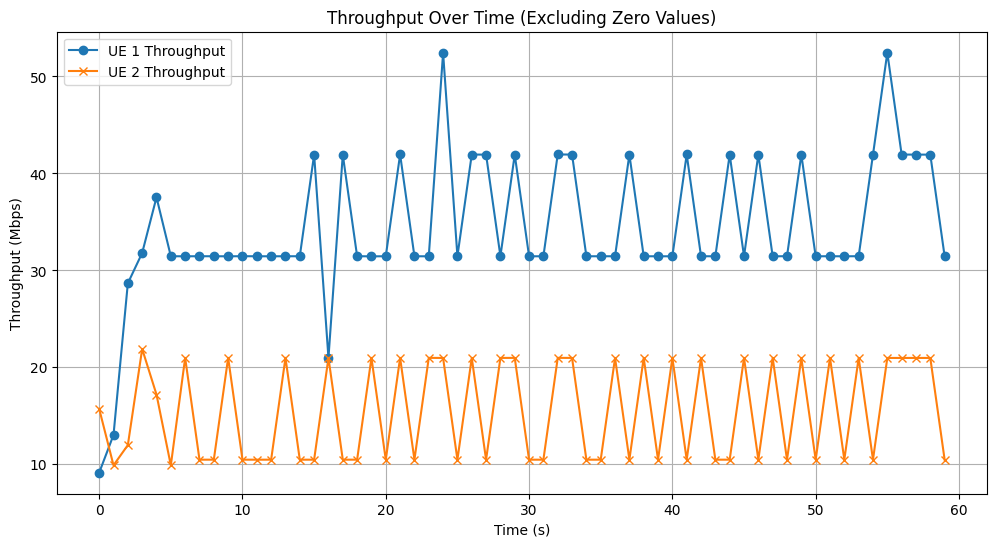

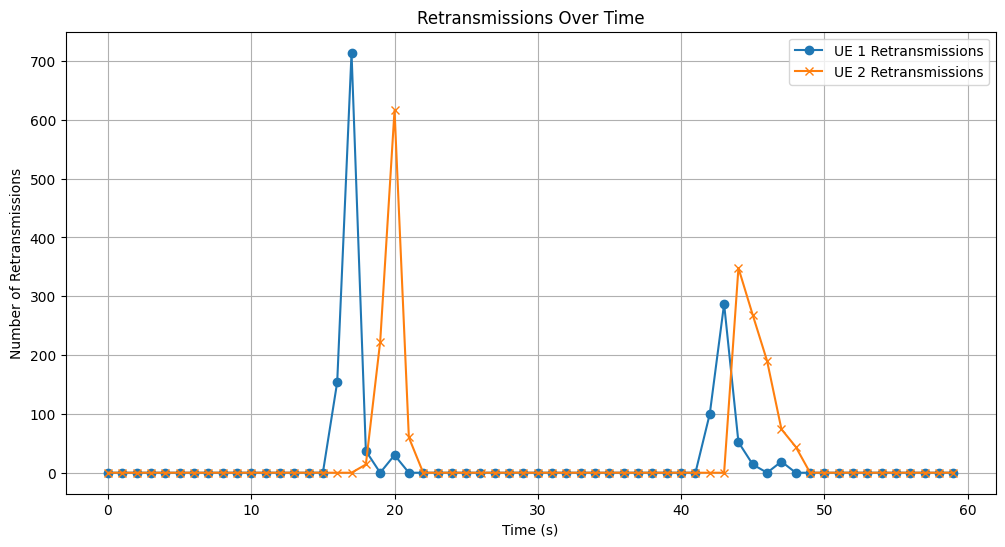

In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with the paths to your actual iperf JSON result files
file1 = 'cubic_ecn_none-result-ue1.json'
file2 = 'cubic_ecn_none-result-ue2.json'

def load_iperf_data(filename):
    """Load iperf JSON data from a file and return a pandas DataFrame."""
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Initialize lists to store the extracted data
    intervals = data['intervals']
    start_times = []
    end_times = []
    durations = []
    throughputs = []
    retransmissions = []
    
    # Iterate over each interval in the data
    for interval in intervals:
        sum_data = interval['sum']
        start_times.append(sum_data['start'])
        end_times.append(sum_data['end'])
        durations.append(sum_data['seconds'])
        # Convert throughput from bits per second to megabits per second
        throughput_mbps = sum_data['bits_per_second'] / 1_000_000  # Divide by 1,000,000
        throughputs.append(throughput_mbps)
        retransmissions.append(sum_data.get('retransmits', 0))  # Retransmits might not be present in UDP tests
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Start Time': start_times,
        'End Time': end_times,
        'Duration': durations,
        'Throughput (Mbps)': throughputs,
        'Retransmissions': retransmissions
    })
    
    return df

def filter_zero_throughput(df):
    """Filter out data points where throughput is zero."""
    return df[df['Throughput (Mbps)'] != 0].reset_index(drop=True)

# Load data from both files
df1 = load_iperf_data(file1)
df2 = load_iperf_data(file2)

# Filter out zero throughput data points for plotting throughput
# df1_nonzero = filter_zero_throughput(df1)
# df2_nonzero = filter_zero_throughput(df2)

# Calculate overall throughput and average retransmissions for each dataset
overall_throughput1 = df1['Throughput (Mbps)'].mean()
average_retransmits1 = df1['Retransmissions'].mean()

overall_throughput2 = df2['Throughput (Mbps)'].mean()
average_retransmits2 = df2['Retransmissions'].mean()

print(f"UE 1 - Overall Throughput: {overall_throughput1:.2f} Mbps")
print(f"UE 1 - Average Retransmissions: {average_retransmits1:.2f}")

print(f"\nUE 2 - Overall Throughput: {overall_throughput2:.2f} Mbps")
print(f"UE 2 - Average Retransmissions: {average_retransmits2:.2f}")

# Plotting the throughputs over time (excluding zero throughput data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Throughput (Mbps)'], label='UE 1 Throughput', marker='o')
plt.plot(df2['Start Time'], df2['Throughput (Mbps)'], label='UE 2 Throughput', marker='x')
plt.title('Throughput Over Time (Excluding Zero Values)')
plt.xlabel('Time (s)')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the retransmissions over time (include all data points)
plt.figure(figsize=(12, 6))
plt.plot(df1['Start Time'], df1['Retransmissions'], label='UE 1 Retransmissions', marker='o')
plt.plot(df2['Start Time'], df2['Retransmissions'], label='UE 2 Retransmissions', marker='x')
plt.title('Retransmissions Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Retransmissions')
plt.legend()
plt.grid(True)
plt.show()


COMMENT: the cwnd calculation is not showing the expected result. 

In [26]:

name_tx0="cubic_ecn_none"


# the csv files generated is of the following format
# timestamp, fd, cwnd, srtt

file_out_tx0_csv = name_tx0+"-ss.csv"

for ue_id in range(1, 3):
    print("Running to generate csv files " + name_tx0)

    ss_tx0_script_processing="""

    f_1={types}; 
    ue_id={ue_id};
    rm -f ${{f_1}}-ss-${{ue_id}}.csv;
    cat ${{f_1}}-ss-${{ue_id}}.txt | sed -e ":a; /<->$/ {{ N; s/<->\\n//; ba; }}"  | grep "iperf3" | grep -v "SYN-SENT"> ${{f_1}}-ss-processed-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | awk '{{print $1}}' > ts-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bcwnd:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' ' > cwnd-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\brtt:.*?(\s|$)' | awk -F '[:,]' '{{print $2}}' | tr -d ' '  | cut -d '/' -f 1   > srtt-${{f_1}}-${{ue_id}}.txt; 
    cat ${{f_1}}-ss-processed-${{ue_id}}.txt | grep -oP '\\bfd=.*?(\s|$)' | awk -F '[=,]' '{{print $2}}' | tr -d ')' | tr -d ' '   > fd-${{f_1}}-${{ue_id}}.txt;
    paste ts-${{f_1}}-${{ue_id}}.txt fd-${{f_1}}-${{ue_id}}.txt cwnd-${{f_1}}-${{ue_id}}.txt srtt-${{f_1}}-${{ue_id}}.txt -d ',' > ${{f_1}}-ss-${{ue_id}}.csv;""".format(types=name_tx0, ue_id="ue"+str(ue_id))

    tx.run(ss_tx0_script_processing)

tx.get("cubic_ecn_none"+"-ss-ue1.csv")
tx.get("cubic_ecn_none"+"-ss-ue2.csv")


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_15132\2911777773.py:12: SyntaxWarning: invalid escape sequence '\s'
  ss_tx0_script_processing="""


Running to generate csv files cubic_ecn_none
Running to generate csv files cubic_ecn_none


In [27]:
import json
import pandas as pd

throughput_data = {}
srtt_data = {}

# Dictionaries to hold data for each UE
cwnd_data = {}
srtt_data_time = {}

for ue_id in range(1, 3):
    name_tx0 = "cubic_ecn_none"
    ue_str = "ue" + str(ue_id)

    # Load the JSON output file into a Python object
    with open(f"{name_tx0}-result-{ue_str}.json") as f:
        iperf3_data = json.load(f)

    throughput_data[name_tx0 + ue_str] = iperf3_data['end']['sum_received']['bits_per_second'] / (1000000 * 1)  # to convert Mbit

    # Average SRTT for Each Flow
    columns = ['timestamp', 'flow ID', 'cwnd', 'srtt']
    df_f1 = pd.read_csv(f"{name_tx0}-ss-{ue_str}.csv", names=columns)

    # Filter out rows with flow ID = 4, they are for the control flows
    df_f1 = df_f1[df_f1['flow ID'] != 4].reset_index(drop=True)

    average_RTT_f1 = df_f1['srtt'].mean()

    # Normalize the timestamps to start from zero
    df_f1['timestamp'] = df_f1['timestamp'] - df_f1['timestamp'].iloc[0]

    # Save cwnd and srtt data into separate dataframes for each UE
    cwnd_data[ue_str] = df_f1[['timestamp', 'cwnd']]
    srtt_data_time[ue_str] = df_f1[['timestamp', 'srtt']]

    srtt_data[name_tx0 + ue_str] = average_RTT_f1

# Save throughput_data to a JSON file
with open('throughput_data.json', 'w') as f:
    json.dump(throughput_data, f)

# Save srtt_data to a JSON file
with open('srtt_data.json', 'w') as f:
    json.dump(srtt_data, f)

# Save cwnd_data and srtt_data_time to CSV files for each UE
for ue_str in cwnd_data.keys():
    cwnd_data[ue_str].to_csv(f"cwnd_data_{ue_str}.csv", index=False)
    srtt_data_time[ue_str].to_csv(f"srtt_data_time_{ue_str}.csv", index=False)


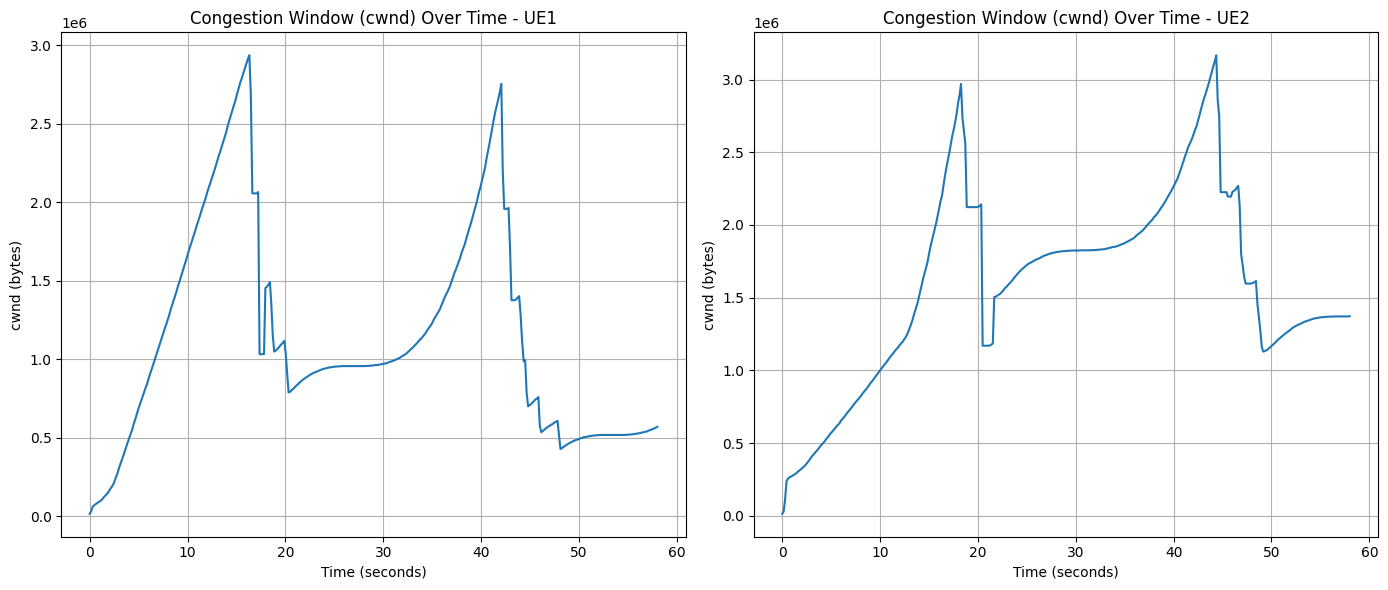

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize lists to hold data
timestamps = []
cwnds = []
ue_ids = []

# Loop through UEs to read their data
for ue_id in range(1, 3):
    ue_str = "ue" + str(ue_id)
    filename = f'cwnd_data_{ue_str}.csv'
    
    # Read the CSV file for the UE
    df = pd.read_csv(filename)
    
    # Append data to lists
    timestamps.append(df['timestamp'])
    cwnds.append(df['cwnd'] * 1448)  # Convert cwnd to bytes
    ue_ids.append(ue_str)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for each UE
for i, ue_str in enumerate(ue_ids):
    axes[i].plot(timestamps[i], cwnds[i], marker='', label=ue_str)
    axes[i].set_title(f'Congestion Window (cwnd) Over Time - {ue_str.upper()}')
    axes[i].set_xlabel('Time (seconds)')
    axes[i].set_ylabel('cwnd (bytes)')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [29]:
router.get("monitor.log")

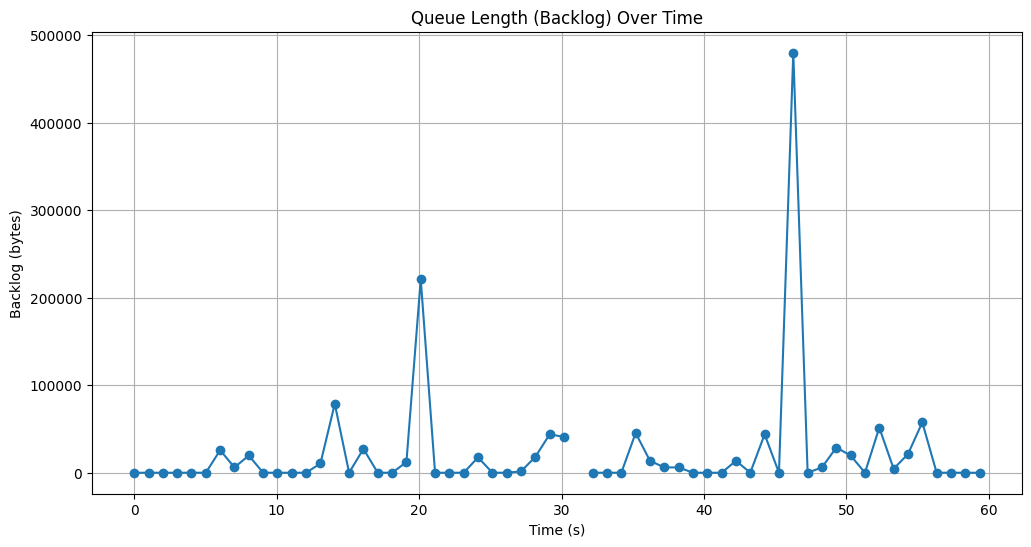

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19    154.0
20    728.0
21    260.0
22      0.0
23    706.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
30      0.0
31      0.0
32      0.0
33      0.0
34      0.0
35      0.0
36      0.0
37      0.0
38      0.0
39      0.0
40      0.0
41      0.0
42      0.0
43      0.0
44     72.0
45     28.0
46    658.0
47    297.0
48      0.0
49    278.0
50      0.0
51     63.0
52      0.0
53      0.0
54      0.0
55      0.0
56      0.0
57      0.0
58      0.0
59      0.0
Name: Dropped Packets Diff, dtype: float64


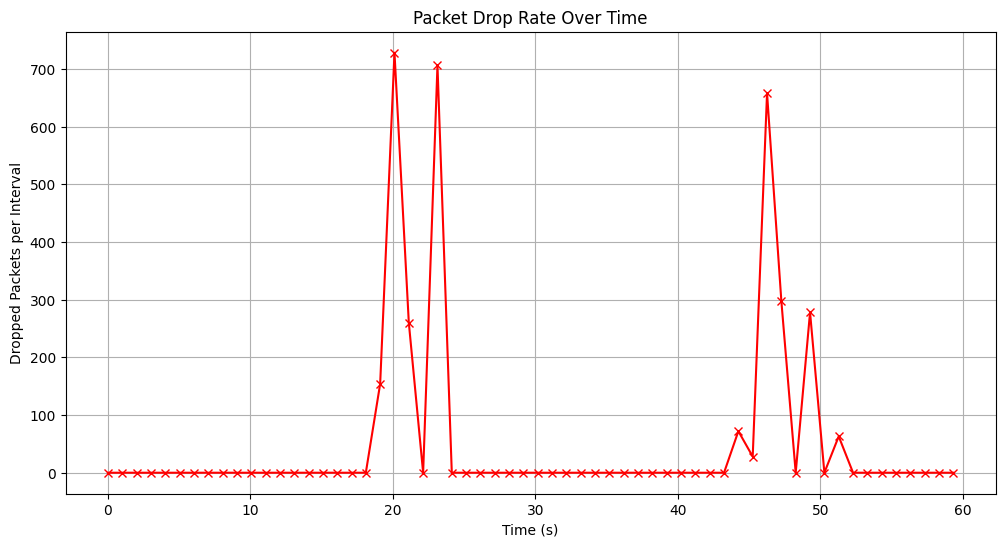

There is a backlog. Maximum backlog is 479938.0 bytes.


In [30]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your actual filename
filename = 'monitor.log'

def parse_qdisc_data(filename):
    """Parse qdisc data from a file and return a DataFrame."""
    timestamps = []
    sent_bytes = []
    sent_packets = []
    dropped_packets = []
    overlimits = []
    backlog_bytes = []
    backlog_packets = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            # Extract timestamp
            match_time = re.match(r'^(\d+\.\d+)', line)
            if match_time:
                timestamp = float(match_time.group(1))
                timestamps.append(timestamp)
            else:
                continue  # Skip line if timestamp not found

            # Extract bfifo qdisc statistics
            # Assuming 'qdisc bfifo' appears after 'qdisc htb' in the line
            bfifo_data = line.split('qdisc bfifo')[1]

            # Extract Sent bytes and packets
            match_sent = re.search(r'Sent\s+(\d+)\s+bytes\s+(\d+)\s+pkt', bfifo_data)
            if match_sent:
                sent_bytes.append(int(match_sent.group(1)))
                sent_packets.append(int(match_sent.group(2)))
            else:
                sent_bytes.append(None)
                sent_packets.append(None)

            # Extract dropped packets
            match_dropped = re.search(r'dropped\s+(\d+)', bfifo_data)
            if match_dropped:
                dropped_packets.append(int(match_dropped.group(1)))
            else:
                dropped_packets.append(None)

            # Extract overlimits
            match_overlimits = re.search(r'overlimits\s+(\d+)', bfifo_data)
            if match_overlimits:
                overlimits.append(int(match_overlimits.group(1)))
            else:
                overlimits.append(None)

            # Extract backlog bytes and packets
            match_backlog = re.search(r'backlog\s+(\d+)b\s+(\d+)p', bfifo_data)
            if match_backlog:
                backlog_bytes.append(int(match_backlog.group(1)))
                backlog_packets.append(int(match_backlog.group(2)))
            else:
                backlog_bytes.append(None)
                backlog_packets.append(None)

    # Create a DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Sent Bytes': sent_bytes,
        'Sent Packets': sent_packets,
        'Dropped Packets': dropped_packets,
        'Overlimits': overlimits,
        'Backlog Bytes': backlog_bytes,
        'Backlog Packets': backlog_packets
    })

    # Convert timestamps to relative time (seconds since start)
    df['Relative Time'] = df['Timestamp'] - df['Timestamp'].iloc[0]

    return df

def plot_queue_length(df):
    """Plot queue length (backlog) over time."""
    plt.figure(figsize=(12, 6))
    plt.plot(df['Relative Time'], df['Backlog Bytes'], marker='o')
    plt.title('Queue Length (Backlog) Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Backlog (bytes)')
    plt.grid(True)
    plt.show()

def plot_packet_drop_rate(df):
    """Plot packet drop rate over time."""
    # Calculate the difference in dropped packets between measurements
    df['Dropped Packets Diff'] = df['Dropped Packets'].diff().fillna(0)
    
    print(df['Dropped Packets Diff'])

    plt.figure(figsize=(12, 6))
    plt.plot(df['Relative Time'], df['Dropped Packets Diff'], marker='x', color='red')
    plt.title('Packet Drop Rate Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Dropped Packets per Interval')
    plt.grid(True)
    plt.show()

def analyze_backlog(df):
    """Analyze backlog and determine if there is a backlog."""
    max_backlog = df['Backlog Bytes'].max()
    if max_backlog > 0:
        print(f"There is a backlog. Maximum backlog is {max_backlog} bytes.")
    else:
        print("There is no backlog. The queue is empty throughout the measurements.")

# Main execution
df = parse_qdisc_data(filename)

# Plot queue length
plot_queue_length(df)

# Plot packet drop rate
plot_packet_drop_rate(df)

# Analyze backlog
analyze_backlog(df)


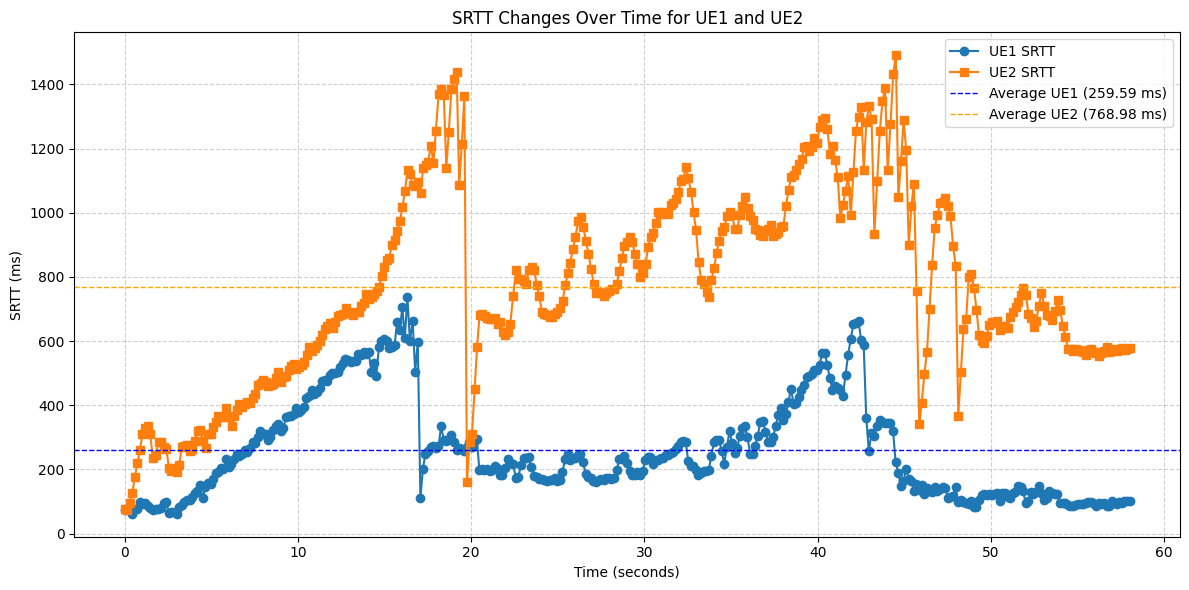

Average SRTT for UE1: 259.593 ms
Average SRTT for UE2: 768.984 ms


In [31]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the SRTT data for each UE
ue1_file_path = 'srtt_data_time_ue1.csv'  # Replace with your actual filename for UE1
ue2_file_path = 'srtt_data_time_ue2.csv'  # Replace with your actual filename for UE2

# Reading the CSV files
df_ue1 = pd.read_csv(ue1_file_path)
df_ue2 = pd.read_csv(ue2_file_path)

# Normalize timestamps to start from zero for better comparison
df_ue1['timestamp'] = df_ue1['timestamp'] - df_ue1['timestamp'].iloc[0]
df_ue2['timestamp'] = df_ue2['timestamp'] - df_ue2['timestamp'].iloc[0]

# Calculate the average SRTT for each UE
avg_ue1 = df_ue1['srtt'].mean()
avg_ue2 = df_ue2['srtt'].mean()

# Plot the SRTT changes over time for both UE1 and UE2
plt.figure(figsize=(12, 6))
plt.plot(df_ue1['timestamp'], df_ue1['srtt'], label='UE1 SRTT', marker='o')
plt.plot(df_ue2['timestamp'], df_ue2['srtt'], label='UE2 SRTT', marker='s')

# Plot average lines for each UE
plt.axhline(y=avg_ue1, color='blue', linestyle='--', linewidth=1, label=f'Average UE1 ({avg_ue1:.2f} ms)')
plt.axhline(y=avg_ue2, color='orange', linestyle='--', linewidth=1, label=f'Average UE2 ({avg_ue2:.2f} ms)')

# Adding labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('SRTT (ms)')
plt.title('SRTT Changes Over Time for UE1 and UE2')

# Adding a legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

# Print the average SRTT for each UE
print(f"Average SRTT for UE1: {avg_ue1:.3f} ms")
print(f"Average SRTT for UE2: {avg_ue2:.3f} ms")
